In [6]:
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt
from hampel import hampel
from scipy.signal import savgol_filter

In [7]:
assenza_rx1 = pd.read_csv('Dati_4_link/Assenzarx1.csv')
assenza_rx2= pd.read_csv('Dati_4_link/Assenzarx2.csv')

una_movimento_rx1=pd.read_csv('Dati_4_link/Una_movimentorx1.csv')
una_movimento_rx2=pd.read_csv('Dati_4_link/Una_movimentorx2.csv')

una_ferma_rx1=pd.read_csv('Dati_4_link/Una_fermarx1.csv')
una_ferma_rx2=pd.read_csv('Dati_4_link/Una_fermarx2.csv')

due_movimento_rx1=pd.read_csv('Dati_4_link/Due_movimentorx1.csv')
due_movimento_rx2=pd.read_csv('Dati_4_link/Due_movimentorx2.csv')

due_ferme_rx1=pd.read_csv('Dati_4_link/Due_fermerx1.csv')
due_ferme_rx2=pd.read_csv('Dati_4_link/Due_fermerx2.csv')

tre_ferme_rx1=pd.read_csv('Dati_4_link/Tre_fermerx1.csv')
tre_ferme_rx2=pd.read_csv('Dati_4_link/Tre_fermerx2.csv')

In [8]:
def unify_and_sort_data(rx1_data, rx2_data):
    """
    Unisce i dati dei due ricevitori (rx1 e rx2) utilizzando la colonna 'host_time_ms'
    come chiave, ordina i dati per timestamp e aggiunge un identificatore per ciascun ricevitore.
    
    :param rx1_data: DataFrame contenente i dati del primo ricevitore
    :param rx2_data: DataFrame contenente i dati del secondo ricevitore
    :return: DataFrame unificato e ordinato
    """
    
    # Converte la colonna 'host_time_ms' in formato datetime
    rx1_data['host_time_ms'] = pd.to_datetime(rx1_data['host_time_ms'])
    rx2_data['host_time_ms'] = pd.to_datetime(rx2_data['host_time_ms'])
    
    # Aggiungi un identificatore per il ricevitore
    rx1_data['rx'] = 'rx1'
    rx2_data['rx'] = 'rx2'
    
    # Unisce i due DataFrame usando la colonna 'host_time_ms'
    df_combined = pd.concat([rx1_data, rx2_data], ignore_index=True)
    
    # Ordina i dati in base al timestamp 'host_time_ms'
    df_combined.sort_values(by='host_time_ms', inplace=True)
    
    return df_combined

In [9]:
def convert_to_complex(csi_data):
    # Assumiamo che csi_data sia una lista con alternanza di I e Q
    complex_data = []
    for i in range(0, len(csi_data), 2):  # passo di 2 per prendere I e Q
        real = csi_data[i]
        imag = csi_data[i+1] if i+1 < len(csi_data) else 0
        complex_data.append(complex(real, imag))
    return complex_data

In [10]:
# convertiamo le stringhe in liste di numeri 

assenza_rx1['data'] = assenza_rx1['data'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
assenza_rx2['data'] = assenza_rx2['data'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

una_movimento_rx1['data'] = una_movimento_rx1['data'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
una_movimento_rx2['data'] = una_movimento_rx2['data'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    
una_ferma_rx1['data'] = una_ferma_rx1['data'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
una_ferma_rx2['data'] = una_ferma_rx2['data'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

due_movimento_rx1['data'] = due_movimento_rx1['data'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
due_movimento_rx2['data'] = due_movimento_rx2['data'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

due_ferme_rx1['data'] = due_ferme_rx1['data'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
due_ferme_rx2['data'] = due_ferme_rx2['data'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

tre_ferme_rx1['data'] = tre_ferme_rx1['data'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
tre_ferme_rx2['data'] = tre_ferme_rx2['data'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


In [11]:
due_movimento_rx1

type      id                mac  rssi  rate  sig_mode  mcs  \
0      CSI_DATA  194763  34:85:18:a1:3f:08   -52    11         1    0   
1      CSI_DATA  194764  34:85:18:a1:3f:08   -52    11         1    0   
2      CSI_DATA  194765  34:85:18:a1:40:f0   -52    11         1    0   
3      CSI_DATA  194766  34:85:18:a1:3f:08   -52    11         1    0   
4      CSI_DATA  194767  34:85:18:a1:40:f0   -52    11         1    0   
...         ...     ...                ...   ...   ...       ...  ...   
40321  CSI_DATA  235084  34:85:18:a1:3f:08   -53    11         1    0   
40322  CSI_DATA  235085  34:85:18:a1:3f:08   -53    11         1    0   
40323  CSI_DATA  235086  34:85:18:a1:40:f0   -47    11         1    0   
40324  CSI_DATA  235087  34:85:18:a1:3f:08   -51    11         1    0   
40325  CSI_DATA  235088  34:85:18:a1:40:f0   -48    11         1    0   

       bandwidth  smoothing  not_sounding  ...  local_timestamp  ant  sig_len  \
0              1          1             1  ...       3033030430    0       48   
1              1          1             1  ...       3033046529    0       48   
2              1          1             1  ...       3033061453    0       48   
3              1          1             1  ...       3033077473    0       48   
4              1          1             1  ...       3033092566    0       48   
...          ...        ...           ...  ...              ...  ...      ...   
40321          1          1             1  ...       3663031757    0       48   
40322          1          1             1  ...       3663046769    0       48   
40323          1          1             1  ...       3663061750    0       48   
40324          1          1             1  ...       3663076692    0       48   
40325          1          1             1  ...       3663092817    0       48   

       rx_state  len  first_word  \
0             0  384           0   
1             0  384           0   
2             0  384           0   
3             0  384           0   
4             0  384           0   
...         ...  ...         ...   
40321         0  384           0   
40322         0  384           0   
40323         0  384           0   
40324         0  384           0   
40325         0  384           0   

                                                    data  local_timestamp_ms  \
0      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -8, 7, -8...             3033030   
1      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 9, 5, ...             3033046   
2      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, -3, 1...             3033061   
3      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 9,...             3033077   
4      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -10, -6, ...             3033092   
...                                                  ...                 ...   
40321  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, -4, 1...             3663031   
40322  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, -12, 3...             3663046   
40323  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -15, 1...             3663061   
40324  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -4, 10, -...             3663076   
40325  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 5, 12...             3663092   

                  host_time_ms  host_epoch_ms  
0      2025-09-09 11:25:34.409  1757409934409  
1      2025-09-09 11:25:34.424  1757409934424  
2      2025-09-09 11:25:34.439  1757409934439  
3      2025-09-09 11:25:34.454  1757409934454  
4      2025-09-09 11:25:34.468  1757409934468  
...                        ...            ...  
40321  2025-09-09 11:36:04.417  1757410564417  
40322  2025-09-09 11:36:04.432  1757410564432  
40323  2025-09-09 11:36:04.447  1757410564447  
40324  2025-09-09 11:36:04.463  1757410564463  
40325  2025-09-09 11:36:04.478  1757410564478  

[40326 rows x 28 columns]

In [12]:
#trasformo i dati in numeri complessi
assenza_rx1['data_complex'] = assenza_rx1['data'].apply(convert_to_complex)
assenza_rx2['data_complex'] = assenza_rx2['data'].apply(convert_to_complex)

una_movimento_rx1['data_complex'] = una_movimento_rx1['data'].apply(convert_to_complex)
una_movimento_rx2['data_complex'] = una_movimento_rx2['data'].apply(convert_to_complex)

una_ferma_rx1['data_complex'] = una_ferma_rx1['data'].apply(convert_to_complex)
una_ferma_rx2['data_complex'] = una_ferma_rx2['data'].apply(convert_to_complex)

due_movimento_rx1['data_complex'] = due_movimento_rx1['data'].apply(convert_to_complex)
due_movimento_rx2['data_complex'] = due_movimento_rx2['data'].apply(convert_to_complex)

due_ferme_rx1['data_complex'] = due_ferme_rx1['data'].apply(convert_to_complex)
due_ferme_rx2['data_complex'] = due_ferme_rx2['data'].apply(convert_to_complex)

tre_ferme_rx1['data_complex'] = tre_ferme_rx1['data'].apply(convert_to_complex)
tre_ferme_rx2['data_complex'] = tre_ferme_rx2['data'].apply(convert_to_complex)



In [13]:
# Seleziona solo le colonne di interesse
columns_to_keep = ['data_complex', 'host_time_ms', 'mac']

# Rimuovi tutte le altre colonne
assenza_rx1_cleaned = assenza_rx1[columns_to_keep]
assenza_rx2_cleaned = assenza_rx2[columns_to_keep]

una_movimento_rx1_cleaned = una_movimento_rx1[columns_to_keep]
una_movimento_rx2_cleaned = una_movimento_rx2[columns_to_keep]

una_ferma_rx1_cleaned = una_ferma_rx1[columns_to_keep]
una_ferma_rx2_cleaned = una_ferma_rx2[columns_to_keep]

due_movimento_rx1_cleaned = due_movimento_rx1[columns_to_keep]
due_movimento_rx2_cleaned = due_movimento_rx2[columns_to_keep]

due_ferme_rx1_cleaned = due_ferme_rx1[columns_to_keep]
due_ferme_rx2_cleaned = due_ferme_rx2[columns_to_keep]

tre_ferme_rx1_cleaned = tre_ferme_rx1[columns_to_keep]
tre_ferme_rx2_cleaned = tre_ferme_rx2[columns_to_keep]    

In [14]:
# Separiamo i numeri complessi in colonne direttamente nel DataFrame originale
assenza_rx1_cleaned[[f'{i}' for i in range(len(assenza_rx1_cleaned['data_complex'].iloc[0]))]] = pd.DataFrame(assenza_rx1_cleaned['data_complex'].tolist(), index=assenza_rx1_cleaned.index)
assenza_rx2_cleaned[[f'{i}' for i in range(len(assenza_rx2_cleaned['data_complex'].iloc[0]))]] = pd.DataFrame(assenza_rx2_cleaned['data_complex'].tolist(), index=assenza_rx2_cleaned.index)

una_movimento_rx1_cleaned[[f'{i}' for i in range(len(una_movimento_rx1_cleaned['data_complex'].iloc[0]))]] = pd.DataFrame(una_movimento_rx1_cleaned['data_complex'].tolist(), index=una_movimento_rx1_cleaned.index)
una_movimento_rx2_cleaned[[f'{i}' for i in range(len(una_movimento_rx2_cleaned['data_complex'].iloc[0]))]] = pd.DataFrame(una_movimento_rx2_cleaned['data_complex'].tolist(), index=una_movimento_rx2_cleaned.index)

una_ferma_rx1_cleaned[[f'{i}' for i in range(len(una_ferma_rx1_cleaned['data_complex'].iloc[0]))]] = pd.DataFrame(una_ferma_rx1_cleaned['data_complex'].tolist(), index=una_ferma_rx1_cleaned.index)
una_ferma_rx2_cleaned[[f'{i}' for i in range(len(una_ferma_rx2_cleaned['data_complex'].iloc[0]))]] = pd.DataFrame(una_ferma_rx2_cleaned['data_complex'].tolist(), index=una_ferma_rx2_cleaned.index)

due_movimento_rx1_cleaned[[f'{i}' for i in range(len(due_movimento_rx1_cleaned['data_complex'].iloc[0]))]] = pd.DataFrame(due_movimento_rx1_cleaned['data_complex'].tolist(), index=due_movimento_rx1_cleaned.index)
due_movimento_rx2_cleaned[[f'{i}' for i in range(len(due_movimento_rx2_cleaned['data_complex'].iloc[0]))]] = pd.DataFrame(due_movimento_rx2_cleaned['data_complex'].tolist(), index=due_movimento_rx2_cleaned.index)

due_ferme_rx1_cleaned[[f'{i}' for i in range(len(due_ferme_rx1_cleaned['data_complex'].iloc[0]))]] = pd.DataFrame(due_ferme_rx1_cleaned['data_complex'].tolist(), index=due_ferme_rx1_cleaned.index)
due_ferme_rx2_cleaned[[f'{i}' for i in range(len(due_ferme_rx2_cleaned['data_complex'].iloc[0]))]] = pd.DataFrame(due_ferme_rx2_cleaned['data_complex'].tolist(), index=due_ferme_rx2_cleaned.index)

tre_ferme_rx1_cleaned[[f'{i}' for i in range(len(tre_ferme_rx1_cleaned['data_complex'].iloc[0]))]] = pd.DataFrame(tre_ferme_rx1_cleaned['data_complex'].tolist(), index=tre_ferme_rx1_cleaned.index)
tre_ferme_rx2_cleaned[[f'{i}' for i in range(len(tre_ferme_rx2_cleaned['data_complex'].iloc[0]))]] = pd.DataFrame(tre_ferme_rx2_cleaned['data_complex'].tolist(), index=tre_ferme_rx2_cleaned.index)


C:\Users\mariu\AppData\Local\Temp\ipykernel_16756\790311089.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assenza_rx1_cleaned[[f'{i}' for i in range(len(assenza_rx1_cleaned['data_complex'].iloc[0]))]] = pd.DataFrame(assenza_rx1_cleaned['data_complex'].tolist(), index=assenza_rx1_cleaned.index)
C:\Users\mariu\AppData\Local\Temp\ipykernel_16756\790311089.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assenza_rx1_cleaned[[f'{i}' for i in range(len(assenza_rx1_cleaned['data_complex'].iloc[0]))]] = pd

In [140]:
una_movimento_rx1_cleaned

host_time_ms                mac         0         1  \
0      2025-09-09 10:46:18.803  34:85:18:a1:40:f0  0.0+0.0j  0.0+0.0j   
1      2025-09-09 10:46:18.820  34:85:18:a1:3f:08  0.0+0.0j  0.0+0.0j   
2      2025-09-09 10:46:18.834  34:85:18:a1:40:f0  0.0+0.0j  0.0+0.0j   
3      2025-09-09 10:46:18.851  34:85:18:a1:3f:08  0.0+0.0j  0.0+0.0j   
4      2025-09-09 10:46:18.866  34:85:18:a1:40:f0  0.0+0.0j  0.0+0.0j   
...                        ...                ...       ...       ...   
40084  2025-09-09 10:56:43.367  34:85:18:a1:40:f0  0.0+0.0j  0.0+0.0j   
40085  2025-09-09 10:56:43.383  34:85:18:a1:3f:08  0.0+0.0j  0.0+0.0j   
40086  2025-09-09 10:56:43.398  34:85:18:a1:40:f0  0.0+0.0j  0.0+0.0j   
40087  2025-09-09 10:56:43.413  34:85:18:a1:40:f0  0.0+0.0j  0.0+0.0j   
40088  2025-09-09 10:56:43.430  34:85:18:a1:3f:08  0.0+0.0j  0.0+0.0j   

              2         3         4         5           6           7  ...  \
0      0.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j  -5.0-11.0j  -5.0-11.0j  ...   
1      0.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j  -8.0- 6.0j  -8.0- 6.0j  ...   
2      0.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j -12.0+ 0.0j -12.0+ 1.0j  ...   
3      0.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j  -4.0- 9.0j  -4.0- 9.0j  ...   
4      0.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j   5.0+10.0j   5.0+10.0j  ...   
...         ...       ...       ...       ...         ...         ...  ...   
40084  0.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j   6.0+ 6.0j   5.0+ 6.0j  ...   
40085  0.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j  10.0- 3.0j   9.0- 3.0j  ...   
40086  0.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j  -8.0+ 4.0j  -7.0+ 4.0j  ...   
40087  0.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j  -5.0+ 7.0j  -5.0+ 7.0j  ...   
40088  0.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j  -6.0-10.0j  -5.0- 9.0j  ...   

              182         183         184         185         186         187  \
0     -55.0+28.0j -54.0+24.0j -53.0+27.0j -52.0+26.0j -59.0+25.0j -53.0+36.0j   
1      20.0-52.0j  32.0-49.0j  30.0-51.0j  24.0-55.0j  33.0-52.0j  31.0-48.0j   
2      11.0+54.0j   9.0+60.0j  13.0+55.0j  17.0+57.0j  15.0+54.0j  17.0+61.0j   
3      53.0-23.0j  52.0-25.0j  50.0-23.0j  54.0-29.0j  61.0-20.0j  51.0-24.0j   
4      56.0-25.0j  55.0-27.0j  50.0-27.0j  52.0-27.0j  57.0-26.0j  51.0-24.0j   
...           ...         ...         ...         ...         ...         ...   
40084  38.0-40.0j  35.0-44.0j  34.0-41.0j  37.0-48.0j  38.0-41.0j  32.0-40.0j   
40085   7.0+64.0j   5.0+67.0j   4.0+65.0j   2.0+69.0j   0.0+68.0j  -1.0+63.0j   
40086  26.0+49.0j  25.0+47.0j  31.0+43.0j  38.0+45.0j  31.0+43.0j  34.0+40.0j   
40087  55.0+15.0j  51.0+20.0j  46.0+20.0j  54.0+20.0j  54.0+19.0j  48.0+12.0j   
40088  54.0-40.0j  57.0-41.0j  51.0-36.0j  59.0-39.0j  63.0-34.0j  57.0-37.0j   

              188         189         190       191  
0     -53.0+31.0j -59.0+33.0j -52.0+28.0j  0.0+0.0j  
1      31.0-53.0j  30.0-53.0j  29.0-45.0j  0.0+0.0j  
2      22.0+60.0j  22.0+67.0j  20.0+63.0j  0.0+0.0j  
3      52.0-26.0j  53.0-17.0j  53.0-19.0j  0.0+0.0j  
4      52.0-36.0j  52.0-35.0j  56.0-29.0j  0.0+0.0j  
...           ...         ...         ...       ...  
40084  34.0-45.0j  41.0-45.0j  32.0-46.0j  0.0+0.0j  
40085   1.0+67.0j  -4.0+65.0j  -8.0+62.0j  0.0+0.0j  
40086  31.0+45.0j  36.0+46.0j  29.0+49.0j  0.0+0.0j  
40087  51.0+16.0j  55.0+19.0j  51.0+16.0j  0.0+0.0j  
40088  61.0-36.0j  64.0-32.0j  60.0-32.0j  0.0+0.0j  

[40089 rows x 194 columns]

In [15]:
# Rimuoviamo la colonna originale dei numeri complessi che ora sono state separate in colonne individuali

assenza_rx1_cleaned= assenza_rx1_cleaned.drop(columns=['data_complex'])
assenza_rx2_cleaned= assenza_rx2_cleaned.drop(columns=['data_complex'])

una_movimento_rx1_cleaned= una_movimento_rx1_cleaned.drop(columns=['data_complex'])
una_movimento_rx2_cleaned= una_movimento_rx2_cleaned.drop(columns=['data_complex'])

una_ferma_rx1_cleaned= una_ferma_rx1_cleaned.drop(columns=['data_complex'])
una_ferma_rx2_cleaned= una_ferma_rx2_cleaned.drop(columns=['data_complex'])

due_movimento_rx1_cleaned= due_movimento_rx1_cleaned.drop(columns=['data_complex'])
due_movimento_rx2_cleaned= due_movimento_rx2_cleaned.drop(columns=['data_complex'])

due_ferme_rx1_cleaned= due_ferme_rx1_cleaned.drop(columns=['data_complex'])
due_ferme_rx2_cleaned= due_ferme_rx2_cleaned.drop(columns=['data_complex'])

tre_ferme_rx1_cleaned= tre_ferme_rx1_cleaned.drop(columns=['data_complex'])
tre_ferme_rx2_cleaned= tre_ferme_rx2_cleaned.drop(columns=['data_complex'])


In [16]:
def split_csi_dataset(df: pd.DataFrame):
    """
    Divide un DataFrame CSI in due dataset separati:
      - LLTF (0..63)
      - HT-LTF (-64..-1, 0..63)
    
    Restituisce:
      lltf_data_df, htltf_data_df
    """
    # --- 0) Meta colonne da tenere (solo quelle presenti davvero) ---
    candidate_meta = ["rx", "host_time_ms", "mac"]
    meta_cols = [c for c in candidate_meta if c in df.columns]

    # --- 1) Mappa colonne 'numeric-like' -> interi ---
    numlike_map = {}
    for c in df.columns:
        try:
            ci = int(c)
            numlike_map[c] = ci
        except Exception:
            pass
    if numlike_map:
        df = df.rename(columns=numlike_map)

    # --- 2) Se NON abbiamo le 192 colonne 0..191, prova da 'data_complex' ---
    needed_cols = list(range(192))
    missing_numeric = [c for c in needed_cols if c not in df.columns]

    if missing_numeric:
        if "data_complex" not in df.columns:
            raise ValueError("Non trovo né le colonne 0..191 né la colonna 'data_complex'.")
        expanded = pd.DataFrame(
            df["data_complex"].apply(
                lambda x: list(x) if isinstance(x, (list, tuple, np.ndarray)) else np.nan
            ).tolist(),
            index=df.index
        )
        expanded.columns = list(range(expanded.shape[1]))
        if expanded.shape[1] < 192:
            raise ValueError(f"'data_complex' non ha 192 elementi (ne ha {expanded.shape[1]}).")
        expanded = expanded[needed_cols]
        for c in needed_cols:
            if c not in df.columns:
                df[c] = expanded[c]

    # --- 3) Indici sorgente ---
    lltf_src   = list(range(0, 64))       # 0..63
    ht_pos_src = list(range(64, 128))     # 64..127
    ht_neg_src = list(range(128, 192))    # 128..191

    # --- 4) Costruisci i due dataset ---
    lltf_df = pd.concat([df[meta_cols], df[lltf_src]], axis=1)

    htltf_part = pd.concat([df[ht_pos_src], df[ht_neg_src]], axis=1)
    htltf_part.columns = list(range(0, 64)) + list(range(-64, 0))
    ordered = list(range(-64, 0)) + list(range(0, 64))
    htltf_df = pd.concat([df[meta_cols], htltf_part[ordered]], axis=1)

    # --- 5) Rimuovi colonne sempre 0 ---
    def clean_zero_only(data_df):
        data_cols = [c for c in data_df.columns if c not in meta_cols]
        vals = data_df[data_cols].applymap(
            lambda z: 0+0j if (z is None or (isinstance(z, float) and np.isnan(z))) else complex(z)
        )
        mask_keep = (vals.to_numpy() != 0).any(axis=0)
        cols_to_keep = [col for col, keep in zip(data_cols, mask_keep) if keep]
        return pd.concat([data_df[meta_cols], data_df[cols_to_keep]], axis=1)

    lltf_cleaned = clean_zero_only(lltf_df)
    htltf_cleaned = clean_zero_only(htltf_df)

    return lltf_cleaned, htltf_cleaned


# grafici

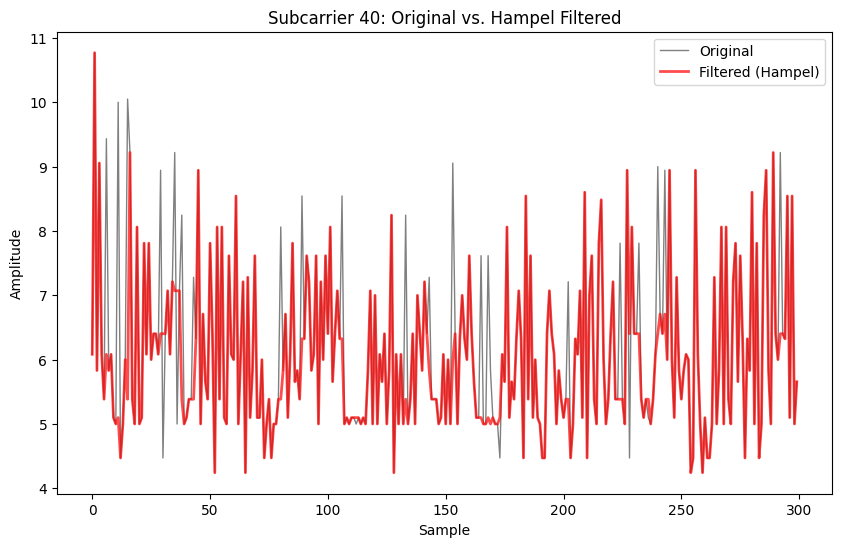

In [217]:

# 2. Applica il filtro di Hampel per generare il dataset pulito
def hampel_filter(series, window_size=5, n_sigmas=3):
    rolling_median = series.rolling(window_size, center=True).median()
    abs_deviation = np.abs(series - rolling_median)
    mad = abs_deviation.rolling(window_size, center=True).median()
    threshold = n_sigmas * 1.4826 * mad
    outlier = abs_deviation > threshold
    series[outlier] = rolling_median[outlier]
    return series

assenza_rx1_filtered = assenza_rx1_cleaned.copy()
subcarrier_cols = [str(i) for i in range(192)]  # adatta alle tue colonne
for col in subcarrier_cols:
    assenza_rx1_filtered[col] = hampel_filter(assenza_rx1_filtered[col].apply(np.abs), window_size=7, n_sigmas=3)

# Scegli una subcarrier significativa, ad esempio quella coi valori più variabili
sc = "40"  # Cambia secondo quella di interesse

vals_orig = assenza_rx1_cleaned[sc].apply(np.abs).values[:300]
vals_clean = assenza_rx1_filtered[sc].apply(np.abs).values[:300]

plt.figure(figsize=(10, 6))
plt.plot(vals_orig, label='Original', color='gray', linewidth=1)
plt.plot(vals_clean, label='Filtered (Hampel)', color='red', linewidth=2, alpha=0.7)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title(f'Subcarrier {sc}: Original vs. Hampel Filtered')
plt.legend()
plt.show()


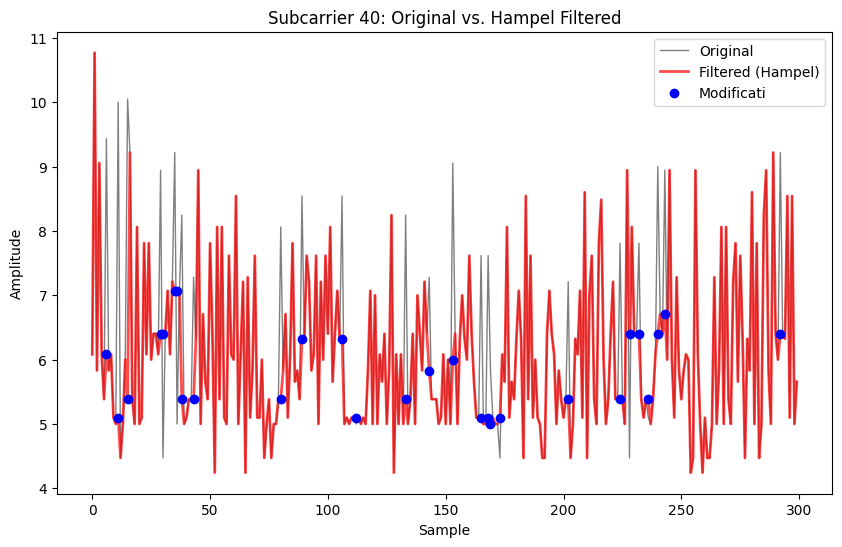

In [218]:
# Serie originali e filtrate (che hai già)
vals_orig = assenza_rx1_cleaned[sc].apply(np.abs).values[:300]
vals_clean = assenza_rx1_filtered[sc].apply(np.abs).values[:300]

# Trova i punti modificati (tolleranza molto piccola)
mod_idx = np.where(np.isclose(vals_orig, vals_clean, atol=1e-8) == False)[0]

plt.figure(figsize=(10, 6))
plt.plot(vals_orig, label='Original', color='gray', linewidth=1)
plt.plot(vals_clean, label='Filtered (Hampel)', color='red', linewidth=2, alpha=0.7)
plt.scatter(mod_idx, vals_clean[mod_idx], color='blue', label='Modificati', zorder=3)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title(f'Subcarrier {sc}: Original vs. Hampel Filtered')
plt.legend()
plt.show()


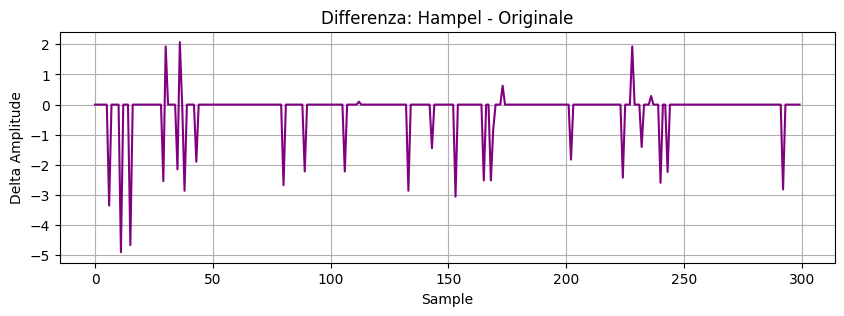

In [219]:
plt.figure(figsize=(10, 3))
plt.plot(vals_clean - vals_orig, color='purple')
plt.title('Differenza: Hampel - Originale')
plt.xlabel('Sample')
plt.ylabel('Delta Amplitude')
plt.grid(True)
plt.show()


In [220]:
print(f"N. punti modificati da Hampel: {len(mod_idx)} su {len(vals_orig)}")


N. punti modificati da Hampel: 28 su 300


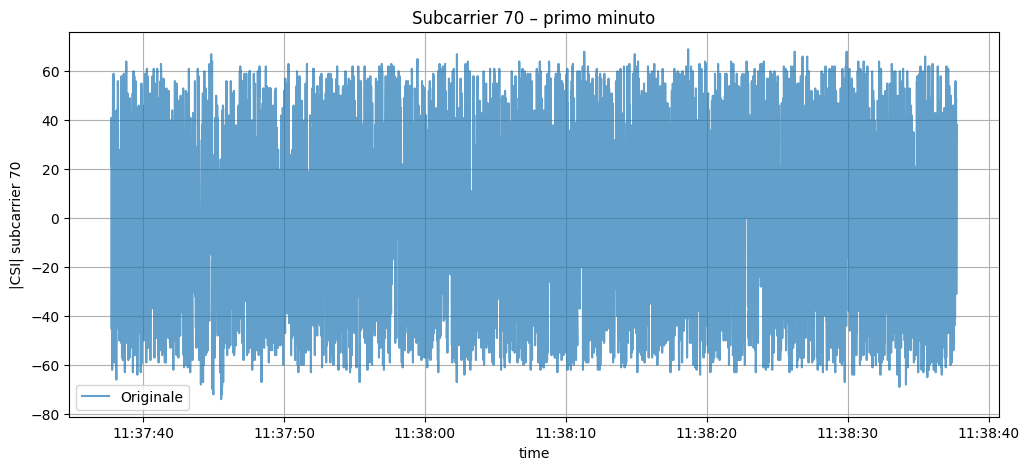

In [ ]:
df = assenza_rx1_cleaned.copy()
df['host_time_ms'] = pd.to_datetime(df['host_time_ms'])
df = df.set_index('host_time_ms').sort_index()
sub = "70"
t0 = df.index[10]                 # ora è Timestamp, non int
t1 = t0 + pd.Timedelta("1min")   # ok

orig_1m = df.loc[t0:t1]

plt.figure(figsize=(12, 5))
plt.plot(orig_1m.index, orig_1m[sub], label="Originale", alpha=0.7)
plt.xlabel("time")
plt.ylabel(f"|CSI| subcarrier {sub}")
plt.title(f"Subcarrier {sub} – primo minuto")
plt.legend()
plt.grid(True)
plt.show()


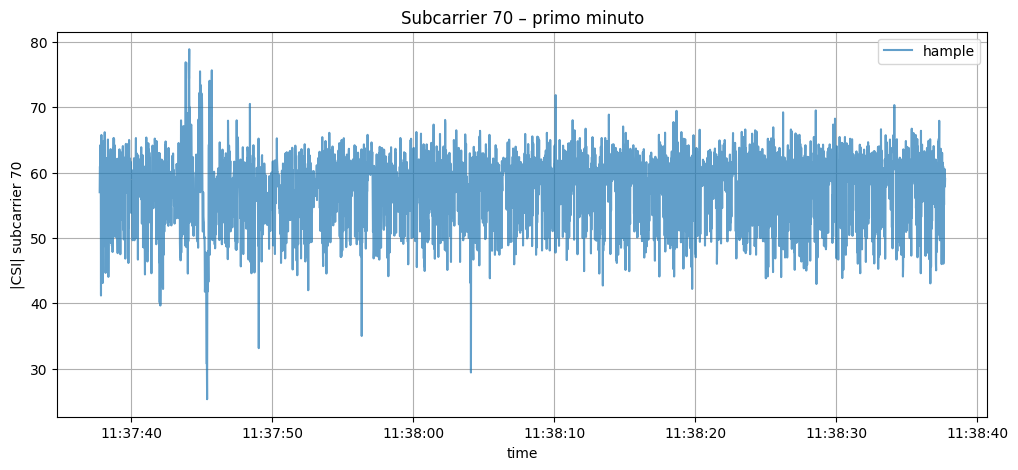

In [ ]:
df_hampel = assenza_rx1_filtered.copy()
df_hampel['host_time_ms'] = pd.to_datetime(df_hampel['host_time_ms'])
df_hampel = df_hampel.set_index('host_time_ms').sort_index()

sub = "70"
t0 = df_hampel.index[10]                 # ora è Timestamp, non int
t1 = t0 + pd.Timedelta("1min")   # ok

X_hampel = df_hampel.loc[t0:t1]

plt.figure(figsize=(12, 5))
plt.plot(X_hampel.index, X_hampel[sub], label="hample", alpha=0.7)
plt.xlabel("time")
plt.ylabel(f"|CSI| subcarrier {sub}")
plt.title(f"Subcarrier {sub} – primo minuto")
plt.legend()
plt.grid(True)
plt.show()


c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


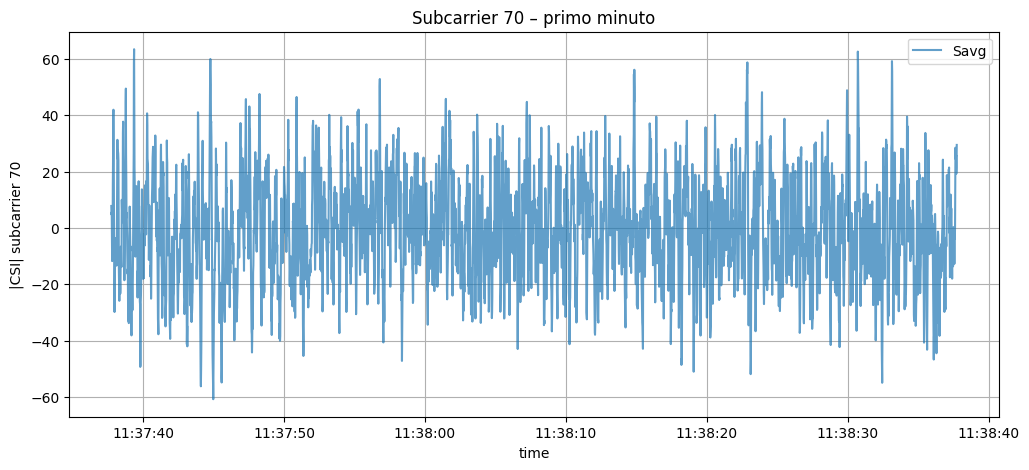

In [184]:
df_savg = df_filt.copy()
df_savg['host_time_ms'] = pd.to_datetime(df_savg['host_time_ms'])
df_savg = df_savg.set_index('host_time_ms').sort_index()

sub = "70"
t0 = df_savg.index[10]                 # ora è Timestamp, non int
t1 = t0 + pd.Timedelta("1min")   # ok

X_savg = df_savg.loc[t0:t1]

plt.figure(figsize=(12, 5))
plt.plot(X_savg.index, X_savg[sub], label="Savg", alpha=0.7)
plt.xlabel("time")
plt.ylabel(f"|CSI| subcarrier {sub}")
plt.title(f"Subcarrier {sub} – primo minuto")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from scipy.signal import savgol_filter

df = assenza_rx1_cleaned.sort_values('host_time_ms')

# Seleziona solo le colonne numeriche 0..191
csi_cols = [str(i) for i in range(192)]  # se le colonne sono stringhe "0","1",...
# oppure:
# csi_cols = list(range(192))            # se sono int 0,1,...


In [191]:
from scipy.signal import savgol_filter

df_filt = assenza_rx1_filtered.sort_values('host_time_ms')

# Seleziona solo le colonne numeriche 0..191
csi_cols = [str(i) for i in range(192)]  # se le colonne sono stringhe "0","1",...
# oppure:
# csi_cols = list(range(192))            # se sono int 0,1,...


In [192]:
window_length = 11   # per es. 11 campioni
polyorder = 3

# Estrai la matrice complessa
X = df_filt[csi_cols].to_numpy()

# Applica il filtro separatamente a reale e immaginario lungo l’asse 0 (tempo)
X_real_filt = savgol_filter(X.real, window_length=window_length,
                            polyorder=polyorder, axis=0)
X_imag_filt = savgol_filter(X.imag, window_length=window_length,
                            polyorder=polyorder, axis=0)

X_filt_2 = X_real_filt + 1j * X_imag_filt

# Rimetti nel DataFrame, creando ad esempio nuove colonne
df_filt_2 = df_filt.copy()
df_filt_2[csi_cols] = X_filt_2


In [161]:
window_length = 11   # per es. 11 campioni
polyorder = 3

# Estrai la matrice complessa
X = df[csi_cols].to_numpy()

# Applica il filtro separatamente a reale e immaginario lungo l’asse 0 (tempo)
X_real_filt = savgol_filter(X.real, window_length=window_length,
                            polyorder=polyorder, axis=0)
X_imag_filt = savgol_filter(X.imag, window_length=window_length,
                            polyorder=polyorder, axis=0)

X_filt = X_real_filt + 1j * X_imag_filt

# Rimetti nel DataFrame, creando ad esempio nuove colonne
df_filt = df.copy()
df_filt[csi_cols] = X_filt


In [194]:
for name in ["assenza_rx1_cleaned", "assenza_rx1_filtered", "df_filt"]:
    tmp = globals()[name].copy()
    tmp["host_time_ms"] = pd.to_datetime(tmp["host_time_ms"])
    tmp = tmp.set_index("host_time_ms").sort_index()
    globals()[name] = tmp

sub = "70"

# prendi l’inizio dal dataset originale (puoi cambiarlo)
t0 = assenza_rx1_cleaned.index[0]
t1 = t0 + pd.Timedelta("1min")

orig_1m = assenza_rx1_cleaned.loc[t0:t1]
hamp_1m = assenza_rx1_filtered.loc[t0:t1]
sg_1m   = df_filt.loc[t0:t1]



KeyError: 'host_time_ms'

c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


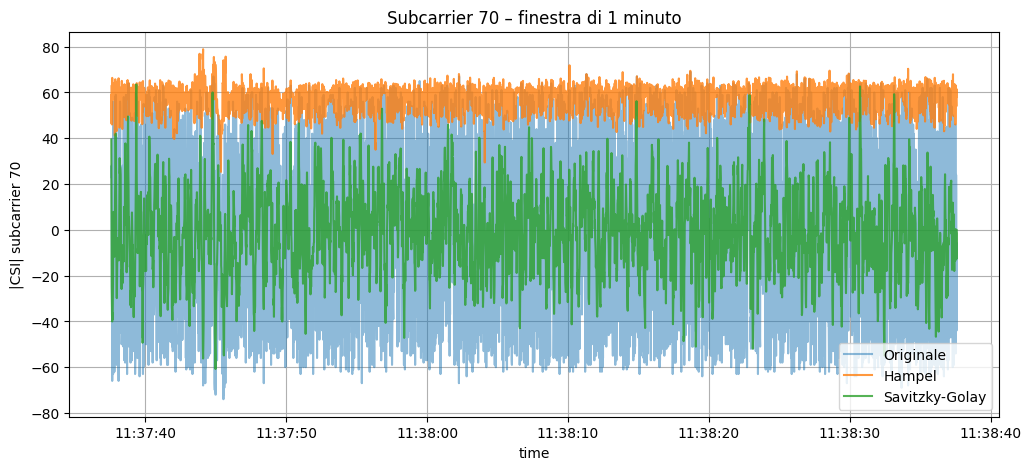

In [186]:
plt.figure(figsize=(12, 5))

plt.plot(orig_1m.index, orig_1m[sub],
         label="Originale", alpha=0.5)

plt.plot(hamp_1m.index, hamp_1m[sub],
         label="Hampel", alpha=0.8)

plt.plot(sg_1m.index, sg_1m[sub],
         label="Savitzky-Golay", alpha=0.8)

plt.xlabel("time")
plt.ylabel(f"|CSI| subcarrier {sub}")
plt.title(f"Subcarrier {sub} – finestra di 1 minuto")
plt.legend()
plt.grid(True)
plt.show()


c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


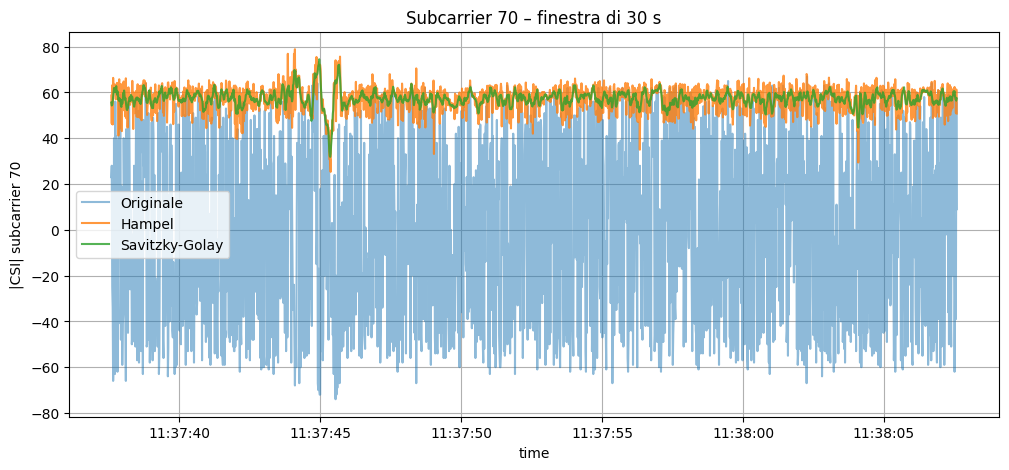

In [193]:
sub = "70"

# prendo un istante di inizio (es. il primo)
t0 = assenza_rx1_cleaned.index[0]          # deve essere già DatetimeIndex
t1 = t0 + pd.Timedelta("30s")             # 30 secondi

orig_30s = assenza_rx1_cleaned.loc[t0:t1]
hamp_30s = assenza_rx1_filtered.loc[t0:t1]
sg_30s   = df_filt_2.loc[t0:t1]

plt.figure(figsize=(12, 5))
plt.plot(orig_30s.index, orig_30s[sub], label="Originale", alpha=0.5)
plt.plot(hamp_30s.index, hamp_30s[sub], label="Hampel", alpha=0.8)
plt.plot(sg_30s.index,   sg_30s[sub],   label="Savitzky-Golay", alpha=0.8)

plt.xlabel("time")
plt.ylabel(f"|CSI| subcarrier {sub}")
plt.title(f"Subcarrier {sub} – finestra di 30 s")
plt.legend()
plt.grid(True)
plt.show()


c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


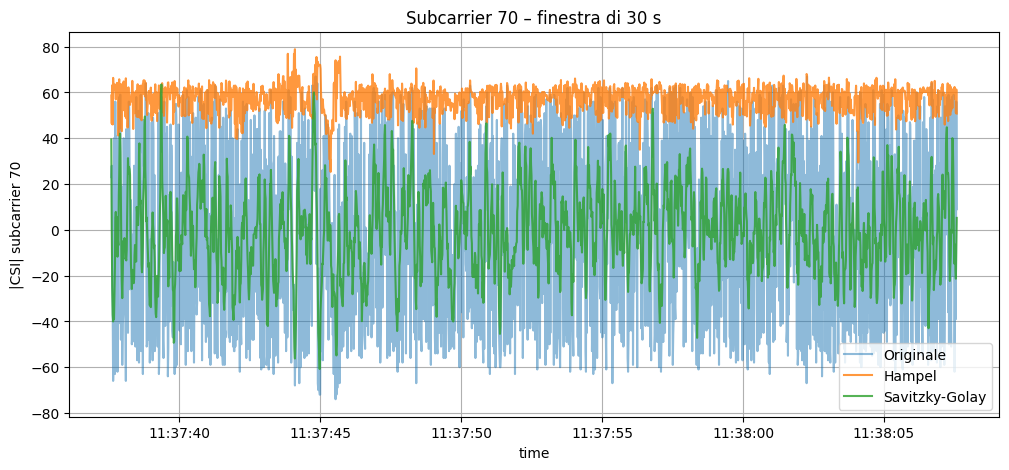

In [190]:
sub = "70"

# prendo un istante di inizio (es. il primo)
t0 = assenza_rx1_cleaned.index[0]          # deve essere già DatetimeIndex
t1 = t0 + pd.Timedelta("30s")             # 30 secondi

orig_30s = assenza_rx1_cleaned.loc[t0:t1]
hamp_30s = assenza_rx1_filtered.loc[t0:t1]
sg_30s   = df_filt.loc[t0:t1]

plt.figure(figsize=(12, 5))
plt.plot(orig_30s.index, orig_30s[sub], label="Originale", alpha=0.5)
plt.plot(hamp_30s.index, hamp_30s[sub], label="Hampel", alpha=0.8)
plt.plot(sg_30s.index,   sg_30s[sub],   label="Savitzky-Golay", alpha=0.8)

plt.xlabel("time")
plt.ylabel(f"|CSI| subcarrier {sub}")
plt.title(f"Subcarrier {sub} – finestra di 30 s")
plt.legend()
plt.grid(True)
plt.show()


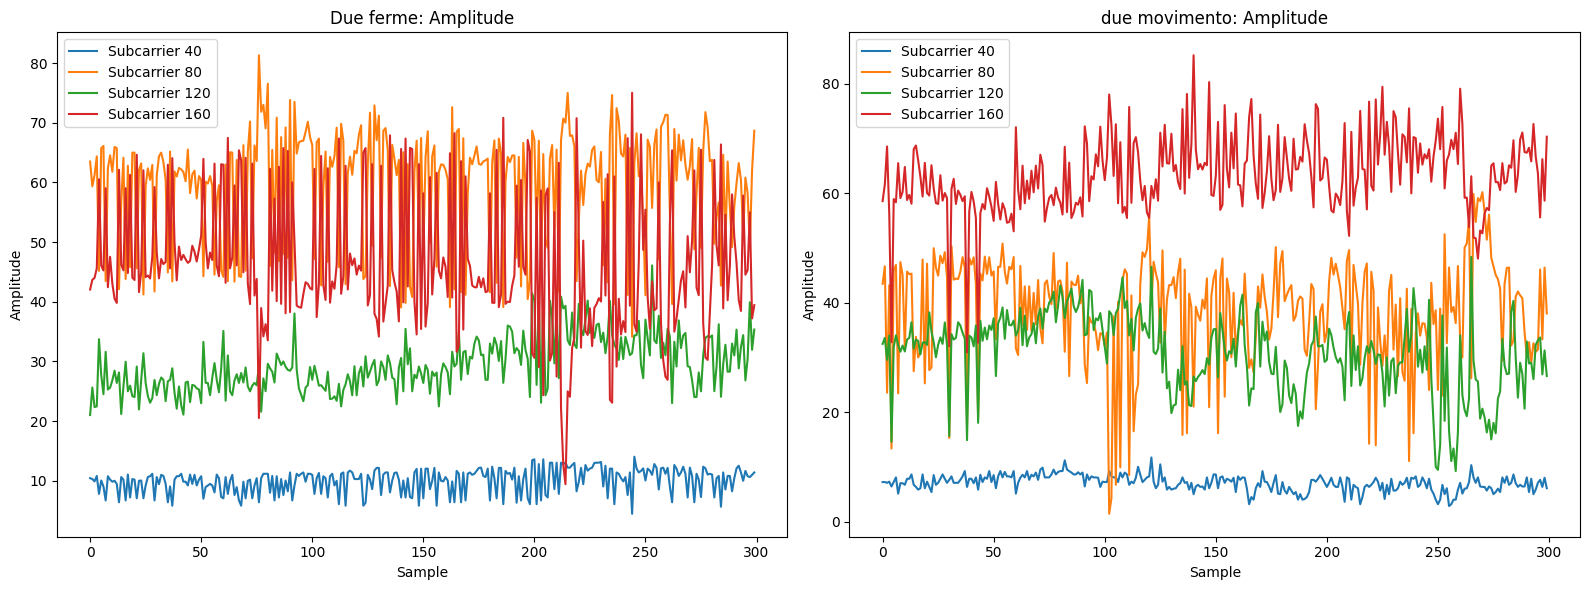

In [172]:
import matplotlib.pyplot as plt
import numpy as np

df_plot1 = due_ferme_rx1_cleaned.head(300)
df_plot2 = due_movimento_rx1_cleaned.head(300)

col_names1 = list(df_plot1.columns)
col_names2 = list(df_plot2.columns)
subcarriers = [ 40, 80, 120, 160]

plt.figure(figsize=(16, 6))

# Primo plot, a sinistra
plt.subplot(1, 2, 1)
for sc in subcarriers:
    if str(sc) in col_names1:
        vals = df_plot1[str(sc)].values
    elif sc in col_names1:
        vals = df_plot1[sc].values
    else:
        print(f"Subcarrier {sc} non trovato nel dataset 1!")
        continue
    amp = np.abs(vals)
    plt.plot(amp, label=f'Subcarrier {sc}')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Due ferme: Amplitude')
plt.legend()

# Secondo plot, a destra
plt.subplot(1, 2, 2)
for sc in subcarriers:
    if str(sc) in col_names2:
        vals = df_plot2[str(sc)].values
    elif sc in col_names2:
        vals = df_plot2[sc].values
    else:
        print(f"Subcarrier {sc} non trovato nel dataset 2!")
        continue
    amp = np.abs(vals)
    plt.plot(amp, label=f'Subcarrier {sc}')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('due movimento: Amplitude')
plt.legend()

plt.tight_layout()
plt.show()


In [174]:
assenza_rx1_filtered

host_time_ms                mac    0    1    2    3    4  \
0      2025-09-09 11:37:37.587  34:85:18:a1:3f:08  0.0  0.0  0.0  0.0  0.0   
1      2025-09-09 11:37:37.603  34:85:18:a1:40:f0  0.0  0.0  0.0  0.0  0.0   
2      2025-09-09 11:37:37.620  34:85:18:a1:3f:08  0.0  0.0  0.0  0.0  0.0   
3      2025-09-09 11:37:37.636  34:85:18:a1:40:f0  0.0  0.0  0.0  0.0  0.0   
4      2025-09-09 11:37:37.652  34:85:18:a1:3f:08  0.0  0.0  0.0  0.0  0.0   
...                        ...                ...  ...  ...  ...  ...  ...   
58254  2025-09-09 11:52:47.188  34:85:18:a1:3f:08  0.0  0.0  0.0  0.0  0.0   
58255  2025-09-09 11:52:47.204  34:85:18:a1:3f:08  0.0  0.0  0.0  0.0  0.0   
58256  2025-09-09 11:52:47.219  34:85:18:a1:40:f0  0.0  0.0  0.0  0.0  0.0   
58257  2025-09-09 11:52:47.233  34:85:18:a1:3f:08  0.0  0.0  0.0  0.0  0.0   
58258  2025-09-09 11:52:47.249  34:85:18:a1:40:f0  0.0  0.0  0.0  0.0  0.0   

         5          6          7  ...        182        183        184  \
0      0.0  13.341664  12.165525  ...  63.000000  67.186308  65.122961   
1      0.0   7.810250   8.602325  ...  63.890531  67.178866  63.126856   
2      0.0  12.529964  12.529964  ...  65.795137  71.840100  70.292247   
3      0.0   8.062258   7.810250  ...  68.264193  63.285069  59.363288   
4      0.0  12.041595  12.041595  ...  72.235725  69.570109  68.308125   
...    ...        ...        ...  ...        ...        ...        ...   
58254  0.0  11.401754  10.816654  ...  68.014704  68.622154  61.717096   
58255  0.0  10.630146  10.630146  ...  64.899923  64.660653  65.000000   
58256  0.0   8.246211   8.246211  ...  65.115282  59.539903  61.000000   
58257  0.0   9.899495   9.899495  ...  63.780875  66.483081  63.702433   
58258  0.0   7.615773   7.280110  ...  61.684682  58.821765  60.728906   

             185        186        187        188        189        190  191  
0      71.112587  72.835431  67.896981  71.344236  71.805292  69.426220  0.0  
1      65.192024  62.936476  59.396970  61.717096  58.694122  58.051701  0.0  
2      67.475922  70.724819  68.600292  70.491134  76.321688  66.887966  0.0  
3      68.007353  64.660653  56.302753  65.192024  63.812225  57.982756  0.0  
4      70.228199  73.979727  69.634761  72.180330  75.663730  72.443081  0.0  
...          ...        ...        ...        ...        ...        ...  ...  
58254  68.014704  68.680419  66.068147  63.702433  70.936591  68.600292  0.0  
58255  69.634761  68.883960  67.268120  66.528190  69.310894  63.600314  0.0  
58256  62.369865  63.150614  53.851648  56.044625  55.659680  50.803543  0.0  
58257  68.117545  63.890531  64.443774  63.780875  67.208630  65.436993  0.0  
58258  64.195015  57.775427  46.173586  58.872744  57.870545  53.366656  0.0  

[58259 rows x 194 columns]

# fine grafici

In [17]:
lltf_assenza_rx1, htltf_assenza_rx1 = split_csi_dataset(assenza_rx1_cleaned)
lltf_assenza_rx2, htltf_assenza_rx2 = split_csi_dataset(assenza_rx2_cleaned)

lltf_una_movimento_rx1, htltf_una_movimento_rx1 = split_csi_dataset(una_movimento_rx1_cleaned)
lltf_una_movimento_rx2, htltf_una_movimento_rx2 = split_csi_dataset(una_movimento_rx2_cleaned)

lltf_una_ferma_rx1, htltf_una_ferma_rx1 = split_csi_dataset(una_ferma_rx1_cleaned)
lltf_una_ferma_rx2, htltf_una_ferma_rx2 = split_csi_dataset(una_ferma_rx2_cleaned)

lltf_due_movimento_rx1, htltf_due_movimento_rx1 = split_csi_dataset(due_movimento_rx1_cleaned)
lltf_due_movimento_rx2, htltf_due_movimento_rx2 = split_csi_dataset(due_movimento_rx2_cleaned)

lltf_due_ferme_rx1, htltf_due_ferme_rx1 = split_csi_dataset(due_ferme_rx1_cleaned)
lltf_due_ferme_rx2, htltf_due_ferme_rx2 = split_csi_dataset(due_ferme_rx2_cleaned)

lltf_tre_ferme_rx1, htltf_tre_ferme_rx1 = split_csi_dataset(tre_ferme_rx1_cleaned)
lltf_tre_ferme_rx2, htltf_tre_ferme_rx2 = split_csi_dataset(tre_ferme_rx2_cleaned)


C:\Users\mariu\AppData\Local\Temp\ipykernel_16756\1148539549.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  vals = data_df[data_cols].applymap(
C:\Users\mariu\AppData\Local\Temp\ipykernel_16756\1148539549.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  vals = data_df[data_cols].applymap(
C:\Users\mariu\AppData\Local\Temp\ipykernel_16756\1148539549.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  vals = data_df[data_cols].applymap(
C:\Users\mariu\AppData\Local\Temp\ipykernel_16756\1148539549.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  vals = data_df[data_cols].applymap(
C:\Users\mariu\AppData\Local\Temp\ipykernel_16756\1148539549.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  vals = data_df[data_cols].applymap(
C:\Users\mariu\AppData\Local\Temp\ipykernel_16756\1148539549

In [18]:
#levo le sottoportanti pilota  -53, -25, -11, +11, +25, +53, queste sono indicate nel documento esp 
def remove_pilot_subcarriers(df):
    pilot_indices = [-53, -25, -11, 11, 25, 53]
    cols_to_remove = [col for col in pilot_indices if col in df.columns]
    df_cleaned = df.drop(columns=cols_to_remove)
    return df_cleaned

htltf_assenza_rx1 = remove_pilot_subcarriers(htltf_assenza_rx1)
htltf_assenza_rx2 = remove_pilot_subcarriers(htltf_assenza_rx2)

htltf_due_movimento_rx1 = remove_pilot_subcarriers(htltf_due_movimento_rx1)
htltf_due_movimento_rx2 = remove_pilot_subcarriers(htltf_due_movimento_rx2)

htltf_due_ferme_rx1 = remove_pilot_subcarriers(htltf_due_ferme_rx1)
htltf_due_ferme_rx2 = remove_pilot_subcarriers(htltf_due_ferme_rx2)

htltf_una_movimento_rx1 = remove_pilot_subcarriers(htltf_una_movimento_rx1)
htltf_una_movimento_rx2 = remove_pilot_subcarriers(htltf_una_movimento_rx2)

htltf_una_ferma_rx1 = remove_pilot_subcarriers(htltf_una_ferma_rx1)
htltf_una_ferma_rx2 = remove_pilot_subcarriers(htltf_una_ferma_rx2)

htltf_tre_ferme_rx1 = remove_pilot_subcarriers(htltf_tre_ferme_rx1)
htltf_tre_ferme_rx2 = remove_pilot_subcarriers(htltf_tre_ferme_rx2)


In [19]:
#recupero gli indici delle sottoportanti 
subcarriers_htltf = [col for col in htltf_assenza_rx1.columns if col not in ['host_time_ms','rx','mac']]

subcarriers_lltf=[col for col in lltf_assenza_rx1.columns if col not in ['host_time_ms','rx','mac']]

#calcolo quante sono 
num_subcarriers_htltf = len(subcarriers_htltf)

num_subcarriers_lltf = len(subcarriers_lltf)    

In [20]:
def drop_time_window(df, time_col='local_timestamp', seconds=60, mode='head'):
    """
    Rimuove dal DataFrame tutte le righe dei primi o ultimi `seconds` secondi,
    sulla base della colonna temporale `time_col`.
    - mode='head' rimuove i primi N secondi
    - mode='tail' rimuove gli ultimi N secondi
    """
    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col])
    if mode == 'head':
        t0 = df[time_col].min()
        mask = df[time_col] >= (t0 + pd.Timedelta(seconds=seconds))
    elif mode == 'tail':
        t_end = df[time_col].max()
        mask = df[time_col] <= (t_end - pd.Timedelta(seconds=seconds))
    else:
        raise ValueError("mode deve essere 'head' oppure 'tail'")
    return df[mask].reset_index(drop=True)

In [21]:
# in questa sezione tolgo i primi e gli ultimi secondi di ogni acquisizione per eliminare i momenti in cui le persone non fanno il training
# QUESTO PER LE LLTF
lltf_assenza_rx1 = drop_time_window(lltf_assenza_rx1, time_col='host_time_ms', seconds=180, mode='head')
lltf_assenza_rx2 = drop_time_window(lltf_assenza_rx2, time_col='host_time_ms', seconds=180, mode='head')

lltf_due_movimento_rx1 = drop_time_window(lltf_due_movimento_rx1, time_col='host_time_ms', seconds=30, mode='head') 
lltf_due_movimento_rx2 = drop_time_window(lltf_due_movimento_rx2, time_col='host_time_ms', seconds=30, mode='head')

lltf_due_ferme_rx1 = drop_time_window(lltf_due_ferme_rx1, time_col='host_time_ms', seconds=60, mode='head')
lltf_due_ferme_rx2 = drop_time_window(lltf_due_ferme_rx2, time_col='host_time_ms', seconds=60, mode='head')

lltf_una_movimento_rx1 = drop_time_window(lltf_una_movimento_rx1, time_col='host_time_ms', seconds=30, mode='head')
lltf_una_movimento_rx2 = drop_time_window(lltf_una_movimento_rx2, time_col='host_time_ms', seconds=30, mode='head')

lltf_una_ferma_rx1 = drop_time_window(lltf_una_ferma_rx1, time_col='host_time_ms', seconds=60, mode='head')
lltf_una_ferma_rx2 = drop_time_window(lltf_una_ferma_rx2, time_col='host_time_ms', seconds=60, mode='head')

lltf_tre_ferme_rx1 = drop_time_window(lltf_tre_ferme_rx1, time_col='host_time_ms', seconds=120, mode='head')
lltf_tre_ferme_rx2 = drop_time_window(lltf_tre_ferme_rx2, time_col='host_time_ms', seconds=120, mode='head')

lltf_assenza_rx1 = drop_time_window(lltf_assenza_rx1, time_col='host_time_ms', seconds=120, mode='tail')
lltf_assenza_rx2 = drop_time_window(lltf_assenza_rx2, time_col='host_time_ms', seconds=120, mode='tail')

lltf_due_movimento_rx1 = drop_time_window(lltf_due_movimento_rx1, time_col='host_time_ms', seconds=30, mode='tail') 
lltf_due_movimento_rx2 = drop_time_window(lltf_due_movimento_rx2, time_col='host_time_ms', seconds=30, mode='tail')

lltf_due_ferme_rx1 = drop_time_window(lltf_due_ferme_rx1, time_col='host_time_ms', seconds=60, mode='tail')
lltf_due_ferme_rx2 = drop_time_window(lltf_due_ferme_rx2, time_col='host_time_ms', seconds=60, mode='tail')

lltf_una_movimento_rx1 = drop_time_window(lltf_una_movimento_rx1, time_col='host_time_ms', seconds=30, mode='tail')
lltf_una_movimento_rx2 = drop_time_window(lltf_una_movimento_rx2, time_col='host_time_ms', seconds=30, mode='tail')

lltf_una_ferma_rx1 = drop_time_window(lltf_una_ferma_rx1, time_col='host_time_ms', seconds=60, mode='tail')
lltf_una_ferma_rx2 = drop_time_window(lltf_una_ferma_rx2, time_col='host_time_ms', seconds=60, mode='tail')

lltf_tre_ferme_rx1 = drop_time_window(lltf_tre_ferme_rx1, time_col='host_time_ms', seconds=60, mode='tail')
lltf_tre_ferme_rx2 = drop_time_window(lltf_tre_ferme_rx2, time_col='host_time_ms', seconds=60, mode='tail')

In [22]:
# in questa sezione tolgo i primi e gli ultimi secondi di ogni acquisizione per eliminare i momenti in cui le persone non fanno il training
# QUESTO PER LE HTLTF

htltf_assenza_rx1 = drop_time_window(htltf_assenza_rx1, time_col='host_time_ms', seconds=120, mode='head')
htltf_assenza_rx2 = drop_time_window(htltf_assenza_rx2, time_col='host_time_ms', seconds=120, mode='head')

htltf_due_movimento_rx1 = drop_time_window(htltf_due_movimento_rx1, time_col='host_time_ms', seconds=30, mode='head') 
htltf_due_movimento_rx2 = drop_time_window(htltf_due_movimento_rx2, time_col='host_time_ms', seconds=30, mode='head')

htltf_due_ferme_rx1 = drop_time_window(htltf_due_ferme_rx1, time_col='host_time_ms', seconds=60, mode='head')
htltf_due_ferme_rx2 = drop_time_window(htltf_due_ferme_rx2, time_col='host_time_ms', seconds=60, mode='head')

htltf_una_movimento_rx1 = drop_time_window(htltf_una_movimento_rx1, time_col='host_time_ms', seconds=30, mode='head')
htltf_una_movimento_rx2 = drop_time_window(htltf_una_movimento_rx2, time_col='host_time_ms', seconds=30, mode='head')

htltf_una_ferma_rx1 = drop_time_window(htltf_una_ferma_rx1, time_col='host_time_ms', seconds=60, mode='head')
htltf_una_ferma_rx2 = drop_time_window(htltf_una_ferma_rx2, time_col='host_time_ms', seconds=60, mode='head')

htltf_tre_ferme_rx1 = drop_time_window(htltf_tre_ferme_rx1, time_col='host_time_ms', seconds=120, mode='head')
htltf_tre_ferme_rx2 = drop_time_window(htltf_tre_ferme_rx2, time_col='host_time_ms', seconds=120, mode='head')

htltf_assenza_rx1 = drop_time_window(htltf_assenza_rx1, time_col='host_time_ms', seconds=120, mode='tail')
htltf_assenza_rx2 = drop_time_window(htltf_assenza_rx2, time_col='host_time_ms', seconds=120, mode='tail')

htltf_due_movimento_rx1 = drop_time_window(htltf_due_movimento_rx1, time_col='host_time_ms', seconds=30, mode='tail') 
htltf_due_movimento_rx2 = drop_time_window(htltf_due_movimento_rx2, time_col='host_time_ms', seconds=30, mode='tail')

htltf_due_ferme_rx1 = drop_time_window(htltf_due_ferme_rx1, time_col='host_time_ms', seconds=60, mode='tail')
htltf_due_ferme_rx2 = drop_time_window(htltf_due_ferme_rx2, time_col='host_time_ms', seconds=60, mode='tail')

htltf_una_movimento_rx1 = drop_time_window(htltf_una_movimento_rx1, time_col='host_time_ms', seconds=30, mode='tail')
htltf_una_movimento_rx2 = drop_time_window(htltf_una_movimento_rx2, time_col='host_time_ms', seconds=30, mode='tail')

htltf_una_ferma_rx1 = drop_time_window(htltf_una_ferma_rx1, time_col='host_time_ms', seconds=60, mode='tail')
htltf_una_ferma_rx2 = drop_time_window(htltf_una_ferma_rx2, time_col='host_time_ms', seconds=60, mode='tail')

htltf_tre_fermerx1 = drop_time_window(htltf_tre_ferme_rx1, time_col='host_time_ms', seconds=60, mode='tail')
htltf_tre_ferme_rx2 = drop_time_window(htltf_tre_ferme_rx2, time_col='host_time_ms', seconds=60, mode='tail')

In [23]:
def apply_abs_to_subcarriers(df, subcarrier_cols):
    """
    Restituisce una copia del DataFrame con il modulo applicato solo alle colonne dei subcarrier.
    Non tocca eventuali colonne identificative (es: 'mac', timestamp, ecc).
    """
    df_mod = df.copy()
    df_mod[subcarrier_cols] = df_mod[subcarrier_cols].applymap(np.abs)
    return df_mod

In [24]:
modulo_assenza_lltf_rx1 = apply_abs_to_subcarriers(lltf_assenza_rx1, subcarriers_lltf)
modulo_assenza_lltf_rx2 = apply_abs_to_subcarriers(lltf_assenza_rx2, subcarriers_lltf)

modulo_due_movimento_lltf_rx1 = apply_abs_to_subcarriers(lltf_due_movimento_rx1, subcarriers_lltf)
modulo_due_movimento_lltf_rx2 = apply_abs_to_subcarriers(lltf_due_movimento_rx2, subcarriers_lltf)

modulo_due_ferme_lltf_rx1 = apply_abs_to_subcarriers(lltf_due_ferme_rx1, subcarriers_lltf)
modulo_due_ferme_lltf_rx2 = apply_abs_to_subcarriers(lltf_due_ferme_rx2, subcarriers_lltf)

modulo_una_movimento_lltf_rx1 = apply_abs_to_subcarriers(lltf_una_movimento_rx1, subcarriers_lltf)
modulo_una_movimento_lltf_rx2 = apply_abs_to_subcarriers(lltf_una_movimento_rx2, subcarriers_lltf)

modulo_una_ferma_lltf_rx1 = apply_abs_to_subcarriers(lltf_una_ferma_rx1, subcarriers_lltf)
modulo_una_ferma_lltf_rx2 = apply_abs_to_subcarriers(lltf_una_ferma_rx2, subcarriers_lltf)

modulo_tre_ferme_lltf_rx1 = apply_abs_to_subcarriers(lltf_tre_ferme_rx1, subcarriers_lltf)
modulo_tre_ferme_lltf_rx2 = apply_abs_to_subcarriers(lltf_tre_ferme_rx2, subcarriers_lltf)

C:\Users\mariu\AppData\Local\Temp\ipykernel_16756\4186253929.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_mod[subcarrier_cols] = df_mod[subcarrier_cols].applymap(np.abs)
C:\Users\mariu\AppData\Local\Temp\ipykernel_16756\4186253929.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_mod[subcarrier_cols] = df_mod[subcarrier_cols].applymap(np.abs)
C:\Users\mariu\AppData\Local\Temp\ipykernel_16756\4186253929.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_mod[subcarrier_cols] = df_mod[subcarrier_cols].applymap(np.abs)
C:\Users\mariu\AppData\Local\Temp\ipykernel_16756\4186253929.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_mod[subcarrier_cols] = df_mod[subcarrier_cols].applymap(np.abs)
C:\Users\mariu\AppData\Local\Temp\ipykernel_16756\4186253929.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use Da

In [25]:
modulo_assenza_htltf_rx1 = apply_abs_to_subcarriers(htltf_assenza_rx1, subcarriers_htltf)
modulo_assenza_htltf_rx2 = apply_abs_to_subcarriers(htltf_assenza_rx2, subcarriers_htltf)

modulo_due_movimento_htltf_rx1 = apply_abs_to_subcarriers(htltf_due_movimento_rx1, subcarriers_htltf)
modulo_due_movimento_htltf_rx2 = apply_abs_to_subcarriers(htltf_due_movimento_rx2, subcarriers_htltf)

modulo_due_ferme_htltf_rx1 = apply_abs_to_subcarriers(htltf_due_ferme_rx1, subcarriers_htltf)
modulo_due_ferme_htltf_rx2 = apply_abs_to_subcarriers(htltf_due_ferme_rx2, subcarriers_htltf)

modulo_una_movimento_htltf_rx1 = apply_abs_to_subcarriers(htltf_una_movimento_rx1, subcarriers_htltf)
modulo_una_movimento_htltf_rx2 = apply_abs_to_subcarriers(htltf_una_movimento_rx2, subcarriers_htltf)

modulo_una_ferma_htltf_rx1 = apply_abs_to_subcarriers(htltf_una_ferma_rx1, subcarriers_htltf)
modulo_una_ferma_htltf_rx2 = apply_abs_to_subcarriers(htltf_una_ferma_rx2, subcarriers_htltf)

modulo_tre_ferme_htltf_rx1 = apply_abs_to_subcarriers(htltf_tre_ferme_rx1, subcarriers_htltf)
modulo_tre_ferme_htltf_rx2 = apply_abs_to_subcarriers(htltf_tre_ferme_rx2, subcarriers_htltf)


C:\Users\mariu\AppData\Local\Temp\ipykernel_16756\4186253929.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_mod[subcarrier_cols] = df_mod[subcarrier_cols].applymap(np.abs)
C:\Users\mariu\AppData\Local\Temp\ipykernel_16756\4186253929.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_mod[subcarrier_cols] = df_mod[subcarrier_cols].applymap(np.abs)
C:\Users\mariu\AppData\Local\Temp\ipykernel_16756\4186253929.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_mod[subcarrier_cols] = df_mod[subcarrier_cols].applymap(np.abs)
C:\Users\mariu\AppData\Local\Temp\ipykernel_16756\4186253929.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_mod[subcarrier_cols] = df_mod[subcarrier_cols].applymap(np.abs)
C:\Users\mariu\AppData\Local\Temp\ipykernel_16756\4186253929.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use Da

In [26]:
#aggiungo la colonna rx che si chiama rx1 o rx2 per tenere traccia del ricevitore
modulo_assenza_lltf_rx1['rx'] = 'rx1'
modulo_assenza_lltf_rx2['rx'] = 'rx2'
modulo_due_movimento_lltf_rx1['rx'] = 'rx1'
modulo_due_movimento_lltf_rx2['rx'] = 'rx2'
modulo_due_ferme_lltf_rx1['rx'] = 'rx1'
modulo_due_ferme_lltf_rx2['rx'] = 'rx2'
modulo_una_movimento_lltf_rx1['rx'] = 'rx1'
modulo_una_movimento_lltf_rx2['rx'] = 'rx2'
modulo_una_ferma_lltf_rx1['rx'] = 'rx1'
modulo_una_ferma_lltf_rx2['rx'] = 'rx2'
modulo_tre_ferme_lltf_rx1['rx'] = 'rx1'
modulo_tre_ferme_lltf_rx2['rx'] = 'rx2'    

modulo_assenza_htltf_rx1['rx'] = 'rx1'
modulo_assenza_htltf_rx2['rx'] = 'rx2'
modulo_due_movimento_htltf_rx1['rx'] = 'rx1'
modulo_due_movimento_htltf_rx2['rx'] = 'rx2'
modulo_due_ferme_htltf_rx1['rx'] = 'rx1'
modulo_due_ferme_htltf_rx2['rx'] = 'rx2'
modulo_una_movimento_htltf_rx1['rx'] = 'rx1'
modulo_una_movimento_htltf_rx2['rx'] = 'rx2'
modulo_una_ferma_htltf_rx1['rx'] = 'rx1'
modulo_una_ferma_htltf_rx2['rx'] = 'rx2'
modulo_tre_ferme_htltf_rx1['rx'] = 'rx1'
modulo_tre_ferme_htltf_rx2['rx'] = 'rx2'

C:\Users\mariu\AppData\Local\Temp\ipykernel_16756\606605056.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  modulo_assenza_htltf_rx1['rx'] = 'rx1'
C:\Users\mariu\AppData\Local\Temp\ipykernel_16756\606605056.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  modulo_assenza_htltf_rx2['rx'] = 'rx2'
C:\Users\mariu\AppData\Local\Temp\ipykernel_16756\606605056.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

In [27]:
def segment_csi_data_multilink(
    df, 
    time_col='host_time_ms', 
    subcarrier_cols=None, 
    window_sec=6, 
    overlap_sec=3,
    mac_col='mac',
    rx_col='rx'
):
    """
    Segmenta i dati CSI in finestre temporali sovrapposte, separatamente per ogni link (mac, rx_mac).
    - df: DataFrame con almeno timestamp, mac, (rx_mac opz.), subcarrier_cols.
    - time_col: nome colonna timestamp.
    - subcarrier_cols: lista colonne sottoportanti (se None, autodetect numeriche).
    - mac_col: nome colonna mac address trasmettitore.
    - rx_mac_col: nome colonna mac address ricevitore (opzionale, se None non si usa).
    - window_sec: durata finestra (sec).
    - overlap_sec: overlap tra finestre (sec).
    Ritorna: dict { (mac, rx_mac): [bundle, ...] }
    """
    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col])
    if subcarrier_cols is None:
        # Prendi solo colonne numeriche che non siano timestamp/mac
        exclude = [time_col, mac_col]
        if rx_col: 
            exclude.append(rx_col)
        subcarrier_cols = [col for col in df.columns if np.issubdtype(df[col].dtype, np.number) and col not in exclude]
    
    # Raggruppa per link
    if rx_col:
        group_cols = [mac_col, rx_col]
    else:
        group_cols = [mac_col]
    
    bundles_dict = {}
    grouped = df.groupby(group_cols)
    for link_id, group in grouped:
        group = group.sort_values(time_col).reset_index(drop=True)
        times = group[time_col].values.astype('datetime64[s]')
        if len(times) == 0:
            continue
        start_time = times[0]
        end_time = times[-1]
        window = np.timedelta64(window_sec, 's')
        step = np.timedelta64(window_sec - overlap_sec, 's')
        bundles = []
        current_start = start_time
        while current_start + window <= end_time:
            current_end = current_start + window
            mask = (times >= current_start) & (times < current_end)
            bundle = group.loc[mask, subcarrier_cols].values
            if len(bundle) > 0:
                bundles.append(bundle)
            current_start += step
        bundles_dict[link_id] = bundles
    return bundles_dict

In [28]:
import time

start_bundles_htltf = time.perf_counter()

bundles_assenza_htltf_rx1  = segment_csi_data_multilink(modulo_assenza_htltf_rx1, time_col='host_time_ms', subcarrier_cols=subcarriers_htltf, window_sec=6, overlap_sec=3)
bundles_assenza_htltf_rx2  = segment_csi_data_multilink(modulo_assenza_htltf_rx2, time_col='host_time_ms', subcarrier_cols=subcarriers_htltf, window_sec=6, overlap_sec=3)

end_bundles_htltf = time.perf_counter()
tempo_totale_bundles_htltf = end_bundles_htltf - start_bundles_htltf
print(f"Tempo totale: {tempo_totale_bundles_htltf:.3f} secondi")

bundles_due_movimento_htltf_rx1  = segment_csi_data_multilink(modulo_due_movimento_htltf_rx1, time_col='host_time_ms', subcarrier_cols=subcarriers_htltf, window_sec=6, overlap_sec=3)
bundles_due_movimento_htltf_rx2  = segment_csi_data_multilink(modulo_due_movimento_htltf_rx2, time_col='host_time_ms', subcarrier_cols=subcarriers_htltf, window_sec=6, overlap_sec=3)

bundles_due_ferme_htltf_rx1  = segment_csi_data_multilink(modulo_due_ferme_htltf_rx1, time_col='host_time_ms', subcarrier_cols=subcarriers_htltf, window_sec=6, overlap_sec=3)
bundles_due_ferme_htltf_rx2  = segment_csi_data_multilink(modulo_due_ferme_htltf_rx2, time_col='host_time_ms', subcarrier_cols=subcarriers_htltf, window_sec=6, overlap_sec=3)

bundles_una_movimento_htltf_rx1  = segment_csi_data_multilink(modulo_una_movimento_htltf_rx1, time_col='host_time_ms', subcarrier_cols=subcarriers_htltf, window_sec=6, overlap_sec=3)
bundles_una_movimento_htltf_rx2  = segment_csi_data_multilink(modulo_una_movimento_htltf_rx2, time_col='host_time_ms', subcarrier_cols=subcarriers_htltf, window_sec=6, overlap_sec=3)

bundles_una_ferma_htltf_rx1  = segment_csi_data_multilink(modulo_una_ferma_htltf_rx1, time_col='host_time_ms', subcarrier_cols=subcarriers_htltf, window_sec=6, overlap_sec=3)
bundles_una_ferma_htltf_rx2  = segment_csi_data_multilink(modulo_una_ferma_htltf_rx2, time_col='host_time_ms', subcarrier_cols=subcarriers_htltf, window_sec=6, overlap_sec=3)

bundles_tre_ferme_htltf_rx1  = segment_csi_data_multilink(modulo_tre_ferme_htltf_rx1, time_col='host_time_ms', subcarrier_cols=subcarriers_htltf, window_sec=6, overlap_sec=3)
bundles_tre_ferme_htltf_rx2  = segment_csi_data_multilink(modulo_tre_ferme_htltf_rx2, time_col='host_time_ms', subcarrier_cols=subcarriers_htltf, window_sec=6, overlap_sec=3)

start_bundles_lltf = time.perf_counter()
bundles_assenza_lltf_rx1  = segment_csi_data_multilink(modulo_assenza_lltf_rx1, time_col='host_time_ms', subcarrier_cols=subcarriers_lltf, window_sec=6, overlap_sec=3)
bundles_assenza_lltf_rx2  = segment_csi_data_multilink(modulo_assenza_lltf_rx2, time_col='host_time_ms', subcarrier_cols=subcarriers_lltf, window_sec=6, overlap_sec=3)

end_bundles_lltf = time.perf_counter()
tempo_totale_bundles_lltf = end_bundles_lltf - start_bundles_lltf
print(f"Tempo totale: {tempo_totale_bundles_lltf:.3f} secondi")

bundles_due_movimento_lltf_rx1  = segment_csi_data_multilink(modulo_due_movimento_lltf_rx1, time_col='host_time_ms', subcarrier_cols=subcarriers_lltf, window_sec=6, overlap_sec=3)
bundles_due_movimento_lltf_rx2  = segment_csi_data_multilink(modulo_due_movimento_lltf_rx2, time_col='host_time_ms', subcarrier_cols=subcarriers_lltf, window_sec=6, overlap_sec=3)

bundles_due_ferme_lltf_rx1  = segment_csi_data_multilink(modulo_due_ferme_lltf_rx1, time_col='host_time_ms', subcarrier_cols=subcarriers_lltf, window_sec=6, overlap_sec=3)
bundles_due_ferme_lltf_rx2  = segment_csi_data_multilink(modulo_due_ferme_lltf_rx2, time_col='host_time_ms', subcarrier_cols=subcarriers_lltf, window_sec=6, overlap_sec=3)

bundles_una_movimento_lltf_rx1  = segment_csi_data_multilink(modulo_una_movimento_lltf_rx1, time_col='host_time_ms', subcarrier_cols=subcarriers_lltf, window_sec=6, overlap_sec=3)
bundles_una_movimento_lltf_rx2  = segment_csi_data_multilink(modulo_una_movimento_lltf_rx2, time_col='host_time_ms', subcarrier_cols=subcarriers_lltf, window_sec=6, overlap_sec=3)

bundles_una_ferma_lltf_rx1  = segment_csi_data_multilink(modulo_una_ferma_lltf_rx1, time_col='host_time_ms', subcarrier_cols=subcarriers_lltf, window_sec=6, overlap_sec=3)
bundles_una_ferma_lltf_rx2  = segment_csi_data_multilink(modulo_una_ferma_lltf_rx2, time_col='host_time_ms', subcarrier_cols=subcarriers_lltf, window_sec=6, overlap_sec=3)   

bundles_tre_ferme_lltf_rx1  = segment_csi_data_multilink(modulo_tre_ferme_lltf_rx1, time_col='host_time_ms', subcarrier_cols=subcarriers_lltf, window_sec=6, overlap_sec=3)
bundles_tre_ferme_lltf_rx2  = segment_csi_data_multilink(modulo_tre_ferme_lltf_rx2, time_col='host_time_ms', subcarrier_cols=subcarriers_lltf, window_sec=6, overlap_sec=3)    


Tempo totale: 12.478 secondi
Tempo totale: 5.673 secondi


In [29]:
def split_bundles(bundles_rx1, bundles_rx2, mac1="34:85:18:a1:3f:08", mac2="34:85:18:a1:40:f0"):
    """
    Estrae direttamente i 4 dataset dai bundles, separando i link per RX1 e RX2.

    Parametri
    ---------
    bundles_rx1 : dict
        Dizionario dei bundle con chiavi tipo (mac, 'rx1')
    bundles_rx2 : dict
        Dizionario dei bundle con chiavi tipo (mac, 'rx2')
    mac1 : str
        MAC address del primo TX (default quello che hai usato)
    mac2 : str
        MAC address del secondo TX

    Ritorna
    -------
    tuple : (rx1_link1, rx1_link2, rx2_link1, rx2_link2)
    """
    rx1_link1 = bundles_rx1[(mac1, "rx1")]
    rx1_link2 = bundles_rx1[(mac2, "rx1")]
    rx2_link1 = bundles_rx2[(mac1, "rx2")]
    rx2_link2 = bundles_rx2[(mac2, "rx2")]

    return rx1_link1, rx1_link2, rx2_link1, rx2_link2


In [30]:
bundles_assenza_htltf_rx1_link1, \
bundles_assenza_htltf_rx1_link2, \
bundles_assenza_htltf_rx2_link1, \
bundles_assenza_htltf_rx2_link2 = split_bundles(
    bundles_assenza_htltf_rx1, bundles_assenza_htltf_rx2
)

bundles_due_movimento_htltf_rx1_link1, \
bundles_due_movimento_htltf_rx1_link2, \
bundles_due_movimento_htltf_rx2_link1, \
bundles_due_movimento_htltf_rx2_link2 = split_bundles(
    bundles_due_movimento_htltf_rx1, bundles_due_movimento_htltf_rx2
)

bundles_due_ferme_htltf_rx1_link1, \
bundles_due_ferme_htltf_rx1_link2, \
bundles_due_ferme_htltf_rx2_link1, \
bundles_due_ferme_htltf_rx2_link2 = split_bundles(
    bundles_due_ferme_htltf_rx1, bundles_due_ferme_htltf_rx2
)

bundles_una_movimento_htltf_rx1_link1, \
bundles_una_movimento_htltf_rx1_link2, \
bundles_una_movimento_htltf_rx2_link1, \
bundles_una_movimento_htltf_rx2_link2 = split_bundles(
    bundles_una_movimento_htltf_rx1, bundles_una_movimento_htltf_rx2
)
bundles_una_ferma_htltf_rx1_link1, \
bundles_una_ferma_htltf_rx1_link2, \
bundles_una_ferma_htltf_rx2_link1, \
bundles_una_ferma_htltf_rx2_link2 = split_bundles(
    bundles_una_ferma_htltf_rx1, bundles_una_ferma_htltf_rx2
)

bundles_tre_ferme_htltf_rx1_link1, \
bundles_tre_ferme_htltf_rx1_link2, \
bundles_tre_ferme_htltf_rx2_link1, \
bundles_tre_ferme_htltf_rx2_link2 = split_bundles(
    bundles_tre_ferme_htltf_rx1, bundles_tre_ferme_htltf_rx2
)

In [31]:
bundles_assenza_lltf_rx1_link1, \
bundles_assenza_lltf_rx1_link2, \
bundles_assenza_lltf_rx2_link1, \
bundles_assenza_lltf_rx2_link2 = split_bundles(
    bundles_assenza_lltf_rx1, bundles_assenza_lltf_rx2
)

bundles_due_movimento_lltf_rx1_link1, \
bundles_due_movimento_lltf_rx1_link2, \
bundles_due_movimento_lltf_rx2_link1, \
bundles_due_movimento_lltf_rx2_link2 = split_bundles(
    bundles_due_movimento_lltf_rx1, bundles_due_movimento_lltf_rx2
)

bundles_due_ferme_lltf_rx1_link1, \
bundles_due_ferme_lltf_rx1_link2, \
bundles_due_ferme_lltf_rx2_link1, \
bundles_due_ferme_lltf_rx2_link2 = split_bundles(
    bundles_due_ferme_lltf_rx1, bundles_due_ferme_lltf_rx2
)

bundles_una_movimento_lltf_rx1_link1, \
bundles_una_movimento_lltf_rx1_link2, \
bundles_una_movimento_lltf_rx2_link1, \
bundles_una_movimento_lltf_rx2_link2 = split_bundles(
    bundles_una_movimento_lltf_rx1, bundles_una_movimento_lltf_rx2
)
bundles_una_ferma_lltf_rx1_link1, \
bundles_una_ferma_lltf_rx1_link2, \
bundles_una_ferma_lltf_rx2_link1, \
bundles_una_ferma_lltf_rx2_link2 = split_bundles(
    bundles_una_ferma_lltf_rx1, bundles_una_ferma_lltf_rx2
)

bundles_tre_ferme_lltf_rx1_link1, \
bundles_tre_ferme_lltf_rx1_link2, \
bundles_tre_ferme_lltf_rx2_link1, \
bundles_tre_ferme_lltf_rx2_link2 = split_bundles(
    bundles_tre_ferme_lltf_rx1, bundles_tre_ferme_lltf_rx2
)

## Feature extraction

In [32]:
def extract_features_per_subcarrier(csi_matrix):
    """
    csi_matrix: array (N_win, N_subcarriers)
    Output: dict con feature vettoriali (shape (N_win, N_subcarriers))
    """
    feats = {}
    
    feats["std"] = np.std(csi_matrix, axis=0)   # per subcarrier
    feats["min"] = np.min(csi_matrix, axis=0)
    feats["max"] = np.max(csi_matrix, axis=0)
    feats["avg"] = np.mean(csi_matrix, axis=0)
    feats["qtl"] = np.percentile(csi_matrix, 25, axis=0)
    feats["qtu"] = np.percentile(csi_matrix, 75, axis=0)
    feats["iqr"] = feats["qtu"] - feats["qtl"]
    
    return feats


In [33]:
def extract_adj_feature_all_windows(csi_windows, N=2):
    """
    Calcola la feature 'adj' per ciascuna finestra CSI (come nel paper Wi-CaL).
    
    Parametri
    ----------
    csi_windows : list of np.ndarray
        Ogni elemento è una matrice (N_pkt, N_subcarriers)
    N : int
        Numero di sottocarrier adiacenti da considerare su ciascun lato

    Ritorna
    -------
    adj_all : list of np.ndarray
        Lista di vettori (uno per finestra), ciascuno lungo (N_subcarriers - 2*N)
    """
    adj_all = []
    for w, csi_matrix in enumerate(csi_windows):
        n_pkt, n_subc = csi_matrix.shape
        adj_values = []

        for j in range(N, n_subc - N):  # evitiamo i bordi
            xi_j = np.zeros(n_pkt)
            for n in range(1, N + 1):
                xi_j += np.abs(csi_matrix[:, j] - csi_matrix[:, j - n])
                xi_j += np.abs(csi_matrix[:, j] - csi_matrix[:, j + n])
            mu_j = np.mean(xi_j)
            adj_values.append(mu_j)

        adj_all.append(np.array(adj_values))
    return adj_all


In [34]:
def extract_euc_feature_all_windows(csi_windows):
    """
    Calcola la feature 'euc' (Euclidean distance tra pacchetti consecutivi)
    per ciascuna finestra CSI, come da paper Wi-CaL.

    Parametri
    ----------
    csi_windows : list of np.ndarray
        Ogni elemento è una matrice (N_pkt, N_subcarriers)

    Ritorna
    -------
    euc_all : list of float
        Lista di valori 'euc', uno per finestra
    """
    euc_all = []

    for w, csi_matrix in enumerate(csi_windows):
        if csi_matrix.shape[0] < 2:
            euc_all.append(np.nan)  # finestra troppo corta, eviti errore
            continue

        # Differenze tra pacchetti consecutivi
        diffs = np.diff(csi_matrix, axis=0)            # shape (N_pkt-1, N_subcarriers)
        norms = np.linalg.norm(diffs, axis=1)          # distanza euclidea per ogni coppia
        euc_val = np.median(norms)                     # mediana come nel paper

        euc_all.append(euc_val)

    return np.array(euc_all)


In [35]:
#caloclo la feature adj per ogni condizione e per ogni ricevitore_htltf
adj_assenza_htltf_rx1_link1 = extract_adj_feature_all_windows(bundles_assenza_htltf_rx1_link1, N=2)
df_adj_assenza_htltf_rx1_link1 = pd.DataFrame(adj_assenza_htltf_rx1_link1)
assenza_adj_htltf_rx1_link1 = df_adj_assenza_htltf_rx1_link1.values.tolist()

adj_assenza_htltf_rx2_link1 = extract_adj_feature_all_windows(bundles_assenza_htltf_rx2_link1, N=2)
df_adj_assenza_htltf_rx2_link1 = pd.DataFrame(adj_assenza_htltf_rx2_link1)
assenza_adj_htltf_rx2_link1 = df_adj_assenza_htltf_rx2_link1.values.tolist()

adj_assenza_htltf_rx1_link2 = extract_adj_feature_all_windows(bundles_assenza_htltf_rx1_link2, N=2)
df_adj_assenza_htltf_rx1_link2 = pd.DataFrame(adj_assenza_htltf_rx1_link2)
assenza_adj_htltf_rx1_link2 = df_adj_assenza_htltf_rx1_link2.values.tolist()

adj_assenza_htltf_rx2_link2 = extract_adj_feature_all_windows(bundles_assenza_htltf_rx2_link2, N=2)
df_adj_assenza_htltf_rx2_link2 = pd.DataFrame(adj_assenza_htltf_rx2_link2)
assenza_adj_htltf_rx2_link2 = df_adj_assenza_htltf_rx2_link2.values.tolist()

adj_una_ferma_htltf_rx1_link1 = extract_adj_feature_all_windows(bundles_una_ferma_htltf_rx1_link1, N=2)
df_adj_una_ferma_htltf_rx1_link1 = pd.DataFrame(adj_una_ferma_htltf_rx1_link1)
una_ferma_adj_htltf_rx1_link1 = df_adj_una_ferma_htltf_rx1_link1.values.tolist()

adj_una_ferma_htltf_rx2_link1 = extract_adj_feature_all_windows(bundles_una_ferma_htltf_rx2_link1, N=2)
df_adj_una_ferma_htltf_rx2_link1 = pd.DataFrame(adj_una_ferma_htltf_rx2_link1)
una_ferma_adj_htltf_rx2_link1 = df_adj_una_ferma_htltf_rx2_link1.values.tolist()

adj_una_ferma_htltf_rx1_link2 = extract_adj_feature_all_windows(bundles_una_ferma_htltf_rx1_link2, N=2)
df_adj_una_ferma_htltf_rx1_link2 = pd.DataFrame(adj_una_ferma_htltf_rx1_link2)
una_ferma_adj_htltf_rx1_link2 = df_adj_una_ferma_htltf_rx1_link2.values.tolist()

adj_una_ferma_htltf_rx2_link2 = extract_adj_feature_all_windows(bundles_una_ferma_htltf_rx2_link2, N=2)
df_adj_una_ferma_htltf_rx2_link2 = pd.DataFrame(adj_una_ferma_htltf_rx2_link2)
una_ferma_adj_htltf_rx2_link2 = df_adj_una_ferma_htltf_rx2_link2.values.tolist()

adj_una_movimento_htltf_rx1_link1 = extract_adj_feature_all_windows(bundles_una_movimento_htltf_rx1_link1, N=2)
df_adj_una_movimento_htltf_rx1_link1 = pd.DataFrame(adj_una_movimento_htltf_rx1_link1)
una_movimento_adj_htltf_rx1_link1 = df_adj_una_movimento_htltf_rx1_link1.values.tolist()

adj_una_movimento_htltf_rx2_link1 = extract_adj_feature_all_windows(bundles_una_movimento_htltf_rx2_link1, N=2)
df_adj_una_movimento_htltf_rx2_link1 = pd.DataFrame(adj_una_movimento_htltf_rx2_link1)
una_movimento_adj_htltf_rx2_link1 = df_adj_una_movimento_htltf_rx2_link1.values.tolist()

adj_una_movimento_htltf_rx1_link2 = extract_adj_feature_all_windows(bundles_una_movimento_htltf_rx1_link2, N=2)
df_adj_una_movimento_htltf_rx1_link2 = pd.DataFrame(adj_una_movimento_htltf_rx1_link2)
una_movimento_adj_htltf_rx1_link2 = df_adj_una_movimento_htltf_rx1_link2.values.tolist()

adj_una_movimento_htltf_rx2_link2 = extract_adj_feature_all_windows(bundles_una_movimento_htltf_rx2_link2, N=2)
df_adj_una_movimento_htltf_rx2_link2 = pd.DataFrame(adj_una_movimento_htltf_rx2_link2)
una_movimento_adj_htltf_rx2_link2 = df_adj_una_movimento_htltf_rx2_link2.values.tolist()

adj_due_ferme_htltf_rx1_link1 = extract_adj_feature_all_windows(bundles_due_ferme_htltf_rx1_link1, N=2)
df_adj_due_ferme_htltf_rx1_link1 = pd.DataFrame(adj_due_ferme_htltf_rx1_link1)
due_ferme_adj_htltf_rx1_link1 = df_adj_due_ferme_htltf_rx1_link1.values.tolist()

adj_due_ferme_htltf_rx2_link1 = extract_adj_feature_all_windows(bundles_due_ferme_htltf_rx2_link1, N=2)
df_adj_due_ferme_htltf_rx2_link1 = pd.DataFrame(adj_due_ferme_htltf_rx2_link1)
due_ferme_adj_htltf_rx2_link1 = df_adj_due_ferme_htltf_rx2_link1.values.tolist()

adj_due_ferme_htltf_rx1_link2 = extract_adj_feature_all_windows(bundles_due_ferme_htltf_rx1_link2, N=2)
df_adj_due_ferme_htltf_rx1_link2 = pd.DataFrame(adj_due_ferme_htltf_rx1_link2)
due_ferme_adj_htltf_rx1_link2 = df_adj_due_ferme_htltf_rx1_link2.values.tolist()

adj_due_ferme_htltf_rx2_link2 = extract_adj_feature_all_windows(bundles_due_ferme_htltf_rx2_link2, N=2)
df_adj_due_ferme_htltf_rx2_link2 = pd.DataFrame(adj_due_ferme_htltf_rx2_link2)
due_ferme_adj_htltf_rx2_link2 = df_adj_due_ferme_htltf_rx2_link2.values.tolist()

adj_due_movimento_htltf_rx1_link1 = extract_adj_feature_all_windows(bundles_due_movimento_htltf_rx1_link1, N=2)
df_adj_due_movimento_htltf_rx1_link1 = pd.DataFrame(adj_due_movimento_htltf_rx1_link1)
due_movimento_adj_htltf_rx1_link1 = df_adj_due_movimento_htltf_rx1_link1.values.tolist()

adj_due_movimento_htltf_rx2_link1 = extract_adj_feature_all_windows(bundles_due_movimento_htltf_rx2_link1, N=2)
df_adj_due_movimento_htltf_rx2_link1 = pd.DataFrame(adj_due_movimento_htltf_rx2_link1)
due_movimento_adj_htltf_rx2_link1 = df_adj_due_movimento_htltf_rx2_link1.values.tolist()

adj_due_movimento_htltf_rx1_link2 = extract_adj_feature_all_windows(bundles_due_movimento_htltf_rx1_link2, N=2)
df_adj_due_movimento_htltf_rx1_link2 = pd.DataFrame(adj_due_movimento_htltf_rx1_link2)
due_movimento_adj_htltf_rx1_link2 = df_adj_due_movimento_htltf_rx1_link2.values.tolist()

adj_due_movimento_htltf_rx2_link2 = extract_adj_feature_all_windows(bundles_due_movimento_htltf_rx2_link2, N=2)
df_adj_due_movimento_htltf_rx2_link2 = pd.DataFrame(adj_due_movimento_htltf_rx2_link2)
due_movimento_adj_htltf_rx2_link2 = df_adj_due_movimento_htltf_rx2_link2.values.tolist()

adj_tre_ferme_htltf_rx1_link1 = extract_adj_feature_all_windows(bundles_tre_ferme_htltf_rx1_link1, N=2)
df_adj_tre_ferme_htltf_rx1_link1 = pd.DataFrame(adj_tre_ferme_htltf_rx1_link1)
tre_ferme_adj_htltf_rx1_link1 = df_adj_tre_ferme_htltf_rx1_link1.values.tolist()

adj_tre_ferme_htltf_rx2_link1 = extract_adj_feature_all_windows(bundles_tre_ferme_htltf_rx2_link1, N=2)
df_adj_tre_ferme_htltf_rx2_link1 = pd.DataFrame(adj_tre_ferme_htltf_rx2_link1)
tre_ferme_adj_htltf_rx2_link1 = df_adj_tre_ferme_htltf_rx2_link1.values.tolist()

adj_tre_ferme_htltf_rx1_link2 = extract_adj_feature_all_windows(bundles_tre_ferme_htltf_rx1_link2, N=2)
df_adj_tre_ferme_htltf_rx1_link2 = pd.DataFrame(adj_tre_ferme_htltf_rx1_link2)
tre_ferme_adj_htltf_rx1_link2 = df_adj_tre_ferme_htltf_rx1_link2.values.tolist()

adj_tre_ferme_htltf_rx2_link2 = extract_adj_feature_all_windows(bundles_tre_ferme_htltf_rx2_link2, N=2)
df_adj_tre_ferme_htltf_rx2_link2 = pd.DataFrame(adj_tre_ferme_htltf_rx2_link2)
tre_ferme_adj_htltf_rx2_link2 = df_adj_tre_ferme_htltf_rx2_link2.values.tolist()


In [36]:
#caloclo la feature adj per ogni condizione e per ogni ricevitore_lltf
adj_assenza_lltf_rx1_link1 = extract_adj_feature_all_windows(bundles_assenza_lltf_rx1_link1, N=2)
df_adj_assenza_lltf_rx1_link1 = pd.DataFrame(adj_assenza_lltf_rx1_link1)
assenza_adj_lltf_rx1_link1 = df_adj_assenza_lltf_rx1_link1.values.tolist()

adj_assenza_lltf_rx2_link1 = extract_adj_feature_all_windows(bundles_assenza_lltf_rx2_link1, N=2)
df_adj_assenza_lltf_rx2_link1 = pd.DataFrame(adj_assenza_lltf_rx2_link1)
assenza_adj_lltf_rx2_link1 = df_adj_assenza_lltf_rx2_link1.values.tolist()

adj_assenza_lltf_rx1_link2 = extract_adj_feature_all_windows(bundles_assenza_lltf_rx1_link2, N=2)
df_adj_assenza_lltf_rx1_link2 = pd.DataFrame(adj_assenza_lltf_rx1_link2)
assenza_adj_lltf_rx1_link2 = df_adj_assenza_lltf_rx1_link2.values.tolist()

adj_assenza_lltf_rx2_link2 = extract_adj_feature_all_windows(bundles_assenza_lltf_rx2_link2, N=2)
df_adj_assenza_lltf_rx2_link2 = pd.DataFrame(adj_assenza_lltf_rx2_link2)
assenza_adj_lltf_rx2_link2 = df_adj_assenza_lltf_rx2_link2.values.tolist()

adj_una_ferma_lltf_rx1_link1 = extract_adj_feature_all_windows(bundles_una_ferma_lltf_rx1_link1, N=2)
df_adj_una_ferma_lltf_rx1_link1 = pd.DataFrame(adj_una_ferma_lltf_rx1_link1)
una_ferma_adj_lltf_rx1_link1 = df_adj_una_ferma_lltf_rx1_link1.values.tolist()

adj_una_ferma_lltf_rx2_link1 = extract_adj_feature_all_windows(bundles_una_ferma_lltf_rx2_link1, N=2)
df_adj_una_ferma_lltf_rx2_link1 = pd.DataFrame(adj_una_ferma_lltf_rx2_link1)
una_ferma_adj_lltf_rx2_link1 = df_adj_una_ferma_lltf_rx2_link1.values.tolist()

adj_una_ferma_lltf_rx1_link2 = extract_adj_feature_all_windows(bundles_una_ferma_lltf_rx1_link2, N=2)
df_adj_una_ferma_lltf_rx1_link2 = pd.DataFrame(adj_una_ferma_lltf_rx1_link2)
una_ferma_adj_lltf_rx1_link2 = df_adj_una_ferma_lltf_rx1_link2.values.tolist()

adj_una_ferma_lltf_rx2_link2 = extract_adj_feature_all_windows(bundles_una_ferma_lltf_rx2_link2, N=2)
df_adj_una_ferma_lltf_rx2_link2 = pd.DataFrame(adj_una_ferma_lltf_rx2_link2)
una_ferma_adj_lltf_rx2_link2 = df_adj_una_ferma_lltf_rx2_link2.values.tolist()

adj_una_movimento_lltf_rx1_link1 = extract_adj_feature_all_windows(bundles_una_movimento_lltf_rx1_link1, N=2)
df_adj_una_movimento_lltf_rx1_link1 = pd.DataFrame(adj_una_movimento_lltf_rx1_link1)
una_movimento_adj_lltf_rx1_link1 = df_adj_una_movimento_lltf_rx1_link1.values.tolist()

adj_una_movimento_lltf_rx2_link1 = extract_adj_feature_all_windows(bundles_una_movimento_lltf_rx2_link1, N=2)
df_adj_una_movimento_lltf_rx2_link1 = pd.DataFrame(adj_una_movimento_lltf_rx2_link1)
una_movimento_adj_lltf_rx2_link1 = df_adj_una_movimento_lltf_rx2_link1.values.tolist()

adj_una_movimento_lltf_rx1_link2 = extract_adj_feature_all_windows(bundles_una_movimento_lltf_rx1_link2, N=2)
df_adj_una_movimento_lltf_rx1_link2 = pd.DataFrame(adj_una_movimento_lltf_rx1_link2)
una_movimento_adj_lltf_rx1_link2 = df_adj_una_movimento_lltf_rx1_link2.values.tolist()

adj_una_movimento_lltf_rx2_link2 = extract_adj_feature_all_windows(bundles_una_movimento_lltf_rx2_link2, N=2)
df_adj_una_movimento_lltf_rx2_link2 = pd.DataFrame(adj_una_movimento_lltf_rx2_link2)
una_movimento_adj_lltf_rx2_link2 = df_adj_una_movimento_lltf_rx2_link2.values.tolist()

adj_due_ferme_lltf_rx1_link1 = extract_adj_feature_all_windows(bundles_due_ferme_lltf_rx1_link1, N=2)
df_adj_due_ferme_lltf_rx1_link1 = pd.DataFrame(adj_due_ferme_lltf_rx1_link1)
due_ferme_adj_lltf_rx1_link1 = df_adj_due_ferme_lltf_rx1_link1.values.tolist()

adj_due_ferme_lltf_rx2_link1 = extract_adj_feature_all_windows(bundles_due_ferme_lltf_rx2_link1, N=2)
df_adj_due_ferme_lltf_rx2_link1 = pd.DataFrame(adj_due_ferme_lltf_rx2_link1)
due_ferme_adj_lltf_rx2_link1 = df_adj_due_ferme_lltf_rx2_link1.values.tolist()

adj_due_ferme_lltf_rx1_link2 = extract_adj_feature_all_windows(bundles_due_ferme_lltf_rx1_link2, N=2)
df_adj_due_ferme_lltf_rx1_link2 = pd.DataFrame(adj_due_ferme_lltf_rx1_link2)
due_ferme_adj_lltf_rx1_link2 = df_adj_due_ferme_lltf_rx1_link2.values.tolist()

adj_due_ferme_lltf_rx2_link2 = extract_adj_feature_all_windows(bundles_due_ferme_lltf_rx2_link2, N=2)
df_adj_due_ferme_lltf_rx2_link2 = pd.DataFrame(adj_due_ferme_lltf_rx2_link2)
due_ferme_adj_lltf_rx2_link2 = df_adj_due_ferme_lltf_rx2_link2.values.tolist()

adj_due_movimento_lltf_rx1_link1 = extract_adj_feature_all_windows(bundles_due_movimento_lltf_rx1_link1, N=2)
df_adj_due_movimento_lltf_rx1_link1 = pd.DataFrame(adj_due_movimento_lltf_rx1_link1)
due_movimento_adj_lltf_rx1_link1 = df_adj_due_movimento_lltf_rx1_link1.values.tolist()

adj_due_movimento_lltf_rx2_link1 = extract_adj_feature_all_windows(bundles_due_movimento_lltf_rx2_link1, N=2)
df_adj_due_movimento_lltf_rx2_link1 = pd.DataFrame(adj_due_movimento_lltf_rx2_link1)
due_movimento_adj_lltf_rx2_link1 = df_adj_due_movimento_lltf_rx2_link1.values.tolist()

adj_due_movimento_lltf_rx1_link2 = extract_adj_feature_all_windows(bundles_due_movimento_lltf_rx1_link2, N=2)
df_adj_due_movimento_lltf_rx1_link2 = pd.DataFrame(adj_due_movimento_lltf_rx1_link2)
due_movimento_adj_lltf_rx1_link2 = df_adj_due_movimento_lltf_rx1_link2.values.tolist()

adj_due_movimento_lltf_rx2_link2 = extract_adj_feature_all_windows(bundles_due_movimento_lltf_rx2_link2, N=2)
df_adj_due_movimento_lltf_rx2_link2 = pd.DataFrame(adj_due_movimento_lltf_rx2_link2)
due_movimento_adj_lltf_rx2_link2 = df_adj_due_movimento_lltf_rx2_link2.values.tolist()

adj_tre_ferme_lltf_rx1_link1 = extract_adj_feature_all_windows(bundles_tre_ferme_lltf_rx1_link1, N=2)
df_adj_tre_ferme_lltf_rx1_link1 = pd.DataFrame(adj_tre_ferme_lltf_rx1_link1)
tre_ferme_adj_lltf_rx1_link1 = df_adj_tre_ferme_lltf_rx1_link1.values.tolist()

adj_tre_ferme_lltf_rx2_link1 = extract_adj_feature_all_windows(bundles_tre_ferme_lltf_rx2_link1, N=2)
df_adj_tre_ferme_lltf_rx2_link1 = pd.DataFrame(adj_tre_ferme_lltf_rx2_link1)
tre_ferme_adj_lltf_rx2_link1 = df_adj_tre_ferme_lltf_rx2_link1.values.tolist()

adj_tre_ferme_lltf_rx1_link2 = extract_adj_feature_all_windows(bundles_tre_ferme_lltf_rx1_link2, N=2)
df_adj_tre_ferme_lltf_rx1_link2 = pd.DataFrame(adj_tre_ferme_lltf_rx1_link2)
tre_ferme_adj_lltf_rx1_link2 = df_adj_tre_ferme_lltf_rx1_link2.values.tolist()

adj_tre_ferme_lltf_rx2_link2 = extract_adj_feature_all_windows(bundles_tre_ferme_lltf_rx2_link2, N=2)
df_adj_tre_ferme_lltf_rx2_link2 = pd.DataFrame(adj_tre_ferme_lltf_rx2_link2)
tre_ferme_adj_lltf_rx2_link2 = df_adj_tre_ferme_lltf_rx2_link2.values.tolist()


In [37]:
#caloclo la feature euc per ogni condizione e per ogni ricevitore_htltf
euc_assenza_htltf_rx1_link1 = extract_euc_feature_all_windows(bundles_assenza_htltf_rx1_link1)
df_euc_assenza_htltf_rx1_link1 = pd.DataFrame(euc_assenza_htltf_rx1_link1)
assenza_euc_htltf_rx1_link1 = df_euc_assenza_htltf_rx1_link1.values.tolist()

euc_assenza_htltf_rx2_link1 = extract_euc_feature_all_windows(bundles_assenza_htltf_rx2_link1)
df_euc_assenza_htltf_rx2_link1 = pd.DataFrame(euc_assenza_htltf_rx2_link1)
assenza_euc_htltf_rx2_link1 = df_euc_assenza_htltf_rx2_link1.values.tolist()

euc_assenza_htltf_rx1_link2 = extract_euc_feature_all_windows(bundles_assenza_htltf_rx1_link2)
df_euc_assenza_htltf_rx1_link2 = pd.DataFrame(euc_assenza_htltf_rx1_link2)
assenza_euc_htltf_rx1_link2 = df_euc_assenza_htltf_rx1_link2.values.tolist()

euc_assenza_htltf_rx2_link2 = extract_euc_feature_all_windows(bundles_assenza_htltf_rx2_link2)
df_euc_assenza_htltf_rx2_link2 = pd.DataFrame(euc_assenza_htltf_rx2_link2)
assenza_euc_htltf_rx2_link2 = df_euc_assenza_htltf_rx2_link2.values.tolist()

euc_una_ferma_htltf_rx1_link1 = extract_euc_feature_all_windows(bundles_una_ferma_htltf_rx1_link1)
df_euc_una_ferma_htltf_rx1_link1 = pd.DataFrame(euc_una_ferma_htltf_rx1_link1)
una_ferma_euc_htltf_rx1_link1 = df_euc_una_ferma_htltf_rx1_link1.values.tolist()

euc_una_ferma_htltf_rx2_link1 = extract_euc_feature_all_windows(bundles_una_ferma_htltf_rx2_link1)
df_euc_una_ferma_htltf_rx2_link1 = pd.DataFrame(euc_una_ferma_htltf_rx2_link1)
una_ferma_euc_htltf_rx2_link1 = df_euc_una_ferma_htltf_rx2_link1.values.tolist()

euc_una_ferma_htltf_rx1_link2 = extract_euc_feature_all_windows(bundles_una_ferma_htltf_rx1_link2)
df_euc_una_ferma_htltf_rx1_link2 = pd.DataFrame(euc_una_ferma_htltf_rx1_link2)
una_ferma_euc_htltf_rx1_link2 = df_euc_una_ferma_htltf_rx1_link2.values.tolist()

euc_una_ferma_htltf_rx2_link2 = extract_euc_feature_all_windows(bundles_una_ferma_htltf_rx2_link2)
df_euc_una_ferma_htltf_rx2_link2 = pd.DataFrame(euc_una_ferma_htltf_rx2_link2)
una_ferma_euc_htltf_rx2_link2 = df_euc_una_ferma_htltf_rx2_link2.values.tolist()

euc_una_movimento_htltf_rx1_link1 = extract_euc_feature_all_windows(bundles_una_movimento_htltf_rx1_link1)
df_euc_una_movimento_htltf_rx1_link1 = pd.DataFrame(euc_una_movimento_htltf_rx1_link1)
una_movimento_euc_htltf_rx1_link1 = df_euc_una_movimento_htltf_rx1_link1.values.tolist()

euc_una_movimento_htltf_rx2_link1 = extract_euc_feature_all_windows(bundles_una_movimento_htltf_rx2_link1)
df_euc_una_movimento_htltf_rx2_link1 = pd.DataFrame(euc_una_movimento_htltf_rx2_link1)
una_movimento_euc_htltf_rx2_link1 = df_euc_una_movimento_htltf_rx2_link1.values.tolist()

euc_una_movimento_htltf_rx1_link2 = extract_euc_feature_all_windows(bundles_una_movimento_htltf_rx1_link2)
df_euc_una_movimento_htltf_rx1_link2 = pd.DataFrame(euc_una_movimento_htltf_rx1_link2)
una_movimento_euc_htltf_rx1_link2 = df_euc_una_movimento_htltf_rx1_link2.values.tolist()

euc_una_movimento_htltf_rx2_link2 = extract_euc_feature_all_windows(bundles_una_movimento_htltf_rx2_link2)
df_euc_una_movimento_htltf_rx2_link2 = pd.DataFrame(euc_una_movimento_htltf_rx2_link2)
una_movimento_euc_htltf_rx2_link2 = df_euc_una_movimento_htltf_rx2_link2.values.tolist()

euc_due_ferme_htltf_rx1_link1 = extract_euc_feature_all_windows(bundles_due_ferme_htltf_rx1_link1)
df_euc_due_ferme_htltf_rx1_link1 = pd.DataFrame(euc_due_ferme_htltf_rx1_link1)
due_ferme_euc_htltf_rx1_link1 = df_euc_due_ferme_htltf_rx1_link1.values.tolist()

euc_due_ferme_htltf_rx2_link1 = extract_euc_feature_all_windows(bundles_due_ferme_htltf_rx2_link1)
df_euc_due_ferme_htltf_rx2_link1 = pd.DataFrame(euc_due_ferme_htltf_rx2_link1)
due_ferme_euc_htltf_rx2_link1 = df_euc_due_ferme_htltf_rx2_link1.values.tolist()

euc_due_ferme_htltf_rx1_link2 = extract_euc_feature_all_windows(bundles_due_ferme_htltf_rx1_link2)
df_euc_due_ferme_htltf_rx1_link2 = pd.DataFrame(euc_due_ferme_htltf_rx1_link2)
due_ferme_euc_htltf_rx1_link2 = df_euc_due_ferme_htltf_rx1_link2.values.tolist()

euc_due_ferme_htltf_rx2_link2 = extract_euc_feature_all_windows(bundles_due_ferme_htltf_rx2_link2)
df_euc_due_ferme_htltf_rx2_link2 = pd.DataFrame(euc_due_ferme_htltf_rx2_link2)
due_ferme_euc_htltf_rx2_link2 = df_euc_due_ferme_htltf_rx2_link2.values.tolist()

euc_due_movimento_htltf_rx1_link1 = extract_euc_feature_all_windows(bundles_due_movimento_htltf_rx1_link1)
df_euc_due_movimento_htltf_rx1_link1 = pd.DataFrame(euc_due_movimento_htltf_rx1_link1)
due_movimento_euc_htltf_rx1_link1 = df_euc_due_movimento_htltf_rx1_link1.values.tolist()

euc_due_movimento_htltf_rx2_link1 = extract_euc_feature_all_windows(bundles_due_movimento_htltf_rx2_link1)
df_euc_due_movimento_htltf_rx2_link1 = pd.DataFrame(euc_due_movimento_htltf_rx2_link1)
due_movimento_euc_htltf_rx2_link1 = df_euc_due_movimento_htltf_rx2_link1.values.tolist()

euc_due_movimento_htltf_rx1_link2 = extract_euc_feature_all_windows(bundles_due_movimento_htltf_rx1_link2)
df_euc_due_movimento_htltf_rx1_link2 = pd.DataFrame(euc_due_movimento_htltf_rx1_link2)
due_movimento_euc_htltf_rx1_link2 = df_euc_due_movimento_htltf_rx1_link2.values.tolist()

euc_due_movimento_htltf_rx2_link2 = extract_euc_feature_all_windows(bundles_due_movimento_htltf_rx2_link2)
df_euc_due_movimento_htltf_rx2_link2 = pd.DataFrame(euc_due_movimento_htltf_rx2_link2)
due_movimento_euc_htltf_rx2_link2 = df_euc_due_movimento_htltf_rx2_link2.values.tolist()

euc_tre_ferme_htltf_rx1_link1 = extract_euc_feature_all_windows(bundles_tre_ferme_htltf_rx1_link1)
df_euc_tre_ferme_htltf_rx1_link1 = pd.DataFrame(euc_tre_ferme_htltf_rx1_link1)
tre_ferme_euc_htltf_rx1_link1 = df_euc_tre_ferme_htltf_rx1_link1.values.tolist()

euc_tre_ferme_htltf_rx2_link1 = extract_euc_feature_all_windows(bundles_tre_ferme_htltf_rx2_link1)
df_euc_tre_ferme_htltf_rx2_link1 = pd.DataFrame(euc_tre_ferme_htltf_rx2_link1)
tre_ferme_euc_htltf_rx2_link1 = df_euc_tre_ferme_htltf_rx2_link1.values.tolist()

euc_tre_ferme_htltf_rx1_link2 = extract_euc_feature_all_windows(bundles_tre_ferme_htltf_rx1_link2)
df_euc_tre_ferme_htltf_rx1_link2 = pd.DataFrame(euc_tre_ferme_htltf_rx1_link2)
tre_ferme_euc_htltf_rx1_link2 = df_euc_tre_ferme_htltf_rx1_link2.values.tolist()

euc_tre_ferme_htltf_rx2_link2 = extract_euc_feature_all_windows(bundles_tre_ferme_htltf_rx2_link2)
df_euc_tre_ferme_htltf_rx2_link2 = pd.DataFrame(euc_tre_ferme_htltf_rx2_link2)
tre_ferme_euc_htltf_rx2_link2 = df_euc_tre_ferme_htltf_rx2_link2.values.tolist()


In [38]:
#caloclo la feature euc per ogni condizione e per ogni ricevitore_lltf
euc_assenza_lltf_rx1_link1 = extract_euc_feature_all_windows(bundles_assenza_lltf_rx1_link1)
df_euc_assenza_lltf_rx1_link1 = pd.DataFrame(euc_assenza_lltf_rx1_link1)
assenza_euc_lltf_rx1_link1 = df_euc_assenza_lltf_rx1_link1.values.tolist()

euc_assenza_lltf_rx2_link1 = extract_euc_feature_all_windows(bundles_assenza_lltf_rx2_link1)
df_euc_assenza_lltf_rx2_link1 = pd.DataFrame(euc_assenza_lltf_rx2_link1)
assenza_euc_lltf_rx2_link1 = df_euc_assenza_lltf_rx2_link1.values.tolist()

euc_assenza_lltf_rx1_link2 = extract_euc_feature_all_windows(bundles_assenza_lltf_rx1_link2)
df_euc_assenza_lltf_rx1_link2 = pd.DataFrame(euc_assenza_lltf_rx1_link2)
assenza_euc_lltf_rx1_link2 = df_euc_assenza_lltf_rx1_link2.values.tolist()

euc_assenza_lltf_rx2_link2 = extract_euc_feature_all_windows(bundles_assenza_lltf_rx2_link2)
df_euc_assenza_lltf_rx2_link2 = pd.DataFrame(euc_assenza_lltf_rx2_link2)
assenza_euc_lltf_rx2_link2 = df_euc_assenza_lltf_rx2_link2.values.tolist()

euc_una_ferma_lltf_rx1_link1 = extract_euc_feature_all_windows(bundles_una_ferma_lltf_rx1_link1)
df_euc_una_ferma_lltf_rx1_link1 = pd.DataFrame(euc_una_ferma_lltf_rx1_link1)
una_ferma_euc_lltf_rx1_link1 = df_euc_una_ferma_lltf_rx1_link1.values.tolist()

euc_una_ferma_lltf_rx2_link1 = extract_euc_feature_all_windows(bundles_una_ferma_lltf_rx2_link1)
df_euc_una_ferma_lltf_rx2_link1 = pd.DataFrame(euc_una_ferma_lltf_rx2_link1)
una_ferma_euc_lltf_rx2_link1 = df_euc_una_ferma_lltf_rx2_link1.values.tolist()

euc_una_ferma_lltf_rx1_link2 = extract_euc_feature_all_windows(bundles_una_ferma_lltf_rx1_link2)
df_euc_una_ferma_lltf_rx1_link2 = pd.DataFrame(euc_una_ferma_lltf_rx1_link2)
una_ferma_euc_lltf_rx1_link2 = df_euc_una_ferma_lltf_rx1_link2.values.tolist()

euc_una_ferma_lltf_rx2_link2 = extract_euc_feature_all_windows(bundles_una_ferma_lltf_rx2_link2)
df_euc_una_ferma_lltf_rx2_link2 = pd.DataFrame(euc_una_ferma_lltf_rx2_link2)
una_ferma_euc_lltf_rx2_link2 = df_euc_una_ferma_lltf_rx2_link2.values.tolist()

euc_una_movimento_lltf_rx1_link1 = extract_euc_feature_all_windows(bundles_una_movimento_lltf_rx1_link1)
df_euc_una_movimento_lltf_rx1_link1 = pd.DataFrame(euc_una_movimento_lltf_rx1_link1)
una_movimento_euc_lltf_rx1_link1 = df_euc_una_movimento_lltf_rx1_link1.values.tolist()

euc_una_movimento_lltf_rx2_link1 = extract_euc_feature_all_windows(bundles_una_movimento_lltf_rx2_link1)
df_euc_una_movimento_lltf_rx2_link1 = pd.DataFrame(euc_una_movimento_lltf_rx2_link1)
una_movimento_euc_lltf_rx2_link1 = df_euc_una_movimento_lltf_rx2_link1.values.tolist()

euc_una_movimento_lltf_rx1_link2 = extract_euc_feature_all_windows(bundles_una_movimento_lltf_rx1_link2)
df_euc_una_movimento_lltf_rx1_link2 = pd.DataFrame(euc_una_movimento_lltf_rx1_link2)
una_movimento_euc_lltf_rx1_link2 = df_euc_una_movimento_lltf_rx1_link2.values.tolist()

euc_una_movimento_lltf_rx2_link2 = extract_euc_feature_all_windows(bundles_una_movimento_lltf_rx2_link2)
df_euc_una_movimento_lltf_rx2_link2 = pd.DataFrame(euc_una_movimento_lltf_rx2_link2)
una_movimento_euc_lltf_rx2_link2 = df_euc_una_movimento_lltf_rx2_link2.values.tolist()

euc_due_ferme_lltf_rx1_link1 = extract_euc_feature_all_windows(bundles_due_ferme_lltf_rx1_link1)
df_euc_due_ferme_lltf_rx1_link1 = pd.DataFrame(euc_due_ferme_lltf_rx1_link1)
due_ferme_euc_lltf_rx1_link1 = df_euc_due_ferme_lltf_rx1_link1.values.tolist()

euc_due_ferme_lltf_rx2_link1 = extract_euc_feature_all_windows(bundles_due_ferme_lltf_rx2_link1)
df_euc_due_ferme_lltf_rx2_link1 = pd.DataFrame(euc_due_ferme_lltf_rx2_link1)
due_ferme_euc_lltf_rx2_link1 = df_euc_due_ferme_lltf_rx2_link1.values.tolist()

euc_due_ferme_lltf_rx1_link2 = extract_euc_feature_all_windows(bundles_due_ferme_lltf_rx1_link2)
df_euc_due_ferme_lltf_rx1_link2 = pd.DataFrame(euc_due_ferme_lltf_rx1_link2)
due_ferme_euc_lltf_rx1_link2 = df_euc_due_ferme_lltf_rx1_link2.values.tolist()

euc_due_ferme_lltf_rx2_link2 = extract_euc_feature_all_windows(bundles_due_ferme_lltf_rx2_link2)
df_euc_due_ferme_lltf_rx2_link2 = pd.DataFrame(euc_due_ferme_lltf_rx2_link2)
due_ferme_euc_lltf_rx2_link2 = df_euc_due_ferme_lltf_rx2_link2.values.tolist()

euc_due_movimento_lltf_rx1_link1 = extract_euc_feature_all_windows(bundles_due_movimento_lltf_rx1_link1)
df_euc_due_movimento_lltf_rx1_link1 = pd.DataFrame(euc_due_movimento_lltf_rx1_link1)
due_movimento_euc_lltf_rx1_link1 = df_euc_due_movimento_lltf_rx1_link1.values.tolist()

euc_due_movimento_lltf_rx2_link1 = extract_euc_feature_all_windows(bundles_due_movimento_lltf_rx2_link1)
df_euc_due_movimento_lltf_rx2_link1 = pd.DataFrame(euc_due_movimento_lltf_rx2_link1)
due_movimento_euc_lltf_rx2_link1 = df_euc_due_movimento_lltf_rx2_link1.values.tolist()

euc_due_movimento_lltf_rx1_link2 = extract_euc_feature_all_windows(bundles_due_movimento_lltf_rx1_link2)
df_euc_due_movimento_lltf_rx1_link2 = pd.DataFrame(euc_due_movimento_lltf_rx1_link2)
due_movimento_euc_lltf_rx1_link2 = df_euc_due_movimento_lltf_rx1_link2.values.tolist()

euc_due_movimento_lltf_rx2_link2 = extract_euc_feature_all_windows(bundles_due_movimento_lltf_rx2_link2)
df_euc_due_movimento_lltf_rx2_link2 = pd.DataFrame(euc_due_movimento_lltf_rx2_link2)
due_movimento_euc_lltf_rx2_link2 = df_euc_due_movimento_lltf_rx2_link2.values.tolist()

euc_tre_ferme_lltf_rx1_link1 = extract_euc_feature_all_windows(bundles_tre_ferme_lltf_rx1_link1)
df_euc_tre_ferme_lltf_rx1_link1 = pd.DataFrame(euc_tre_ferme_lltf_rx1_link1)
tre_ferme_euc_lltf_rx1_link1 = df_euc_tre_ferme_lltf_rx1_link1.values.tolist()

euc_tre_ferme_lltf_rx2_link1 = extract_euc_feature_all_windows(bundles_tre_ferme_lltf_rx2_link1)
df_euc_tre_ferme_lltf_rx2_link1 = pd.DataFrame(euc_tre_ferme_lltf_rx2_link1)
tre_ferme_euc_lltf_rx2_link1 = df_euc_tre_ferme_lltf_rx2_link1.values.tolist()

euc_tre_ferme_lltf_rx1_link2 = extract_euc_feature_all_windows(bundles_tre_ferme_lltf_rx1_link2)
df_euc_tre_ferme_lltf_rx1_link2 = pd.DataFrame(euc_tre_ferme_lltf_rx1_link2)
tre_ferme_euc_lltf_rx1_link2 = df_euc_tre_ferme_lltf_rx1_link2.values.tolist()

euc_tre_ferme_lltf_rx2_link2 = extract_euc_feature_all_windows(bundles_tre_ferme_lltf_rx2_link2)
df_euc_tre_ferme_lltf_rx2_link2 = pd.DataFrame(euc_tre_ferme_lltf_rx2_link2)
tre_ferme_euc_lltf_rx2_link2 = df_euc_tre_ferme_lltf_rx2_link2.values.tolist()


In [39]:
features_assenza_lltf_rx1_link1 = [extract_features_per_subcarrier(mat) for mat in bundles_assenza_lltf_rx1_link1]
df_features_assenza_lltf_rx1_link1 = pd.DataFrame(features_assenza_lltf_rx1_link1)
df_features_assenza_lltf_rx1_link1["adj"] = assenza_adj_lltf_rx1_link1

features_assenza_lltf_rx2_link1 = [extract_features_per_subcarrier(mat) for mat in bundles_assenza_lltf_rx2_link1]
df_features_assenza_lltf_rx2_link1 = pd.DataFrame(features_assenza_lltf_rx2_link1)
df_features_assenza_lltf_rx2_link1["adj"] = assenza_adj_lltf_rx2_link1

features_assenza_lltf_rx2_link2 = [extract_features_per_subcarrier(mat) for mat in bundles_assenza_lltf_rx2_link2]
df_features_assenza_lltf_rx2_link2 = pd.DataFrame(features_assenza_lltf_rx2_link2)
df_features_assenza_lltf_rx2_link2["adj"] = assenza_adj_lltf_rx2_link2

features_assenza_lltf_rx1_link2 = [extract_features_per_subcarrier(mat) for mat in bundles_assenza_lltf_rx1_link2]
df_features_assenza_lltf_rx1_link2 = pd.DataFrame(features_assenza_lltf_rx1_link2)
df_features_assenza_lltf_rx1_link2["adj"] = assenza_adj_lltf_rx1_link2 

features_una_ferma_lltf_rx1_link1 = [extract_features_per_subcarrier(mat) for mat in bundles_una_ferma_lltf_rx1_link1]
df_features_una_ferma_lltf_rx1_link1 = pd.DataFrame(features_una_ferma_lltf_rx1_link1)
df_features_una_ferma_lltf_rx1_link1["adj"] = una_ferma_adj_lltf_rx1_link1

features_una_ferma_lltf_rx2_link1 = [extract_features_per_subcarrier(mat) for mat in bundles_una_ferma_lltf_rx2_link1]
df_features_una_ferma_lltf_rx2_link1 = pd.DataFrame(features_una_ferma_lltf_rx2_link1)
df_features_una_ferma_lltf_rx2_link1["adj"] = una_ferma_adj_lltf_rx2_link1

features_una_ferma_lltf_rx2_link2 = [extract_features_per_subcarrier(mat) for mat in bundles_una_ferma_lltf_rx2_link2]
df_features_una_ferma_lltf_rx2_link2 = pd.DataFrame(features_una_ferma_lltf_rx2_link2)
df_features_una_ferma_lltf_rx2_link2["adj"] = una_ferma_adj_lltf_rx2_link2

features_una_ferma_lltf_rx1_link2 = [extract_features_per_subcarrier(mat) for mat in bundles_una_ferma_lltf_rx1_link2]
df_features_una_ferma_lltf_rx1_link2 = pd.DataFrame(features_una_ferma_lltf_rx1_link2)
df_features_una_ferma_lltf_rx1_link2["adj"] = una_ferma_adj_lltf_rx1_link2 

features_una_movimento_lltf_rx1_link1 = [extract_features_per_subcarrier(mat) for mat in bundles_una_movimento_lltf_rx1_link1]
df_features_una_movimento_lltf_rx1_link1 = pd.DataFrame(features_una_movimento_lltf_rx1_link1)
df_features_una_movimento_lltf_rx1_link1["adj"] = una_movimento_adj_lltf_rx1_link1

features_una_movimento_lltf_rx2_link1 = [extract_features_per_subcarrier(mat) for mat in bundles_una_movimento_lltf_rx2_link1]
df_features_una_movimento_lltf_rx2_link1 = pd.DataFrame(features_una_movimento_lltf_rx2_link1)
df_features_una_movimento_lltf_rx2_link1["adj"] = una_movimento_adj_lltf_rx2_link1

features_una_movimento_lltf_rx2_link2 = [extract_features_per_subcarrier(mat) for mat in bundles_una_movimento_lltf_rx2_link2]
df_features_una_movimento_lltf_rx2_link2 = pd.DataFrame(features_una_movimento_lltf_rx2_link2)
df_features_una_movimento_lltf_rx2_link2["adj"] = una_movimento_adj_lltf_rx2_link2

features_una_movimento_lltf_rx1_link2 = [extract_features_per_subcarrier(mat) for mat in bundles_una_movimento_lltf_rx1_link2]
df_features_una_movimento_lltf_rx1_link2 = pd.DataFrame(features_una_movimento_lltf_rx1_link2)
df_features_una_movimento_lltf_rx1_link2["adj"] = una_movimento_adj_lltf_rx1_link2 

features_due_movimento_lltf_rx1_link1 = [extract_features_per_subcarrier(mat) for mat in bundles_due_movimento_lltf_rx1_link1]
df_features_due_movimento_lltf_rx1_link1 = pd.DataFrame(features_due_movimento_lltf_rx1_link1)
df_features_due_movimento_lltf_rx1_link1["adj"] = due_movimento_adj_lltf_rx1_link1

features_due_movimento_lltf_rx2_link1 = [extract_features_per_subcarrier(mat) for mat in bundles_due_movimento_lltf_rx2_link1]
df_features_due_movimento_lltf_rx2_link1 = pd.DataFrame(features_due_movimento_lltf_rx2_link1)
df_features_due_movimento_lltf_rx2_link1["adj"] = due_movimento_adj_lltf_rx2_link1

features_due_movimento_lltf_rx2_link2 = [extract_features_per_subcarrier(mat) for mat in bundles_due_movimento_lltf_rx2_link2]
df_features_due_movimento_lltf_rx2_link2 = pd.DataFrame(features_due_movimento_lltf_rx2_link2)
df_features_due_movimento_lltf_rx2_link2["adj"] = due_movimento_adj_lltf_rx2_link2

features_due_movimento_lltf_rx1_link2 = [extract_features_per_subcarrier(mat) for mat in bundles_due_movimento_lltf_rx1_link2]
df_features_due_movimento_lltf_rx1_link2 = pd.DataFrame(features_due_movimento_lltf_rx1_link2)
df_features_due_movimento_lltf_rx1_link2["adj"] = due_movimento_adj_lltf_rx1_link2 

features_due_ferme_lltf_rx1_link1 = [extract_features_per_subcarrier(mat) for mat in bundles_due_ferme_lltf_rx1_link1]
df_features_due_ferme_lltf_rx1_link1 = pd.DataFrame(features_due_ferme_lltf_rx1_link1)
df_features_due_ferme_lltf_rx1_link1["adj"] = due_ferme_adj_lltf_rx1_link1

features_due_ferme_lltf_rx2_link1 = [extract_features_per_subcarrier(mat) for mat in bundles_due_ferme_lltf_rx2_link1]
df_features_due_ferme_lltf_rx2_link1 = pd.DataFrame(features_due_ferme_lltf_rx2_link1)
df_features_due_ferme_lltf_rx2_link1["adj"] = due_ferme_adj_lltf_rx2_link1

features_due_ferme_lltf_rx2_link2 = [extract_features_per_subcarrier(mat) for mat in bundles_due_ferme_lltf_rx2_link2]
df_features_due_ferme_lltf_rx2_link2 = pd.DataFrame(features_due_ferme_lltf_rx2_link2)
df_features_due_ferme_lltf_rx2_link2["adj"] = due_ferme_adj_lltf_rx2_link2

features_due_ferme_lltf_rx1_link2 = [extract_features_per_subcarrier(mat) for mat in bundles_due_ferme_lltf_rx1_link2]
df_features_due_ferme_lltf_rx1_link2 = pd.DataFrame(features_due_ferme_lltf_rx1_link2)
df_features_due_ferme_lltf_rx1_link2["adj"] = due_ferme_adj_lltf_rx1_link2 

features_tre_ferme_lltf_rx1_link1 = [extract_features_per_subcarrier(mat) for mat in bundles_tre_ferme_lltf_rx1_link1]
df_features_tre_ferme_lltf_rx1_link1 = pd.DataFrame(features_tre_ferme_lltf_rx1_link1)
df_features_tre_ferme_lltf_rx1_link1["adj"] = tre_ferme_adj_lltf_rx1_link1

features_tre_ferme_lltf_rx2_link1 = [extract_features_per_subcarrier(mat) for mat in bundles_tre_ferme_lltf_rx2_link1]
df_features_tre_ferme_lltf_rx2_link1 = pd.DataFrame(features_tre_ferme_lltf_rx2_link1)
df_features_tre_ferme_lltf_rx2_link1["adj"] = tre_ferme_adj_lltf_rx2_link1

features_tre_ferme_lltf_rx2_link2 = [extract_features_per_subcarrier(mat) for mat in bundles_tre_ferme_lltf_rx2_link2]
df_features_tre_ferme_lltf_rx2_link2 = pd.DataFrame(features_tre_ferme_lltf_rx2_link2)
df_features_tre_ferme_lltf_rx2_link2["adj"] = tre_ferme_adj_lltf_rx2_link2

features_tre_ferme_lltf_rx1_link2 = [extract_features_per_subcarrier(mat) for mat in bundles_tre_ferme_lltf_rx1_link2]
df_features_tre_ferme_lltf_rx1_link2 = pd.DataFrame(features_tre_ferme_lltf_rx1_link2)
df_features_tre_ferme_lltf_rx1_link2["adj"] = tre_ferme_adj_lltf_rx1_link2 


In [40]:
features_assenza_htltf_rx1_link1 = [extract_features_per_subcarrier(mat) for mat in bundles_assenza_htltf_rx1_link1]
df_features_assenza_htltf_rx1_link1 = pd.DataFrame(features_assenza_htltf_rx1_link1)
df_features_assenza_htltf_rx1_link1["adj"] = assenza_adj_htltf_rx1_link1

features_assenza_htltf_rx2_link1 = [extract_features_per_subcarrier(mat) for mat in bundles_assenza_htltf_rx2_link1]
df_features_assenza_htltf_rx2_link1 = pd.DataFrame(features_assenza_htltf_rx2_link1)
df_features_assenza_htltf_rx2_link1["adj"] = assenza_adj_htltf_rx2_link1

features_assenza_htltf_rx2_link2 = [extract_features_per_subcarrier(mat) for mat in bundles_assenza_htltf_rx2_link2]
df_features_assenza_htltf_rx2_link2 = pd.DataFrame(features_assenza_htltf_rx2_link2)
df_features_assenza_htltf_rx2_link2["adj"] = assenza_adj_htltf_rx2_link2

features_assenza_htltf_rx1_link2 = [extract_features_per_subcarrier(mat) for mat in bundles_assenza_htltf_rx1_link2]
df_features_assenza_htltf_rx1_link2 = pd.DataFrame(features_assenza_htltf_rx1_link2)
df_features_assenza_htltf_rx1_link2["adj"] = assenza_adj_htltf_rx1_link2 

features_una_ferma_htltf_rx1_link1 = [extract_features_per_subcarrier(mat) for mat in bundles_una_ferma_htltf_rx1_link1]
df_features_una_ferma_htltf_rx1_link1 = pd.DataFrame(features_una_ferma_htltf_rx1_link1)
df_features_una_ferma_htltf_rx1_link1["adj"] = una_ferma_adj_htltf_rx1_link1

features_una_ferma_htltf_rx2_link1 = [extract_features_per_subcarrier(mat) for mat in bundles_una_ferma_htltf_rx2_link1]
df_features_una_ferma_htltf_rx2_link1 = pd.DataFrame(features_una_ferma_htltf_rx2_link1)
df_features_una_ferma_htltf_rx2_link1["adj"] = una_ferma_adj_htltf_rx2_link1

features_una_ferma_htltf_rx2_link2 = [extract_features_per_subcarrier(mat) for mat in bundles_una_ferma_htltf_rx2_link2]
df_features_una_ferma_htltf_rx2_link2 = pd.DataFrame(features_una_ferma_htltf_rx2_link2)
df_features_una_ferma_htltf_rx2_link2["adj"] = una_ferma_adj_htltf_rx2_link2

features_una_ferma_htltf_rx1_link2 = [extract_features_per_subcarrier(mat) for mat in bundles_una_ferma_htltf_rx1_link2]
df_features_una_ferma_htltf_rx1_link2 = pd.DataFrame(features_una_ferma_htltf_rx1_link2)
df_features_una_ferma_htltf_rx1_link2["adj"] = una_ferma_adj_htltf_rx1_link2 

features_una_movimento_htltf_rx1_link1 = [extract_features_per_subcarrier(mat) for mat in bundles_una_movimento_htltf_rx1_link1]
df_features_una_movimento_htltf_rx1_link1 = pd.DataFrame(features_una_movimento_htltf_rx1_link1)
df_features_una_movimento_htltf_rx1_link1["adj"] = una_movimento_adj_htltf_rx1_link1

features_una_movimento_htltf_rx2_link1 = [extract_features_per_subcarrier(mat) for mat in bundles_una_movimento_htltf_rx2_link1]
df_features_una_movimento_htltf_rx2_link1 = pd.DataFrame(features_una_movimento_htltf_rx2_link1)
df_features_una_movimento_htltf_rx2_link1["adj"] = una_movimento_adj_htltf_rx2_link1

features_una_movimento_htltf_rx2_link2 = [extract_features_per_subcarrier(mat) for mat in bundles_una_movimento_htltf_rx2_link2]
df_features_una_movimento_htltf_rx2_link2 = pd.DataFrame(features_una_movimento_htltf_rx2_link2)
df_features_una_movimento_htltf_rx2_link2["adj"] = una_movimento_adj_htltf_rx2_link2

features_una_movimento_htltf_rx1_link2 = [extract_features_per_subcarrier(mat) for mat in bundles_una_movimento_htltf_rx1_link2]
df_features_una_movimento_htltf_rx1_link2 = pd.DataFrame(features_una_movimento_htltf_rx1_link2)
df_features_una_movimento_htltf_rx1_link2["adj"] = una_movimento_adj_htltf_rx1_link2 

features_due_movimento_htltf_rx1_link1 = [extract_features_per_subcarrier(mat) for mat in bundles_due_movimento_htltf_rx1_link1]
df_features_due_movimento_htltf_rx1_link1 = pd.DataFrame(features_due_movimento_htltf_rx1_link1)
df_features_due_movimento_htltf_rx1_link1["adj"] = due_movimento_adj_htltf_rx1_link1

features_due_movimento_htltf_rx2_link1 = [extract_features_per_subcarrier(mat) for mat in bundles_due_movimento_htltf_rx2_link1]
df_features_due_movimento_htltf_rx2_link1 = pd.DataFrame(features_due_movimento_htltf_rx2_link1)
df_features_due_movimento_htltf_rx2_link1["adj"] = due_movimento_adj_htltf_rx2_link1

features_due_movimento_htltf_rx2_link2 = [extract_features_per_subcarrier(mat) for mat in bundles_due_movimento_htltf_rx2_link2]
df_features_due_movimento_htltf_rx2_link2 = pd.DataFrame(features_due_movimento_htltf_rx2_link2)
df_features_due_movimento_htltf_rx2_link2["adj"] = due_movimento_adj_htltf_rx2_link2

features_due_movimento_htltf_rx1_link2 = [extract_features_per_subcarrier(mat) for mat in bundles_due_movimento_htltf_rx1_link2]
df_features_due_movimento_htltf_rx1_link2 = pd.DataFrame(features_due_movimento_htltf_rx1_link2)
df_features_due_movimento_htltf_rx1_link2["adj"] = due_movimento_adj_htltf_rx1_link2 

features_due_ferme_htltf_rx1_link1 = [extract_features_per_subcarrier(mat) for mat in bundles_due_ferme_htltf_rx1_link1]
df_features_due_ferme_htltf_rx1_link1 = pd.DataFrame(features_due_ferme_htltf_rx1_link1)
df_features_due_ferme_htltf_rx1_link1["adj"] = due_ferme_adj_htltf_rx1_link1

features_due_ferme_htltf_rx2_link1 = [extract_features_per_subcarrier(mat) for mat in bundles_due_ferme_htltf_rx2_link1]
df_features_due_ferme_htltf_rx2_link1 = pd.DataFrame(features_due_ferme_htltf_rx2_link1)
df_features_due_ferme_htltf_rx2_link1["adj"] = due_ferme_adj_htltf_rx2_link1

features_due_ferme_htltf_rx2_link2 = [extract_features_per_subcarrier(mat) for mat in bundles_due_ferme_htltf_rx2_link2]
df_features_due_ferme_htltf_rx2_link2 = pd.DataFrame(features_due_ferme_htltf_rx2_link2)
df_features_due_ferme_htltf_rx2_link2["adj"] = due_ferme_adj_htltf_rx2_link2

features_due_ferme_htltf_rx1_link2 = [extract_features_per_subcarrier(mat) for mat in bundles_due_ferme_htltf_rx1_link2]
df_features_due_ferme_htltf_rx1_link2 = pd.DataFrame(features_due_ferme_htltf_rx1_link2)
df_features_due_ferme_htltf_rx1_link2["adj"] = due_ferme_adj_htltf_rx1_link2 

features_tre_ferme_htltf_rx1_link1 = [extract_features_per_subcarrier(mat) for mat in bundles_tre_ferme_htltf_rx1_link1]
df_features_tre_ferme_htltf_rx1_link1 = pd.DataFrame(features_tre_ferme_htltf_rx1_link1)
df_features_tre_ferme_htltf_rx1_link1["adj"] = tre_ferme_adj_htltf_rx1_link1

features_tre_ferme_htltf_rx2_link1 = [extract_features_per_subcarrier(mat) for mat in bundles_tre_ferme_htltf_rx2_link1]
df_features_tre_ferme_htltf_rx2_link1 = pd.DataFrame(features_tre_ferme_htltf_rx2_link1)
df_features_tre_ferme_htltf_rx2_link1["adj"] = tre_ferme_adj_htltf_rx2_link1

features_tre_ferme_htltf_rx2_link2 = [extract_features_per_subcarrier(mat) for mat in bundles_tre_ferme_htltf_rx2_link2]
df_features_tre_ferme_htltf_rx2_link2 = pd.DataFrame(features_tre_ferme_htltf_rx2_link2)
df_features_tre_ferme_htltf_rx2_link2["adj"] = tre_ferme_adj_htltf_rx2_link2

features_tre_ferme_htltf_rx1_link2 = [extract_features_per_subcarrier(mat) for mat in bundles_tre_ferme_htltf_rx1_link2]
df_features_tre_ferme_htltf_rx1_link2 = pd.DataFrame(features_tre_ferme_htltf_rx1_link2)
df_features_tre_ferme_htltf_rx1_link2["adj"] = tre_ferme_adj_htltf_rx1_link2 


In [41]:
def build_two_feature_matrix(df1, col1, df2, col2, df3, col3, df4, col4):
    """
    df1, df2: DataFrame con le feature
    col1: nome colonna da prendere da df1
    col2: nome colonna da prendere da df2
    col3:
    
    Ritorna: DataFrame con 4 colonne, tagliato alla lunghezza minima
    """
    min_len = min(len(df1), len(df2), len(df3),len(df4))
    
    col_a = df1[col1].iloc[:min_len].reset_index(drop=True).rename(f"{col1}_1")
    col_b = df2[col2].iloc[:min_len].reset_index(drop=True).rename(f"{col2}_2")
    col_c = df1[col3].iloc[:min_len].reset_index(drop=True).rename(f"{col3}_3")
    col_d = df2[col4].iloc[:min_len].reset_index(drop=True).rename(f"{col4}_4")
    
    return pd.concat([col_a, col_b, col_c, col_d], axis=1)

In [42]:
matrice_std_tre_ferme_htltf= build_two_feature_matrix(df_features_tre_ferme_htltf_rx1_link1, "std", df_features_tre_ferme_htltf_rx1_link2, "std",df_features_tre_ferme_htltf_rx2_link1, "std", df_features_tre_ferme_htltf_rx2_link2 , "std")


In [43]:
matrice_min_assenza_htltf = build_two_feature_matrix(df_features_assenza_htltf_rx1_link1, "min", df_features_assenza_htltf_rx1_link2, "min",df_features_assenza_htltf_rx2_link1, "min", df_features_assenza_htltf_rx2_link2 , "min")
matrice_max_assenza_htltf = build_two_feature_matrix(df_features_assenza_htltf_rx1_link1, "max", df_features_assenza_htltf_rx1_link2, "max",df_features_assenza_htltf_rx2_link1, "max", df_features_assenza_htltf_rx2_link2 , "max")
matrice_qtl_assenza_htltf = build_two_feature_matrix(df_features_assenza_htltf_rx1_link1, "qtl", df_features_assenza_htltf_rx1_link2, "qtl",df_features_assenza_htltf_rx2_link1, "qtl", df_features_assenza_htltf_rx2_link2 , "qtl")
matrice_qtu_assenza_htltf = build_two_feature_matrix(df_features_assenza_htltf_rx1_link1, "qtu", df_features_assenza_htltf_rx1_link2, "qtu",df_features_assenza_htltf_rx2_link1, "qtu", df_features_assenza_htltf_rx2_link2 , "qtu")
matrice_avg_assenza_htltf = build_two_feature_matrix(df_features_assenza_htltf_rx1_link1, "avg", df_features_assenza_htltf_rx1_link2, "avg",df_features_assenza_htltf_rx2_link1, "avg", df_features_assenza_htltf_rx2_link2 , "avg")
matrice_iqr_assenza_htltf = build_two_feature_matrix(df_features_assenza_htltf_rx1_link1, "iqr", df_features_assenza_htltf_rx1_link2, "iqr",df_features_assenza_htltf_rx2_link1, "iqr", df_features_assenza_htltf_rx2_link2 , "iqr")
matrice_adj_assenza_htltf = build_two_feature_matrix(df_features_assenza_htltf_rx1_link1, "adj", df_features_assenza_htltf_rx1_link2, "adj",df_features_assenza_htltf_rx2_link1, "adj", df_features_assenza_htltf_rx2_link2 , "adj")
matrice_std_assenza_htltf= build_two_feature_matrix(df_features_assenza_htltf_rx1_link1, "std", df_features_assenza_htltf_rx1_link2, "std",df_features_assenza_htltf_rx2_link1, "std", df_features_assenza_htltf_rx2_link2 , "std")

matrice_min_una_movimento_htltf = build_two_feature_matrix(df_features_una_movimento_htltf_rx1_link1, "min", df_features_una_movimento_htltf_rx1_link2, "min",df_features_una_movimento_htltf_rx2_link1, "min", df_features_una_movimento_htltf_rx2_link2 , "min")
matrice_max_una_movimento_htltf = build_two_feature_matrix(df_features_una_movimento_htltf_rx1_link1, "max", df_features_una_movimento_htltf_rx1_link2, "max",df_features_una_movimento_htltf_rx2_link1, "max", df_features_una_movimento_htltf_rx2_link2 , "max")
matrice_qtl_una_movimento_htltf = build_two_feature_matrix(df_features_una_movimento_htltf_rx1_link1, "qtl", df_features_una_movimento_htltf_rx1_link2, "qtl",df_features_una_movimento_htltf_rx2_link1, "qtl", df_features_una_movimento_htltf_rx2_link2 , "qtl")
matrice_qtu_una_movimento_htltf = build_two_feature_matrix(df_features_una_movimento_htltf_rx1_link1, "qtu", df_features_una_movimento_htltf_rx1_link2, "qtu",df_features_una_movimento_htltf_rx2_link1, "qtu", df_features_una_movimento_htltf_rx2_link2 , "qtu")
matrice_avg_una_movimento_htltf = build_two_feature_matrix(df_features_una_movimento_htltf_rx1_link1, "avg", df_features_una_movimento_htltf_rx1_link2, "avg",df_features_una_movimento_htltf_rx2_link1, "avg", df_features_una_movimento_htltf_rx2_link2 , "avg")
matrice_iqr_una_movimento_htltf = build_two_feature_matrix(df_features_una_movimento_htltf_rx1_link1, "iqr", df_features_una_movimento_htltf_rx1_link2, "iqr",df_features_una_movimento_htltf_rx2_link1, "iqr", df_features_una_movimento_htltf_rx2_link2 , "iqr")
matrice_adj_una_movimento_htltf = build_two_feature_matrix(df_features_una_movimento_htltf_rx1_link1, "adj", df_features_una_movimento_htltf_rx1_link2, "adj",df_features_una_movimento_htltf_rx2_link1, "adj", df_features_una_movimento_htltf_rx2_link2 , "adj")
matrice_std_una_movimento_htltf= build_two_feature_matrix(df_features_una_movimento_htltf_rx1_link1, "std", df_features_una_movimento_htltf_rx1_link2, "std",df_features_una_movimento_htltf_rx2_link1, "std", df_features_una_movimento_htltf_rx2_link2 , "std")

matrice_min_una_ferma_htltf = build_two_feature_matrix(df_features_una_ferma_htltf_rx1_link1, "min", df_features_una_ferma_htltf_rx1_link2, "min",df_features_una_ferma_htltf_rx2_link1, "min", df_features_una_ferma_htltf_rx2_link2 , "min")
matrice_max_una_ferma_htltf = build_two_feature_matrix(df_features_una_ferma_htltf_rx1_link1, "max", df_features_una_ferma_htltf_rx1_link2, "max",df_features_una_ferma_htltf_rx2_link1, "max", df_features_una_ferma_htltf_rx2_link2 , "max")
matrice_qtl_una_ferma_htltf = build_two_feature_matrix(df_features_una_ferma_htltf_rx1_link1, "qtl", df_features_una_ferma_htltf_rx1_link2, "qtl",df_features_una_ferma_htltf_rx2_link1, "qtl", df_features_una_ferma_htltf_rx2_link2 , "qtl")
matrice_qtu_una_ferma_htltf = build_two_feature_matrix(df_features_una_ferma_htltf_rx1_link1, "qtu", df_features_una_ferma_htltf_rx1_link2, "qtu",df_features_una_ferma_htltf_rx2_link1, "qtu", df_features_una_ferma_htltf_rx2_link2 , "qtu")
matrice_avg_una_ferma_htltf = build_two_feature_matrix(df_features_una_ferma_htltf_rx1_link1, "avg", df_features_una_ferma_htltf_rx1_link2, "avg",df_features_una_ferma_htltf_rx2_link1, "avg", df_features_una_ferma_htltf_rx2_link2 , "avg")
matrice_iqr_una_ferma_htltf = build_two_feature_matrix(df_features_una_ferma_htltf_rx1_link1, "iqr", df_features_una_ferma_htltf_rx1_link2, "iqr",df_features_una_ferma_htltf_rx2_link1, "iqr", df_features_una_ferma_htltf_rx2_link2 , "iqr")
matrice_adj_una_ferma_htltf = build_two_feature_matrix(df_features_una_ferma_htltf_rx1_link1, "adj", df_features_una_ferma_htltf_rx1_link2, "adj",df_features_una_ferma_htltf_rx2_link1, "adj", df_features_una_ferma_htltf_rx2_link2 , "adj")
matrice_std_una_ferma_htltf= build_two_feature_matrix(df_features_una_ferma_htltf_rx1_link1, "std", df_features_una_ferma_htltf_rx1_link2, "std",df_features_una_ferma_htltf_rx2_link1, "std", df_features_una_ferma_htltf_rx2_link2 , "std")

matrice_min_due_ferme_htltf = build_two_feature_matrix(df_features_due_ferme_htltf_rx1_link1, "min", df_features_due_ferme_htltf_rx1_link2, "min",df_features_due_ferme_htltf_rx2_link1, "min", df_features_due_ferme_htltf_rx2_link2 , "min")
matrice_max_due_ferme_htltf = build_two_feature_matrix(df_features_due_ferme_htltf_rx1_link1, "max", df_features_due_ferme_htltf_rx1_link2, "max",df_features_due_ferme_htltf_rx2_link1, "max", df_features_due_ferme_htltf_rx2_link2 , "max")
matrice_qtl_due_ferme_htltf = build_two_feature_matrix(df_features_due_ferme_htltf_rx1_link1, "qtl", df_features_due_ferme_htltf_rx1_link2, "qtl",df_features_due_ferme_htltf_rx2_link1, "qtl", df_features_due_ferme_htltf_rx2_link2 , "qtl")
matrice_qtu_due_ferme_htltf = build_two_feature_matrix(df_features_due_ferme_htltf_rx1_link1, "qtu", df_features_due_ferme_htltf_rx1_link2, "qtu",df_features_due_ferme_htltf_rx2_link1, "qtu", df_features_due_ferme_htltf_rx2_link2 , "qtu")
matrice_avg_due_ferme_htltf = build_two_feature_matrix(df_features_due_ferme_htltf_rx1_link1, "avg", df_features_due_ferme_htltf_rx1_link2, "avg",df_features_due_ferme_htltf_rx2_link1, "avg", df_features_due_ferme_htltf_rx2_link2 , "avg")
matrice_iqr_due_ferme_htltf = build_two_feature_matrix(df_features_due_ferme_htltf_rx1_link1, "iqr", df_features_due_ferme_htltf_rx1_link2, "iqr",df_features_due_ferme_htltf_rx2_link1, "iqr", df_features_due_ferme_htltf_rx2_link2 , "iqr")
matrice_adj_due_ferme_htltf = build_two_feature_matrix(df_features_due_ferme_htltf_rx1_link1, "adj", df_features_due_ferme_htltf_rx1_link2, "adj",df_features_due_ferme_htltf_rx2_link1, "adj", df_features_due_ferme_htltf_rx2_link2 , "adj")
matrice_std_due_ferme_htltf= build_two_feature_matrix(df_features_due_ferme_htltf_rx1_link1, "std", df_features_due_ferme_htltf_rx1_link2, "std",df_features_due_ferme_htltf_rx2_link1, "std", df_features_due_ferme_htltf_rx2_link2 , "std")

matrice_min_due_movimento_htltf = build_two_feature_matrix(df_features_due_movimento_htltf_rx1_link1, "min", df_features_due_movimento_htltf_rx1_link2, "min",df_features_due_movimento_htltf_rx2_link1, "min", df_features_due_movimento_htltf_rx2_link2 , "min")
matrice_max_due_movimento_htltf = build_two_feature_matrix(df_features_due_movimento_htltf_rx1_link1, "max", df_features_due_movimento_htltf_rx1_link2, "max",df_features_due_movimento_htltf_rx2_link1, "max", df_features_due_movimento_htltf_rx2_link2 , "max")
matrice_qtl_due_movimento_htltf = build_two_feature_matrix(df_features_due_movimento_htltf_rx1_link1, "qtl", df_features_due_movimento_htltf_rx1_link2, "qtl",df_features_due_movimento_htltf_rx2_link1, "qtl", df_features_due_movimento_htltf_rx2_link2 , "qtl")
matrice_qtu_due_movimento_htltf = build_two_feature_matrix(df_features_due_movimento_htltf_rx1_link1, "qtu", df_features_due_movimento_htltf_rx1_link2, "qtu",df_features_due_movimento_htltf_rx2_link1, "qtu", df_features_due_movimento_htltf_rx2_link2 , "qtu")
matrice_avg_due_movimento_htltf = build_two_feature_matrix(df_features_due_movimento_htltf_rx1_link1, "avg", df_features_due_movimento_htltf_rx1_link2, "avg",df_features_due_movimento_htltf_rx2_link1, "avg", df_features_due_movimento_htltf_rx2_link2 , "avg")
matrice_iqr_due_movimento_htltf = build_two_feature_matrix(df_features_due_movimento_htltf_rx1_link1, "iqr", df_features_due_movimento_htltf_rx1_link2, "iqr",df_features_due_movimento_htltf_rx2_link1, "iqr", df_features_due_movimento_htltf_rx2_link2 , "iqr")
matrice_adj_due_movimento_htltf = build_two_feature_matrix(df_features_due_movimento_htltf_rx1_link1, "adj", df_features_due_movimento_htltf_rx1_link2, "adj",df_features_due_movimento_htltf_rx2_link1, "adj", df_features_due_movimento_htltf_rx2_link2 , "adj")
matrice_std_due_movimento_htltf= build_two_feature_matrix(df_features_due_movimento_htltf_rx1_link1, "std", df_features_due_movimento_htltf_rx1_link2, "std",df_features_due_movimento_htltf_rx2_link1, "std", df_features_due_movimento_htltf_rx2_link2 , "std")

matrice_min_tre_ferme_htltf = build_two_feature_matrix(df_features_tre_ferme_htltf_rx1_link1, "min", df_features_tre_ferme_htltf_rx1_link2, "min",df_features_tre_ferme_htltf_rx2_link1, "min", df_features_tre_ferme_htltf_rx2_link2 , "min")
matrice_max_tre_ferme_htltf = build_two_feature_matrix(df_features_tre_ferme_htltf_rx1_link1, "max", df_features_tre_ferme_htltf_rx1_link2, "max",df_features_tre_ferme_htltf_rx2_link1, "max", df_features_tre_ferme_htltf_rx2_link2 , "max")
matrice_qtl_tre_ferme_htltf = build_two_feature_matrix(df_features_tre_ferme_htltf_rx1_link1, "qtl", df_features_tre_ferme_htltf_rx1_link2, "qtl",df_features_tre_ferme_htltf_rx2_link1, "qtl", df_features_tre_ferme_htltf_rx2_link2 , "qtl")
matrice_qtu_tre_ferme_htltf = build_two_feature_matrix(df_features_tre_ferme_htltf_rx1_link1, "qtu", df_features_tre_ferme_htltf_rx1_link2, "qtu",df_features_tre_ferme_htltf_rx2_link1, "qtu", df_features_tre_ferme_htltf_rx2_link2 , "qtu")
matrice_avg_tre_ferme_htltf = build_two_feature_matrix(df_features_tre_ferme_htltf_rx1_link1, "avg", df_features_tre_ferme_htltf_rx1_link2, "avg",df_features_tre_ferme_htltf_rx2_link1, "avg", df_features_tre_ferme_htltf_rx2_link2 , "avg")
matrice_iqr_tre_ferme_htltf = build_two_feature_matrix(df_features_tre_ferme_htltf_rx1_link1, "iqr", df_features_tre_ferme_htltf_rx1_link2, "iqr",df_features_tre_ferme_htltf_rx2_link1, "iqr", df_features_tre_ferme_htltf_rx2_link2 , "iqr")
matrice_adj_tre_ferme_htltf = build_two_feature_matrix(df_features_tre_ferme_htltf_rx1_link1, "adj", df_features_tre_ferme_htltf_rx1_link2, "adj",df_features_tre_ferme_htltf_rx2_link1, "adj", df_features_tre_ferme_htltf_rx2_link2 , "adj")
matrice_std_tre_ferme_htltf= build_two_feature_matrix(df_features_tre_ferme_htltf_rx1_link1, "std", df_features_tre_ferme_htltf_rx1_link2, "std",df_features_tre_ferme_htltf_rx2_link1, "std", df_features_tre_ferme_htltf_rx2_link2 , "std")



In [44]:
matrice_min_assenza_lltf = build_two_feature_matrix(df_features_assenza_lltf_rx1_link1, "min", df_features_assenza_lltf_rx1_link2, "min",df_features_assenza_lltf_rx2_link1, "min", df_features_assenza_lltf_rx2_link2 , "min")
matrice_max_assenza_lltf = build_two_feature_matrix(df_features_assenza_lltf_rx1_link1, "max", df_features_assenza_lltf_rx1_link2, "max",df_features_assenza_lltf_rx2_link1, "max", df_features_assenza_lltf_rx2_link2 , "max")
matrice_qtl_assenza_lltf = build_two_feature_matrix(df_features_assenza_lltf_rx1_link1, "qtl", df_features_assenza_lltf_rx1_link2, "qtl",df_features_assenza_lltf_rx2_link1, "qtl", df_features_assenza_lltf_rx2_link2 , "qtl")
matrice_qtu_assenza_lltf = build_two_feature_matrix(df_features_assenza_lltf_rx1_link1, "qtu", df_features_assenza_lltf_rx1_link2, "qtu",df_features_assenza_lltf_rx2_link1, "qtu", df_features_assenza_lltf_rx2_link2 , "qtu")
matrice_avg_assenza_lltf = build_two_feature_matrix(df_features_assenza_lltf_rx1_link1, "avg", df_features_assenza_lltf_rx1_link2, "avg",df_features_assenza_lltf_rx2_link1, "avg", df_features_assenza_lltf_rx2_link2 , "avg")
matrice_iqr_assenza_lltf = build_two_feature_matrix(df_features_assenza_lltf_rx1_link1, "iqr", df_features_assenza_lltf_rx1_link2, "iqr",df_features_assenza_lltf_rx2_link1, "iqr", df_features_assenza_lltf_rx2_link2 , "iqr")
matrice_adj_assenza_lltf = build_two_feature_matrix(df_features_assenza_lltf_rx1_link1, "adj", df_features_assenza_lltf_rx1_link2, "adj",df_features_assenza_lltf_rx2_link1, "adj", df_features_assenza_lltf_rx2_link2 , "adj")
matrice_std_assenza_lltf= build_two_feature_matrix(df_features_assenza_lltf_rx1_link1, "std", df_features_assenza_lltf_rx1_link2, "std",df_features_assenza_lltf_rx2_link1, "std", df_features_assenza_lltf_rx2_link2 , "std")

matrice_min_una_movimento_lltf = build_two_feature_matrix(df_features_una_movimento_lltf_rx1_link1, "min", df_features_una_movimento_lltf_rx1_link2, "min",df_features_una_movimento_lltf_rx2_link1, "min", df_features_una_movimento_lltf_rx2_link2 , "min")
matrice_max_una_movimento_lltf = build_two_feature_matrix(df_features_una_movimento_lltf_rx1_link1, "max", df_features_una_movimento_lltf_rx1_link2, "max",df_features_una_movimento_lltf_rx2_link1, "max", df_features_una_movimento_lltf_rx2_link2 , "max")
matrice_qtl_una_movimento_lltf = build_two_feature_matrix(df_features_una_movimento_lltf_rx1_link1, "qtl", df_features_una_movimento_lltf_rx1_link2, "qtl",df_features_una_movimento_lltf_rx2_link1, "qtl", df_features_una_movimento_lltf_rx2_link2 , "qtl")
matrice_qtu_una_movimento_lltf = build_two_feature_matrix(df_features_una_movimento_lltf_rx1_link1, "qtu", df_features_una_movimento_lltf_rx1_link2, "qtu",df_features_una_movimento_lltf_rx2_link1, "qtu", df_features_una_movimento_lltf_rx2_link2 , "qtu")
matrice_avg_una_movimento_lltf = build_two_feature_matrix(df_features_una_movimento_lltf_rx1_link1, "avg", df_features_una_movimento_lltf_rx1_link2, "avg",df_features_una_movimento_lltf_rx2_link1, "avg", df_features_una_movimento_lltf_rx2_link2 , "avg")
matrice_iqr_una_movimento_lltf = build_two_feature_matrix(df_features_una_movimento_lltf_rx1_link1, "iqr", df_features_una_movimento_lltf_rx1_link2, "iqr",df_features_una_movimento_lltf_rx2_link1, "iqr", df_features_una_movimento_lltf_rx2_link2 , "iqr")
matrice_adj_una_movimento_lltf = build_two_feature_matrix(df_features_una_movimento_lltf_rx1_link1, "adj", df_features_una_movimento_lltf_rx1_link2, "adj",df_features_una_movimento_lltf_rx2_link1, "adj", df_features_una_movimento_lltf_rx2_link2 , "adj")
matrice_std_una_movimento_lltf= build_two_feature_matrix(df_features_una_movimento_lltf_rx1_link1, "std", df_features_una_movimento_lltf_rx1_link2, "std",df_features_una_movimento_lltf_rx2_link1, "std", df_features_una_movimento_lltf_rx2_link2 , "std")

matrice_min_una_ferma_lltf = build_two_feature_matrix(df_features_una_ferma_lltf_rx1_link1, "min", df_features_una_ferma_lltf_rx1_link2, "min",df_features_una_ferma_lltf_rx2_link1, "min", df_features_una_ferma_lltf_rx2_link2 , "min")
matrice_max_una_ferma_lltf = build_two_feature_matrix(df_features_una_ferma_lltf_rx1_link1, "max", df_features_una_ferma_lltf_rx1_link2, "max",df_features_una_ferma_lltf_rx2_link1, "max", df_features_una_ferma_lltf_rx2_link2 , "max")
matrice_qtl_una_ferma_lltf = build_two_feature_matrix(df_features_una_ferma_lltf_rx1_link1, "qtl", df_features_una_ferma_lltf_rx1_link2, "qtl",df_features_una_ferma_lltf_rx2_link1, "qtl", df_features_una_ferma_lltf_rx2_link2 , "qtl")
matrice_qtu_una_ferma_lltf = build_two_feature_matrix(df_features_una_ferma_lltf_rx1_link1, "qtu", df_features_una_ferma_lltf_rx1_link2, "qtu",df_features_una_ferma_lltf_rx2_link1, "qtu", df_features_una_ferma_lltf_rx2_link2 , "qtu")
matrice_avg_una_ferma_lltf = build_two_feature_matrix(df_features_una_ferma_lltf_rx1_link1, "avg", df_features_una_ferma_lltf_rx1_link2, "avg",df_features_una_ferma_lltf_rx2_link1, "avg", df_features_una_ferma_lltf_rx2_link2 , "avg")
matrice_iqr_una_ferma_lltf = build_two_feature_matrix(df_features_una_ferma_lltf_rx1_link1, "iqr", df_features_una_ferma_lltf_rx1_link2, "iqr",df_features_una_ferma_lltf_rx2_link1, "iqr", df_features_una_ferma_lltf_rx2_link2 , "iqr")
matrice_adj_una_ferma_lltf = build_two_feature_matrix(df_features_una_ferma_lltf_rx1_link1, "adj", df_features_una_ferma_lltf_rx1_link2, "adj",df_features_una_ferma_lltf_rx2_link1, "adj", df_features_una_ferma_lltf_rx2_link2 , "adj")
matrice_std_una_ferma_lltf= build_two_feature_matrix(df_features_una_ferma_lltf_rx1_link1, "std", df_features_una_ferma_lltf_rx1_link2, "std",df_features_una_ferma_lltf_rx2_link1, "std", df_features_una_ferma_lltf_rx2_link2 , "std")

matrice_min_due_ferme_lltf = build_two_feature_matrix(df_features_due_ferme_lltf_rx1_link1, "min", df_features_due_ferme_lltf_rx1_link2, "min",df_features_due_ferme_lltf_rx2_link1, "min", df_features_due_ferme_lltf_rx2_link2 , "min")
matrice_max_due_ferme_lltf = build_two_feature_matrix(df_features_due_ferme_lltf_rx1_link1, "max", df_features_due_ferme_lltf_rx1_link2, "max",df_features_due_ferme_lltf_rx2_link1, "max", df_features_due_ferme_lltf_rx2_link2 , "max")
matrice_qtl_due_ferme_lltf = build_two_feature_matrix(df_features_due_ferme_lltf_rx1_link1, "qtl", df_features_due_ferme_lltf_rx1_link2, "qtl",df_features_due_ferme_lltf_rx2_link1, "qtl", df_features_due_ferme_lltf_rx2_link2 , "qtl")
matrice_qtu_due_ferme_lltf = build_two_feature_matrix(df_features_due_ferme_lltf_rx1_link1, "qtu", df_features_due_ferme_lltf_rx1_link2, "qtu",df_features_due_ferme_lltf_rx2_link1, "qtu", df_features_due_ferme_lltf_rx2_link2 , "qtu")
matrice_avg_due_ferme_lltf = build_two_feature_matrix(df_features_due_ferme_lltf_rx1_link1, "avg", df_features_due_ferme_lltf_rx1_link2, "avg",df_features_due_ferme_lltf_rx2_link1, "avg", df_features_due_ferme_lltf_rx2_link2 , "avg")
matrice_iqr_due_ferme_lltf = build_two_feature_matrix(df_features_due_ferme_lltf_rx1_link1, "iqr", df_features_due_ferme_lltf_rx1_link2, "iqr",df_features_due_ferme_lltf_rx2_link1, "iqr", df_features_due_ferme_lltf_rx2_link2 , "iqr")
matrice_adj_due_ferme_lltf = build_two_feature_matrix(df_features_due_ferme_lltf_rx1_link1, "adj", df_features_due_ferme_lltf_rx1_link2, "adj",df_features_due_ferme_lltf_rx2_link1, "adj", df_features_due_ferme_lltf_rx2_link2 , "adj")
matrice_std_due_ferme_lltf= build_two_feature_matrix(df_features_due_ferme_lltf_rx1_link1, "std", df_features_due_ferme_lltf_rx1_link2, "std",df_features_due_ferme_lltf_rx2_link1, "std", df_features_due_ferme_lltf_rx2_link2 , "std")

matrice_min_due_movimento_lltf = build_two_feature_matrix(df_features_due_movimento_lltf_rx1_link1, "min", df_features_due_movimento_lltf_rx1_link2, "min",df_features_due_movimento_lltf_rx2_link1, "min", df_features_due_movimento_lltf_rx2_link2 , "min")
matrice_max_due_movimento_lltf = build_two_feature_matrix(df_features_due_movimento_lltf_rx1_link1, "max", df_features_due_movimento_lltf_rx1_link2, "max",df_features_due_movimento_lltf_rx2_link1, "max", df_features_due_movimento_lltf_rx2_link2 , "max")
matrice_qtl_due_movimento_lltf = build_two_feature_matrix(df_features_due_movimento_lltf_rx1_link1, "qtl", df_features_due_movimento_lltf_rx1_link2, "qtl",df_features_due_movimento_lltf_rx2_link1, "qtl", df_features_due_movimento_lltf_rx2_link2 , "qtl")
matrice_qtu_due_movimento_lltf = build_two_feature_matrix(df_features_due_movimento_lltf_rx1_link1, "qtu", df_features_due_movimento_lltf_rx1_link2, "qtu",df_features_due_movimento_lltf_rx2_link1, "qtu", df_features_due_movimento_lltf_rx2_link2 , "qtu")
matrice_avg_due_movimento_lltf = build_two_feature_matrix(df_features_due_movimento_lltf_rx1_link1, "avg", df_features_due_movimento_lltf_rx1_link2, "avg",df_features_due_movimento_lltf_rx2_link1, "avg", df_features_due_movimento_lltf_rx2_link2 , "avg")
matrice_iqr_due_movimento_lltf = build_two_feature_matrix(df_features_due_movimento_lltf_rx1_link1, "iqr", df_features_due_movimento_lltf_rx1_link2, "iqr",df_features_due_movimento_lltf_rx2_link1, "iqr", df_features_due_movimento_lltf_rx2_link2 , "iqr")
matrice_adj_due_movimento_lltf = build_two_feature_matrix(df_features_due_movimento_lltf_rx1_link1, "adj", df_features_due_movimento_lltf_rx1_link2, "adj",df_features_due_movimento_lltf_rx2_link1, "adj", df_features_due_movimento_lltf_rx2_link2 , "adj")
matrice_std_due_movimento_lltf= build_two_feature_matrix(df_features_due_movimento_lltf_rx1_link1, "std", df_features_due_movimento_lltf_rx1_link2, "std",df_features_due_movimento_lltf_rx2_link1, "std", df_features_due_movimento_lltf_rx2_link2 , "std")

matrice_min_tre_ferme_lltf = build_two_feature_matrix(df_features_tre_ferme_lltf_rx1_link1, "min", df_features_tre_ferme_lltf_rx1_link2, "min",df_features_tre_ferme_lltf_rx2_link1, "min", df_features_tre_ferme_lltf_rx2_link2 , "min")
matrice_max_tre_ferme_lltf = build_two_feature_matrix(df_features_tre_ferme_lltf_rx1_link1, "max", df_features_tre_ferme_lltf_rx1_link2, "max",df_features_tre_ferme_lltf_rx2_link1, "max", df_features_tre_ferme_lltf_rx2_link2 , "max")
matrice_qtl_tre_ferme_lltf = build_two_feature_matrix(df_features_tre_ferme_lltf_rx1_link1, "qtl", df_features_tre_ferme_lltf_rx1_link2, "qtl",df_features_tre_ferme_lltf_rx2_link1, "qtl", df_features_tre_ferme_lltf_rx2_link2 , "qtl")
matrice_qtu_tre_ferme_lltf = build_two_feature_matrix(df_features_tre_ferme_lltf_rx1_link1, "qtu", df_features_tre_ferme_lltf_rx1_link2, "qtu",df_features_tre_ferme_lltf_rx2_link1, "qtu", df_features_tre_ferme_lltf_rx2_link2 , "qtu")
matrice_avg_tre_ferme_lltf = build_two_feature_matrix(df_features_tre_ferme_lltf_rx1_link1, "avg", df_features_tre_ferme_lltf_rx1_link2, "avg",df_features_tre_ferme_lltf_rx2_link1, "avg", df_features_tre_ferme_lltf_rx2_link2 , "avg")
matrice_iqr_tre_ferme_lltf = build_two_feature_matrix(df_features_tre_ferme_lltf_rx1_link1, "iqr", df_features_tre_ferme_lltf_rx1_link2, "iqr",df_features_tre_ferme_lltf_rx2_link1, "iqr", df_features_tre_ferme_lltf_rx2_link2 , "iqr")
matrice_adj_tre_ferme_lltf = build_two_feature_matrix(df_features_tre_ferme_lltf_rx1_link1, "adj", df_features_tre_ferme_lltf_rx1_link2, "adj",df_features_tre_ferme_lltf_rx2_link1, "adj", df_features_tre_ferme_lltf_rx2_link2 , "adj")
matrice_std_tre_ferme_lltf= build_two_feature_matrix(df_features_tre_ferme_lltf_rx1_link1, "std", df_features_tre_ferme_lltf_rx1_link2, "std",df_features_tre_ferme_lltf_rx2_link1, "std", df_features_tre_ferme_lltf_rx2_link2 , "std")



In [45]:
def rename_and_concat(df1, df2,df3,df4, suffix1="_link1", suffix2="_link2",suffix3="_link3", suffix4="_link4"):
    """
    Rinomina le colonne dei dataset aggiungendo un suffisso
    e concatena i due dataset orizzontalmente prendendo il minimo numero di righe.

    Parametri
    ---------
    df1 : pd.DataFrame
        Primo dataset.
    df2 : pd.DataFrame
        Secondo dataset.
    suffix1 : str
        Suffisso da aggiungere alle colonne di df1.
    suffix2 : str
        Suffisso da aggiungere alle colonne di df2.

    Ritorna
    -------
    df_concat : pd.DataFrame
        Dataset concatenato con colonne rinominate e righe allineate.
    """
    # Trova la lunghezza minima
    n_min = min(len(df1), len(df2), len(df3),len(df4))
    
    # Trunca i due dataset alla stessa lunghezza
    df1 = df1.iloc[:n_min].reset_index(drop=True)
    df2 = df2.iloc[:n_min].reset_index(drop=True)
    df3 = df3.iloc[:n_min].reset_index(drop=True)
    df4 = df4.iloc[:n_min].reset_index(drop=True)
    
    # Gestione della colonna target (solo una)
    target = None
    if "target" in df1.columns:
        target = df1["target"]
        df1 = df1.drop(columns=["target"])
    if "target" in df2.columns:
        df2 = df2.drop(columns=["target"])
    if "target"in df3.columns:
        df3 = df3.drop(columns=["target"])
    if "target"in df4.columns:
        df4 = df4.drop(columns=["target"])    

    # Rinomina le colonne mantenendo i vecchi nomi
    df1_renamed = df1.rename(columns=lambda c: f"{c}{suffix1}")
    df2_renamed = df2.rename(columns=lambda c: f"{c}{suffix2}")
    df3_renamed = df3.rename(columns=lambda c: f"{c}{suffix3}")
    df4_renamed = df4.rename(columns=lambda c: f"{c}{suffix4}")
    
    # Concatena
    df_concat = pd.concat([df1_renamed, df2_renamed, df3_renamed, df4_renamed], axis=1)
    
    # Aggiungi di nuovo il target se c'era
    if target is not None:
        df_concat["target"] = target.reset_index(drop=True)
    
    return df_concat


In [46]:
matrice_euc_assenza_lltf = rename_and_concat(df_euc_assenza_lltf_rx1_link1, df_euc_assenza_lltf_rx1_link2, df_euc_assenza_lltf_rx2_link1, df_euc_assenza_lltf_rx2_link2)
matrice_euc_una_ferma_lltf = rename_and_concat(df_euc_una_ferma_lltf_rx1_link1, df_euc_una_ferma_lltf_rx1_link2, df_euc_una_ferma_lltf_rx2_link1, df_euc_una_ferma_lltf_rx2_link2)
matrice_euc_una_movimento_lltf = rename_and_concat(df_euc_una_movimento_lltf_rx1_link1, df_euc_una_movimento_lltf_rx1_link2, df_euc_una_movimento_lltf_rx2_link1, df_euc_una_movimento_lltf_rx2_link2)
matrice_euc_due_ferme_lltf = rename_and_concat(df_euc_due_ferme_lltf_rx1_link1, df_euc_due_ferme_lltf_rx1_link2, df_euc_due_ferme_lltf_rx2_link1, df_euc_due_ferme_lltf_rx2_link2)
matrice_euc_due_movimento_lltf = rename_and_concat(df_euc_due_movimento_lltf_rx1_link1, df_euc_due_movimento_lltf_rx1_link2, df_euc_due_movimento_lltf_rx2_link1, df_euc_due_movimento_lltf_rx2_link2)
matrice_euc_tre_ferme_lltf = rename_and_concat(df_euc_tre_ferme_lltf_rx1_link1, df_euc_tre_ferme_lltf_rx1_link2, df_euc_tre_ferme_lltf_rx2_link1, df_euc_tre_ferme_lltf_rx2_link2)

In [47]:
matrice_euc_assenza_htltf = rename_and_concat(df_euc_assenza_htltf_rx1_link1, df_euc_assenza_htltf_rx1_link2, df_euc_assenza_htltf_rx2_link1, df_euc_assenza_htltf_rx2_link2)
matrice_euc_una_ferma_htltf = rename_and_concat(df_euc_una_ferma_htltf_rx1_link1, df_euc_una_ferma_htltf_rx1_link2, df_euc_una_ferma_htltf_rx2_link1, df_euc_una_ferma_htltf_rx2_link2)
matrice_euc_una_movimento_htltf = rename_and_concat(df_euc_una_movimento_htltf_rx1_link1, df_euc_una_movimento_htltf_rx1_link2, df_euc_una_movimento_htltf_rx2_link1, df_euc_una_movimento_htltf_rx2_link2)
matrice_euc_due_ferme_htltf = rename_and_concat(df_euc_due_ferme_htltf_rx1_link1, df_euc_due_ferme_htltf_rx1_link2, df_euc_due_ferme_htltf_rx2_link1, df_euc_due_ferme_htltf_rx2_link2)
matrice_euc_due_movimento_htltf = rename_and_concat(df_euc_due_movimento_htltf_rx1_link1, df_euc_due_movimento_htltf_rx1_link2, df_euc_due_movimento_htltf_rx2_link1, df_euc_due_movimento_htltf_rx2_link2)
matrice_euc_tre_ferme_htltf = rename_and_concat(df_euc_tre_ferme_htltf_rx1_link1, df_euc_tre_ferme_htltf_rx1_link2, df_euc_tre_ferme_htltf_rx2_link1, df_euc_tre_ferme_htltf_rx2_link2)

# creazione dataset

In [48]:
matrice_assenza_lltf = pd.concat([
    matrice_min_assenza_lltf,
    matrice_max_assenza_lltf,
    matrice_std_assenza_lltf,
    matrice_avg_assenza_lltf,
    matrice_qtl_assenza_lltf,
    matrice_qtu_assenza_lltf,
    matrice_iqr_assenza_lltf,
    matrice_adj_assenza_lltf,
    matrice_euc_assenza_lltf
], axis=1)

matrice_assenza_lltf["target"] = 0

matrice_una_ferma_lltf = pd.concat([
    matrice_min_una_ferma_lltf,
    matrice_max_una_ferma_lltf,
    matrice_std_una_ferma_lltf,
    matrice_avg_una_ferma_lltf,
    matrice_qtl_una_ferma_lltf,
    matrice_qtu_una_ferma_lltf,
    matrice_iqr_una_ferma_lltf,
    matrice_adj_una_ferma_lltf,
    matrice_euc_una_ferma_lltf
], axis=1)

matrice_una_ferma_lltf["target"] = 1

matrice_una_movimento_lltf = pd.concat([
    matrice_min_una_movimento_lltf,
    matrice_max_una_movimento_lltf,
    matrice_std_una_movimento_lltf,
    matrice_avg_una_movimento_lltf,
    matrice_qtl_una_movimento_lltf,
    matrice_qtu_una_movimento_lltf,
    matrice_iqr_una_movimento_lltf,
    matrice_adj_una_movimento_lltf,
    matrice_euc_una_movimento_lltf
], axis=1)

matrice_una_movimento_lltf["target"] = 2

matrice_due_ferme_lltf = pd.concat([
    matrice_min_due_ferme_lltf,
    matrice_max_due_ferme_lltf,
    matrice_std_due_ferme_lltf,
    matrice_avg_due_ferme_lltf,
    matrice_qtl_due_ferme_lltf,
    matrice_qtu_due_ferme_lltf,
    matrice_iqr_due_ferme_lltf,
    matrice_adj_due_ferme_lltf,
    matrice_euc_due_ferme_lltf
], axis=1)

matrice_due_ferme_lltf["target"] = 3

matrice_due_movimento_lltf = pd.concat([
    matrice_min_due_movimento_lltf,
    matrice_max_due_movimento_lltf,
    matrice_std_due_movimento_lltf,
    matrice_avg_due_movimento_lltf,
    matrice_qtl_due_movimento_lltf,
    matrice_qtu_due_movimento_lltf,
    matrice_iqr_due_movimento_lltf,
    matrice_adj_due_movimento_lltf,
    matrice_euc_due_movimento_lltf
], axis=1)

matrice_due_movimento_lltf["target"] = 4

matrice_tre_ferme_lltf = pd.concat([
    matrice_min_tre_ferme_lltf,
    matrice_max_tre_ferme_lltf,
    matrice_std_tre_ferme_lltf,
    matrice_avg_tre_ferme_lltf,
    matrice_qtl_tre_ferme_lltf,
    matrice_qtu_tre_ferme_lltf,
    matrice_iqr_tre_ferme_lltf,
    matrice_adj_tre_ferme_lltf,
    matrice_euc_tre_ferme_lltf
], axis=1)

matrice_tre_ferme_lltf["target"] = 5


In [49]:
matrice_assenza_htltf = pd.concat([
    matrice_min_assenza_htltf,
    matrice_max_assenza_htltf,
    matrice_std_assenza_htltf,
    matrice_avg_assenza_htltf,
    matrice_qtl_assenza_htltf,
    matrice_qtu_assenza_htltf,
    matrice_iqr_assenza_htltf,
    matrice_adj_assenza_htltf,
    matrice_euc_assenza_htltf
], axis=1)

matrice_assenza_htltf["target"] = 0

matrice_una_ferma_htltf = pd.concat([
    matrice_min_una_ferma_htltf,
    matrice_max_una_ferma_htltf,
    matrice_std_una_ferma_htltf,
    matrice_avg_una_ferma_htltf,
    matrice_qtl_una_ferma_htltf,
    matrice_qtu_una_ferma_htltf,
    matrice_iqr_una_ferma_htltf,
    matrice_adj_una_ferma_htltf,
    matrice_euc_una_ferma_htltf
], axis=1)

matrice_una_ferma_htltf["target"] = 1

matrice_una_movimento_htltf = pd.concat([
    matrice_min_una_movimento_htltf,
    matrice_max_una_movimento_htltf,
    matrice_std_una_movimento_htltf,
    matrice_avg_una_movimento_htltf,
    matrice_qtl_una_movimento_htltf,
    matrice_qtu_una_movimento_htltf,
    matrice_iqr_una_movimento_htltf,
    matrice_adj_una_movimento_htltf,
    matrice_euc_una_movimento_htltf
], axis=1)

matrice_una_movimento_htltf["target"] = 2

matrice_due_ferme_htltf = pd.concat([
    matrice_min_due_ferme_htltf,
    matrice_max_due_ferme_htltf,
    matrice_std_due_ferme_htltf,
    matrice_avg_due_ferme_htltf,
    matrice_qtl_due_ferme_htltf,
    matrice_qtu_due_ferme_htltf,
    matrice_iqr_due_ferme_htltf,
    matrice_adj_due_ferme_htltf,
    matrice_euc_due_ferme_htltf
], axis=1)

matrice_due_ferme_htltf["target"] = 3

matrice_due_movimento_htltf = pd.concat([
    matrice_min_due_movimento_htltf,
    matrice_max_due_movimento_htltf,
    matrice_std_due_movimento_htltf,
    matrice_avg_due_movimento_htltf,
    matrice_qtl_due_movimento_htltf,
    matrice_qtu_due_movimento_htltf,
    matrice_iqr_due_movimento_htltf,
    matrice_adj_due_movimento_htltf,
    matrice_euc_due_movimento_htltf
], axis=1)

matrice_due_movimento_htltf["target"] = 4

matrice_tre_ferme_htltf = pd.concat([
    matrice_min_tre_ferme_htltf,
    matrice_max_tre_ferme_htltf,
    matrice_std_tre_ferme_htltf,
    matrice_avg_tre_ferme_htltf,
    matrice_qtl_tre_ferme_htltf,
    matrice_qtu_tre_ferme_htltf,
    matrice_iqr_tre_ferme_htltf,    
    matrice_adj_tre_ferme_htltf,
    matrice_euc_tre_ferme_htltf
], axis=1)
matrice_tre_ferme_htltf["target"] = 5


In [50]:
dataset_finale_lltf = pd.concat([
    matrice_assenza_lltf,
    matrice_una_ferma_lltf,
    matrice_una_movimento_lltf,
    matrice_due_ferme_lltf,
    matrice_due_movimento_lltf,
    matrice_tre_ferme_lltf
], axis=0).reset_index(drop=True)

dataset_finale_htltf = pd.concat([
    matrice_assenza_htltf,
    matrice_una_ferma_htltf,
    matrice_una_movimento_htltf,
    matrice_due_ferme_htltf,
    matrice_due_movimento_htltf,   
    matrice_tre_ferme_htltf
], axis=0).reset_index(drop=True)



In [51]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
import seaborn as sns
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
import math

In [79]:
dataset_finale_lltf

min_1  \
0     [10.04987562112089, 9.848857801796104, 9.84885...   
1     [10.0, 9.848857801796104, 9.848857801796104, 9...   
2     [10.0, 9.848857801796104, 9.848857801796104, 9...   
3     [2.8284271247461903, 2.8284271247461903, 2.828...   
4     [2.8284271247461903, 2.8284271247461903, 2.828...   
...                                                 ...   
1185  [7.615773105863909, 7.615773105863909, 7.81024...   
1186  [7.615773105863909, 7.280109889280519, 5.65685...   
1187  [6.0827625302982185, 7.280109889280519, 3.1622...   
1188  [6.0827625302982185, 7.615773105863909, 3.1622...   
1189  [7.810249675906654, 7.810249675906654, 7.81024...   

                                                  min_2  \
0     [7.615773105863909, 7.211102550927979, 7.07106...   
1     [7.615773105863909, 7.211102550927979, 7.07106...   
2     [3.6055512754639896, 3.6055512754639896, 7.071...   
3     [3.6055512754639896, 3.6055512754639896, 7.071...   
4     [7.615773105863909, 7.211102550927979, 6.70820...   
...                                                 ...   
1185  [10.44030650891055, 10.44030650891055, 10.0, 1...   
1186  [10.63014581273465, 10.63014581273465, 10.0, 1...   
1187  [10.816653826391969, 10.816653826391969, 11.0,...   
1188  [10.816653826391969, 10.816653826391969, 10.81...   
1189  [10.816653826391969, 10.63014581273465, 10.770...   

                                                  min_3  \
0     [10.04987562112089, 9.848857801796104, 9.84885...   
1     [10.0, 9.848857801796104, 9.848857801796104, 9...   
2     [10.0, 9.848857801796104, 9.848857801796104, 9...   
3     [2.8284271247461903, 2.8284271247461903, 2.828...   
4     [2.8284271247461903, 2.8284271247461903, 2.828...   
...                                                 ...   
1185  [7.615773105863909, 7.615773105863909, 7.81024...   
1186  [7.615773105863909, 7.280109889280519, 5.65685...   
1187  [6.0827625302982185, 7.280109889280519, 3.1622...   
1188  [6.0827625302982185, 7.615773105863909, 3.1622...   
1189  [7.810249675906654, 7.810249675906654, 7.81024...   

                                                  min_4  \
0     [7.615773105863909, 7.211102550927979, 7.07106...   
1     [7.615773105863909, 7.211102550927979, 7.07106...   
2     [3.6055512754639896, 3.6055512754639896, 7.071...   
3     [3.6055512754639896, 3.6055512754639896, 7.071...   
4     [7.615773105863909, 7.211102550927979, 6.70820...   
...                                                 ...   
1185  [10.44030650891055, 10.44030650891055, 10.0, 1...   
1186  [10.63014581273465, 10.63014581273465, 10.0, 1...   
1187  [10.816653826391969, 10.816653826391969, 11.0,...   
1188  [10.816653826391969, 10.816653826391969, 10.81...   
1189  [10.816653826391969, 10.63014581273465, 10.770...   

                                                  max_1  \
0     [12.806248474865697, 12.36931687685298, 12.529...   
1     [12.806248474865697, 12.806248474865697, 12.52...   
2     [13.0, 12.806248474865697, 12.36931687685298, ...   
3     [13.0, 12.36931687685298, 12.36931687685298, 1...   
4     [12.806248474865697, 12.649110640673518, 12.36...   
...                                                 ...   
1185  [10.816653826391969, 10.770329614269007, 11.0,...   
1186  [12.041594578792294, 11.180339887498949, 11.0,...   
1187  [12.041594578792294, 14.422205101855958, 10.44...   
1188  [10.770329614269007, 14.422205101855958, 10.77...   
1189  [13.341664064126334, 14.317821063276352, 13.03...   

                                                  max_2  \
0     [10.63014581273465, 10.295630140987, 10.049875...   
1     [10.63014581273465, 10.295630140987, 9.8994949...   
2     [10.63014581273465, 9.899494936611665, 9.48683...   
3     [10.295630140987, 10.295630140987, 9.486832980...   
4     [10.44030650891055, 10.295630140987, 9.4868329...   
...                                                 ...   
1185  [13.416407864998739, 13.152946437965904, 13.41...   
1186  [13.453624047073712, 13.453

In [52]:
def expand_feature_column(df, colname):
    """Trasforma una colonna di liste/array in più colonne numeriche."""
    expanded = pd.DataFrame(df[colname].to_list())
    expanded.columns = [f"{colname}_{i}" for i in range(expanded.shape[1])]
    return expanded


In [53]:
# Funzione per espandere una colonna contenente liste o array
def expand_feature_column(df, colname):
    """
    Trasforma una colonna di liste (una lista per riga) in più colonne numeriche.
    """
    expanded = pd.DataFrame(df[colname].to_list())
    expanded.columns = [f"{colname}_{i}" for i in range(expanded.shape[1])]
    return expanded

# Lista di feature da espandere per ciascun link
base_features = ['std', 'min', 'max', 'avg', 'qtl', 'qtu', 'iqr', 'adj']
n_links = 4  # numero di link totali

# Generiamo dinamicamente i nomi delle colonne da espandere
features_to_expand = [f"{feat}_{link}" for feat in base_features for link in range(1, n_links + 1)]



In [54]:
# Applichiamo l’espansione
expanded_features_lltf = [expand_feature_column(dataset_finale_lltf, f) for f in features_to_expand]
expanded_features_lltf = pd.concat(expanded_features_lltf, axis=1)

# Aggiungiamo i valori scalari (es. euc di ciascun link)
for link in range(1, n_links + 1):
    expanded_features_lltf[f"0_link{link}"] = dataset_finale_lltf[f"0_link{link}"]

# Aggiungiamo il target
expanded_features_lltf["target"] = dataset_finale_lltf["target"]


In [55]:
# Applichiamo l’espansione
expanded_features_htltf = [expand_feature_column(dataset_finale_htltf, f) for f in features_to_expand]
expanded_features_htltf = pd.concat(expanded_features_htltf, axis=1)

# Aggiungiamo i valori scalari (es. euc di ciascun link)
for link in range(1, n_links + 1):
    expanded_features_htltf[f"0_link{link}"] = dataset_finale_htltf[f"0_link{link}"]

# Aggiungiamo il target
expanded_features_htltf["target"] = dataset_finale_htltf["target"]


# k-Fold Cross-Validation

In [56]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.pipeline import Pipeline

In [57]:
# ===============================================================
# Funzione: esegue k-Fold CV 
# ===============================================================
def kfold_cross_validation(dataset, target_col="target", n_splits=5):
    """
    Esegue k-Fold Cross Validation per LR, RFR, XGBR e LGBMR.
    Restituisce media e std del MAE per ogni modello.
    """
    X = dataset.drop(columns=[target_col])
    y = dataset[target_col]

    # Definizione modelli
    models = {
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
        "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42, n_jobs=-1),
        "LightGBM": LGBMRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
    }

    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    results = {}

    for name, model in models.items():
        pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("regressor", model)
        ])
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        scores = cross_val_score(pipeline, X, y, cv=kf, scoring=mae_scorer, n_jobs=-1)
        mae_mean = -scores.mean()
        mae_std = scores.std()
        results[name] = (mae_mean, mae_std)
        print(f"{name:20s} → MAE medio = {mae_mean:.4f} ± {mae_std:.4f}")

    results_df = pd.DataFrame(results, index=["MAE_mean", "MAE_std"]).T
    return results_df

In [58]:
print("===== K-FOLD CROSS-VALIDATION: LLTF =====")
cv_results_lltf = kfold_cross_validation(expanded_features_lltf, target_col="target", n_splits=5)

print("\n===== K-FOLD CROSS-VALIDATION: HT-LTF =====")
cv_results_htltf = kfold_cross_validation(expanded_features_htltf, target_col="target", n_splits=5)


===== K-FOLD CROSS-VALIDATION: LLTF =====
Linear Regression    → MAE medio = 0.3634 ± 0.0141
Random Forest        → MAE medio = 0.0542 ± 0.0125
XGBoost              → MAE medio = 0.0546 ± 0.0183
LightGBM             → MAE medio = 0.0800 ± 0.0155

===== K-FOLD CROSS-VALIDATION: HT-LTF =====
Linear Regression    → MAE medio = 0.3899 ± 0.0206
Random Forest        → MAE medio = 0.0261 ± 0.0103
XGBoost              → MAE medio = 0.0294 ± 0.0128
LightGBM             → MAE medio = 0.0403 ± 0.0162


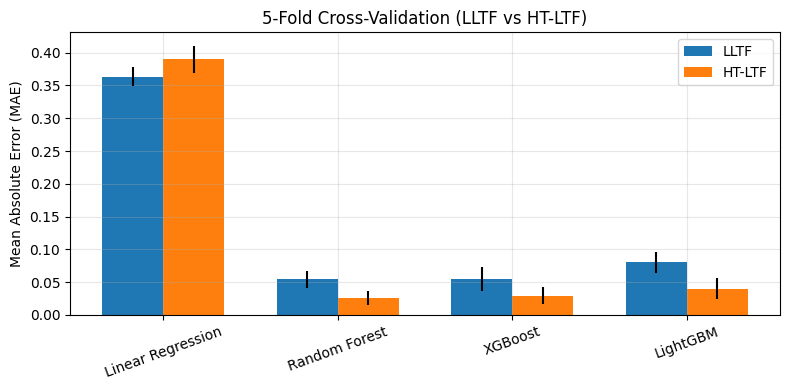

In [59]:
plt.figure(figsize=(8,4))
x = np.arange(len(cv_results_lltf.index))
width = 0.35

plt.bar(x - width/2, cv_results_lltf["MAE_mean"], width, yerr=cv_results_lltf["MAE_std"], label="LLTF")
plt.bar(x + width/2, cv_results_htltf["MAE_mean"], width, yerr=cv_results_htltf["MAE_std"], label="HT-LTF")

plt.xticks(x, cv_results_lltf.index, rotation=20)
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("5-Fold Cross-Validation (LLTF vs HT-LTF)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [60]:
# =======================================================
# Funzione per k-Fold CV dei modelli di classificazione
# =======================================================
def kfold_classification_cv(dataset, target_col="target", n_splits=5):
    """
    Esegue k-Fold Cross Validation per i modelli di classificazione.
    Ritorna accuracy media e deviazione standard per ogni modello.
    """
    X = dataset.drop(columns=[target_col])
    y = dataset[target_col]

    models = {
        "SVM (RBF)": SVC(kernel="rbf", C=10, gamma="scale"),
        "KNN": KNeighborsClassifier(n_neighbors=5),
        "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
        "XGBoost": XGBClassifier(n_estimators=200, learning_rate=0.1, random_state=42, use_label_encoder=False, eval_metric="mlogloss"),
        "LightGBM": LGBMClassifier(n_estimators=200, learning_rate=0.1, random_state=42),
        "GBDT": GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=42)
    }

    accuracy_scorer = make_scorer(accuracy_score)
    results = {}

    for name, model in models.items():
        pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("classifier", model)
        ])
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        scores = cross_val_score(pipeline, X, y, cv=kf, scoring=accuracy_scorer, n_jobs=-1)
        acc_mean = scores.mean()
        acc_std = scores.std()
        results[name] = (acc_mean, acc_std)
        print(f"{name:20s} → Accuracy media = {acc_mean:.4f} ± {acc_std:.4f}")

    results_df = pd.DataFrame(results, index=["Accuracy_mean", "Accuracy_std"]).T
    return results_df

In [61]:
print("===== K-FOLD CLASSIFICATION: LLTF =====")
cv_class_lltf = kfold_classification_cv(expanded_features_lltf, target_col="target")

print("\n===== K-FOLD CLASSIFICATION: HT-LTF =====")
cv_class_htltf = kfold_classification_cv(expanded_features_htltf, target_col="target")

===== K-FOLD CLASSIFICATION: LLTF =====
SVM (RBF)            → Accuracy media = 0.9992 ± 0.0017
KNN                  → Accuracy media = 0.9950 ± 0.0031
Random Forest        → Accuracy media = 1.0000 ± 0.0000
XGBoost              → Accuracy media = 1.0000 ± 0.0000
LightGBM             → Accuracy media = 0.9983 ± 0.0021
GBDT                 → Accuracy media = 0.9924 ± 0.0056

===== K-FOLD CLASSIFICATION: HT-LTF =====
SVM (RBF)            → Accuracy media = 1.0000 ± 0.0000
KNN                  → Accuracy media = 0.9942 ± 0.0042
Random Forest        → Accuracy media = 1.0000 ± 0.0000
XGBoost              → Accuracy media = 0.9967 ± 0.0040
LightGBM             → Accuracy media = 0.9983 ± 0.0033
GBDT                 → Accuracy media = 0.9959 ± 0.0064


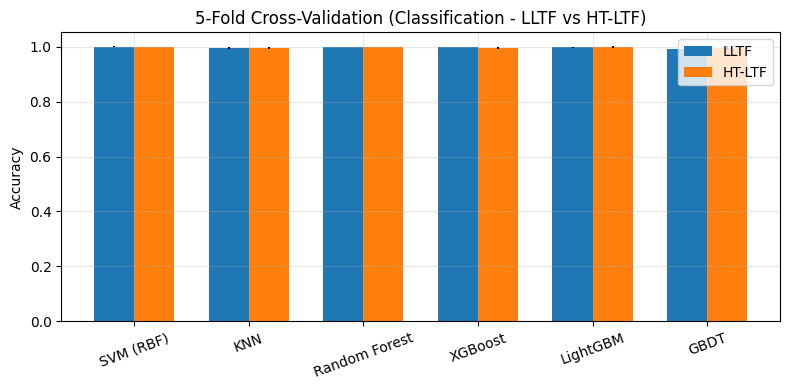

In [62]:
plt.figure(figsize=(8,4))
x = np.arange(len(cv_class_lltf.index))
width = 0.35

plt.bar(x - width/2, cv_class_lltf["Accuracy_mean"], width, yerr=cv_class_lltf["Accuracy_std"], label="LLTF")
plt.bar(x + width/2, cv_class_htltf["Accuracy_mean"], width, yerr=cv_class_htltf["Accuracy_std"], label="HT-LTF")

plt.xticks(x, cv_class_lltf.index, rotation=20)
plt.ylabel("Accuracy")
plt.title("5-Fold Cross-Validation (Classification - LLTF vs HT-LTF)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [63]:
def train_classifiers_2(dataset, target_col="target", titolo_suffix="Confusion Matrices"):

    X = dataset.drop(columns=[target_col])
    y = dataset[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42
    )

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    models = {
        "SVM (RBF)": SVC(kernel="rbf", C=10, gamma="scale"),
        "KNN": KNeighborsClassifier(n_neighbors=5),
        "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
        "XGBoost": XGBClassifier(n_estimators=200, learning_rate=0.1, random_state=42,
                                 use_label_encoder=False, eval_metric='mlogloss'),
        "LightGBM": LGBMClassifier(n_estimators=200, learning_rate=0.1, random_state=42),
        "GBDT": GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=42)
    }

    # Risultati
    f1_results = {}
    accuracy_results = {}
    time_results = {}
    metrics_table = []

    # -------------------------------
    # FIGURA UNICA DELLE CONFUSION MATRIX
    # -------------------------------
    n_models = len(models)
    n_cols = 3
    n_rows = math.ceil(n_models / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
    axes = axes.flatten()

    for idx, (name, model) in enumerate(models.items()):

        # --- TEMPO DI TRAINING ---
        start = time.perf_counter()
        model.fit(X_train, y_train)
        train_time = time.perf_counter() - start
        time_results[name] = train_time

        # Predizione
        y_pred = model.predict(X_test)

        # Accuracy
        accuracy_results[name] = accuracy_score(y_test, y_pred)

        # Report
        report_dict = classification_report(y_test, y_pred, output_dict=True)
        f1_macro = report_dict["macro avg"]["f1-score"]
        f1_results[name] = f1_macro

        # METRICHE DETTAGLIATE
        for label, values in report_dict.items():
            if label.isdigit():
                metrics_table.append({
                    "Model": name,
                    "Class": label,
                    "Precision": values["precision"],
                    "Recall": values["recall"],
                    "F1-score": values["f1-score"],
                    "Support": values["support"],
                    "Train_time_sec": train_time
                })

        # Confusion matrix
        ax = axes[idx]
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt=".0f",
                    cmap="Blues", ax=ax)
        ax.set_title(f"{name}\nTraining time: {train_time:.3f} sec  | F1-macro: {f1_macro:.3f} | Accuracy: {accuracy_results[name]:.3f}")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")

    # Rimuove subplot vuoti
    for i in range(idx+1, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.savefig(f"{titolo_suffix}.png", dpi=300)
    plt.show()
    print(f"\n📁 Confusion matrices salvate in:{titolo_suffix}.png")

    # -------------------------------
    # TABELLA RIASSUNTIVA ORDINATA PER F1 MACRO
    # -------------------------------
    f1_df = pd.DataFrame(
        {"Model": list(f1_results.keys()), 
         "F1_macro": list(f1_results.values()),
         "Train_time_sec": list(time_results.values())}
    ).sort_values("F1_macro", ascending=False)

    print("\n📊 Summary of F1 Macro scores (+ training time):")
    print(f1_df)



    # -------------------------------
    # TABELLA COMPLETA DELLE METRICHE
    # -------------------------------
    metrics_df = pd.DataFrame(metrics_table)

    print("\n📋 Full Classification Metrics Table (with training times):")
    print(metrics_df)

    return f1_df, metrics_df


In [64]:
def extract_link(col):
    match = re.match(r".*?_(\d+)_", col)
    if match:
        return int(match.group(1))
    return None

def link_importance_analysis(df, target_col="target"):

    # ---- 1) Seleziona X e y ----
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # ---- 2) Estrai numero link da ogni colonna ----
    link_ids = [extract_link(c) for c in X.columns]

    # Alcune colonne potrebbero non avere il formato std_1_5 → le mettiamo a -1
    link_ids = [-1 if x is None else x for x in link_ids]

    # ---- 3) Standardizzazione ----
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # ---- 4) Addestra modello con feature importance ----
    rf = RandomForestClassifier(n_estimators=300, random_state=42)
    rf.fit(X_scaled, y)

    # ---- 5) Raggruppa importanza per link ----
    fi = rf.feature_importances_
    feature_df = pd.DataFrame({
        "column": X.columns,
        "link": link_ids,
        "importance": fi
    })

    # Somma importanza per link
    link_importance = feature_df.groupby("link")["importance"].sum()

    # Ordina discendente
    link_importance = link_importance.sort_values(ascending=False)

    return feature_df, link_importance


In [65]:
import re

In [66]:
feature_df, link_importance = link_importance_analysis(expanded_features_htltf)
print(link_importance)


link
 4    0.308179
 2    0.275831
 3    0.208587
 1    0.205966
-1    0.001436
Name: importance, dtype: float64


In [67]:
def select_links(df, links, target_col="target"):
    """
    Seleziona solo le colonne relative ai link specificati.
    I link vengono identificati dal numero tra gli underscore: es. std_3_55 → link 3
    """
    selected_cols = []
    
    for col in df.columns:
        # Salta la colonna target
        if col == target_col:
            continue
        
        # Match del pattern: qualsiasi testo, underscore, numero, underscore
        match = re.match(r".*?_(\d+)_", col)
        if match:
            link_num = int(match.group(1))
            if link_num in links:
                selected_cols.append(col)

    # Ricostruisce un nuovo DataFrame
    selected_df = df[selected_cols + [target_col]].copy()
    return selected_df


In [68]:
links_da_usare = [2, 4]
df_filtrato_htltf = select_links(expanded_features_htltf, links_da_usare, target_col="target")

In [69]:
links_da_usare = [2, 4]
df_filtrato_lltf = select_links(expanded_features_lltf, links_da_usare, target_col="target")

c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:30:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 111474
[LightGBM] [Info] Number of data points in the train set: 833, number of used features: 824
[LightGBM] [Info] Start training from score -1.790560
[LightGBM] [Info] Start training from score -1.888752
[LightGBM] [Info] Start training from score -1.865221
[LightGBM] [Info] Start training from score -1.805053
[LightGBM] [Info] Start training from score -1.842232
[LightGBM] [Info] Start training from score -1.589235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


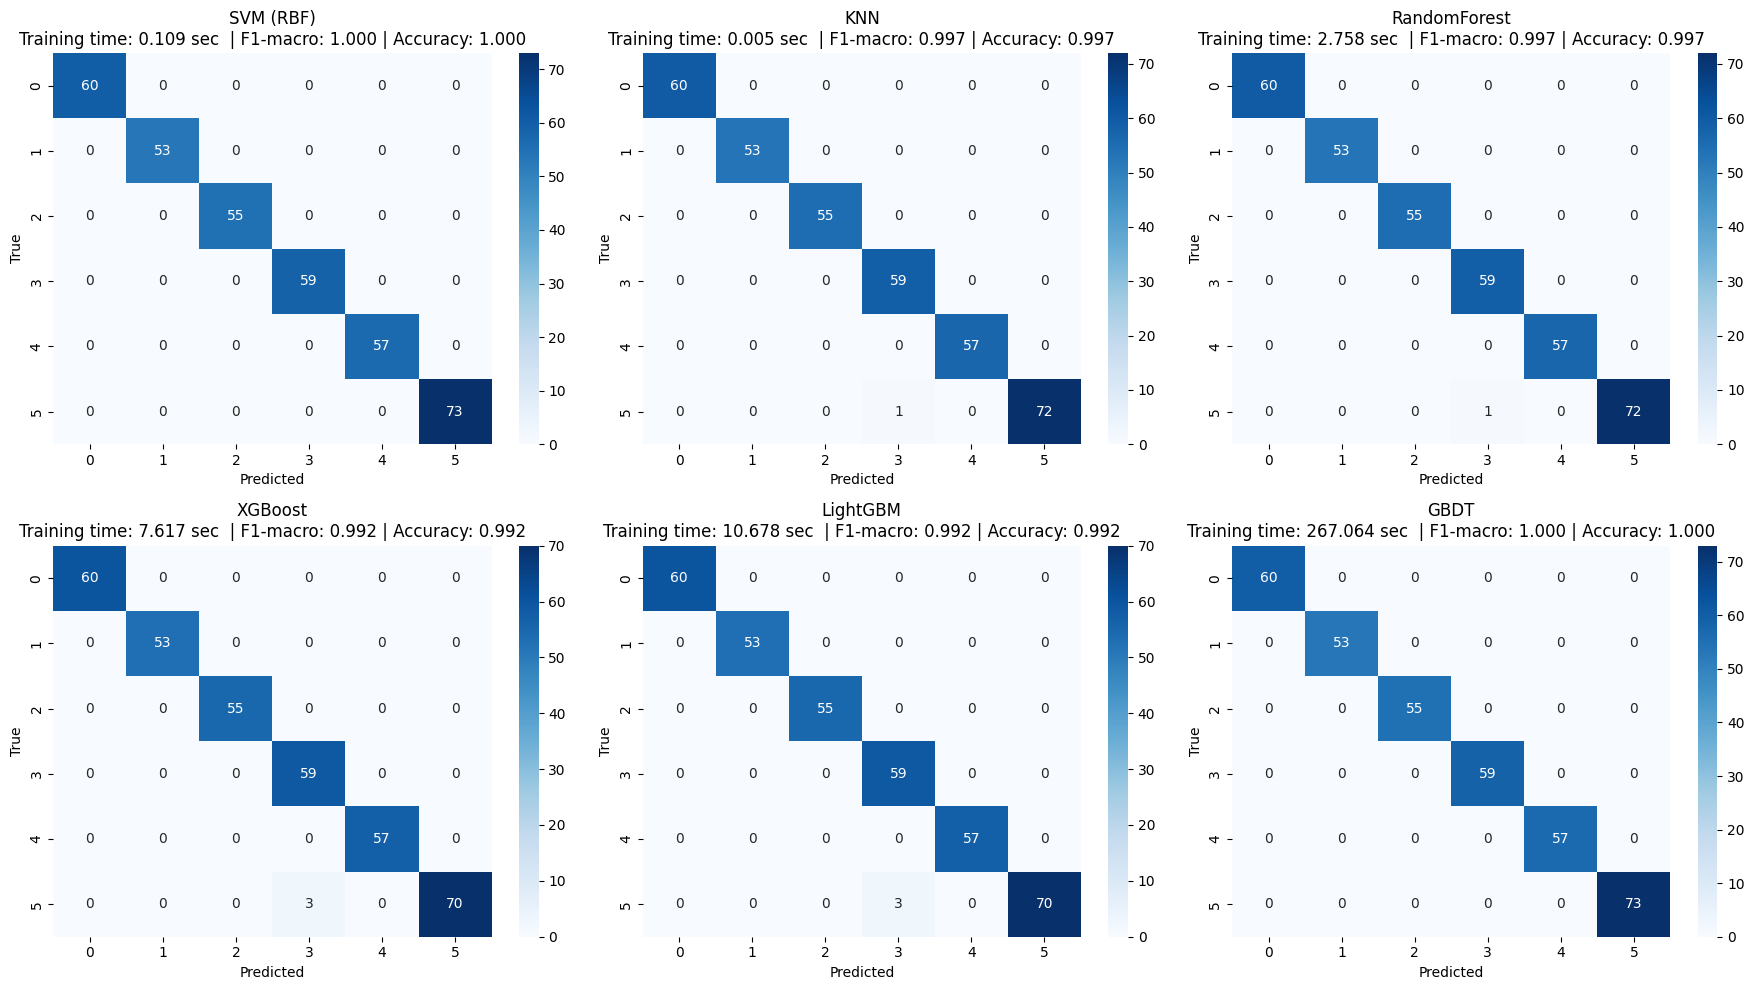


📁 Confusion matrices salvate in:Confusion Matrices LLTF senza filtro classi separate- Links 2 and 4.png

📊 Summary of F1 Macro scores (+ training time):
          Model  F1_macro  Train_time_sec
0     SVM (RBF)  1.000000        0.108967
5          GBDT  1.000000      267.064147
1           KNN  0.997450        0.005474
2  RandomForest  0.997450        2.757787
3       XGBoost  0.992371        7.616655
4      LightGBM  0.992371       10.678071

📋 Full Classification Metrics Table (with training times):
           Model Class  Precision    Recall  F1-score  Support  Train_time_sec
0      SVM (RBF)     0   1.000000  1.000000  1.000000     60.0        0.108967
1      SVM (RBF)     1   1.000000  1.000000  1.000000     53.0        0.108967
2      SVM (RBF)     2   1.000000  1.000000  1.000000     55.0        0.108967
3      SVM (RBF)     3   1.000000  1.000000  1.000000     59.0        0.108967
4      SVM (RBF)     4   1.000000  1.000000  1.000000     57.0        0.108967
5      SVM (RBF)  

In [70]:
results_lltf = train_classifiers_2(df_filtrato_lltf,titolo_suffix="Confusion Matrices LLTF senza filtro classi separate- Links 2 and 4")

c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:35:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 436168
[LightGBM] [Info] Number of data points in the train set: 847, number of used features: 1720
[LightGBM] [Info] Start training from score -1.711263
[LightGBM] [Info] Start training from score -1.913387
[LightGBM] [Info] Start training from score -1.881888
[LightGBM] [Info] Start training from score -1.821720
[LightGBM] [Info] Start training from score -1.851352
[LightGBM] [Info] Start training from score -1.605902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


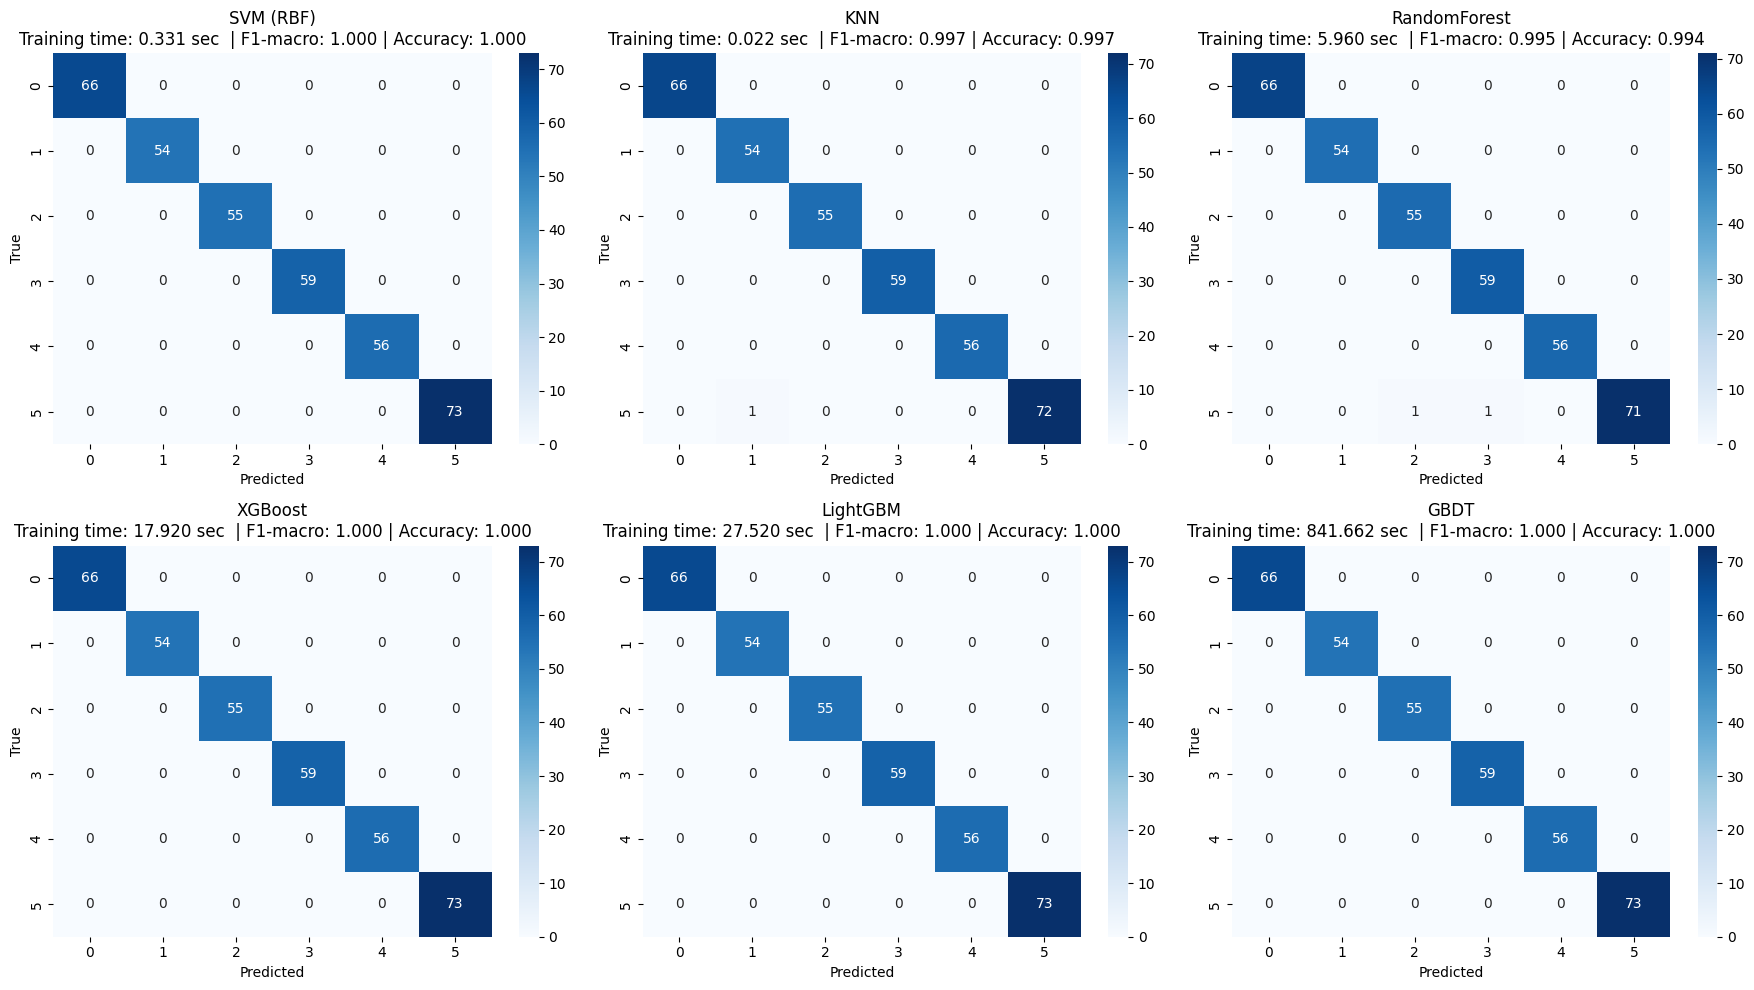


📁 Confusion matrices salvate in:Confusion Matrices HTLTF senza filtro classi separate - Links 2 and 4.png

📊 Summary of F1 Macro scores (+ training time):
          Model  F1_macro  Train_time_sec
0     SVM (RBF)  1.000000        0.330719
3       XGBoost  1.000000       17.919521
5          GBDT  1.000000      841.662141
4      LightGBM  1.000000       27.520024
1           KNN  0.997322        0.022342
2  RandomForest  0.994783        5.959606

📋 Full Classification Metrics Table (with training times):
           Model Class  Precision    Recall  F1-score  Support  Train_time_sec
0      SVM (RBF)     0   1.000000  1.000000  1.000000     66.0        0.330719
1      SVM (RBF)     1   1.000000  1.000000  1.000000     54.0        0.330719
2      SVM (RBF)     2   1.000000  1.000000  1.000000     55.0        0.330719
3      SVM (RBF)     3   1.000000  1.000000  1.000000     59.0        0.330719
4      SVM (RBF)     4   1.000000  1.000000  1.000000     56.0        0.330719
5      SVM (RBF)

In [71]:
results_htltf = train_classifiers_2(df_filtrato_htltf,titolo_suffix="Confusion Matrices HTLTF senza filtro classi separate - Links 2 and 4")

c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:50:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.366924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 871486
[LightGBM] [Info] Number of data points in the train set: 847, number of used features: 3444
[LightGBM] [Info] Start training from score -1.711263
[LightGBM] [Info] Start training from score -1.913387
[LightGBM] [Info] Start training from score -1.881888
[LightGBM] [Info] Start training from score -1.821720
[LightGBM] [Info] Start training from score -1.851352
[LightGBM] [Info] Start training from score -1.605902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


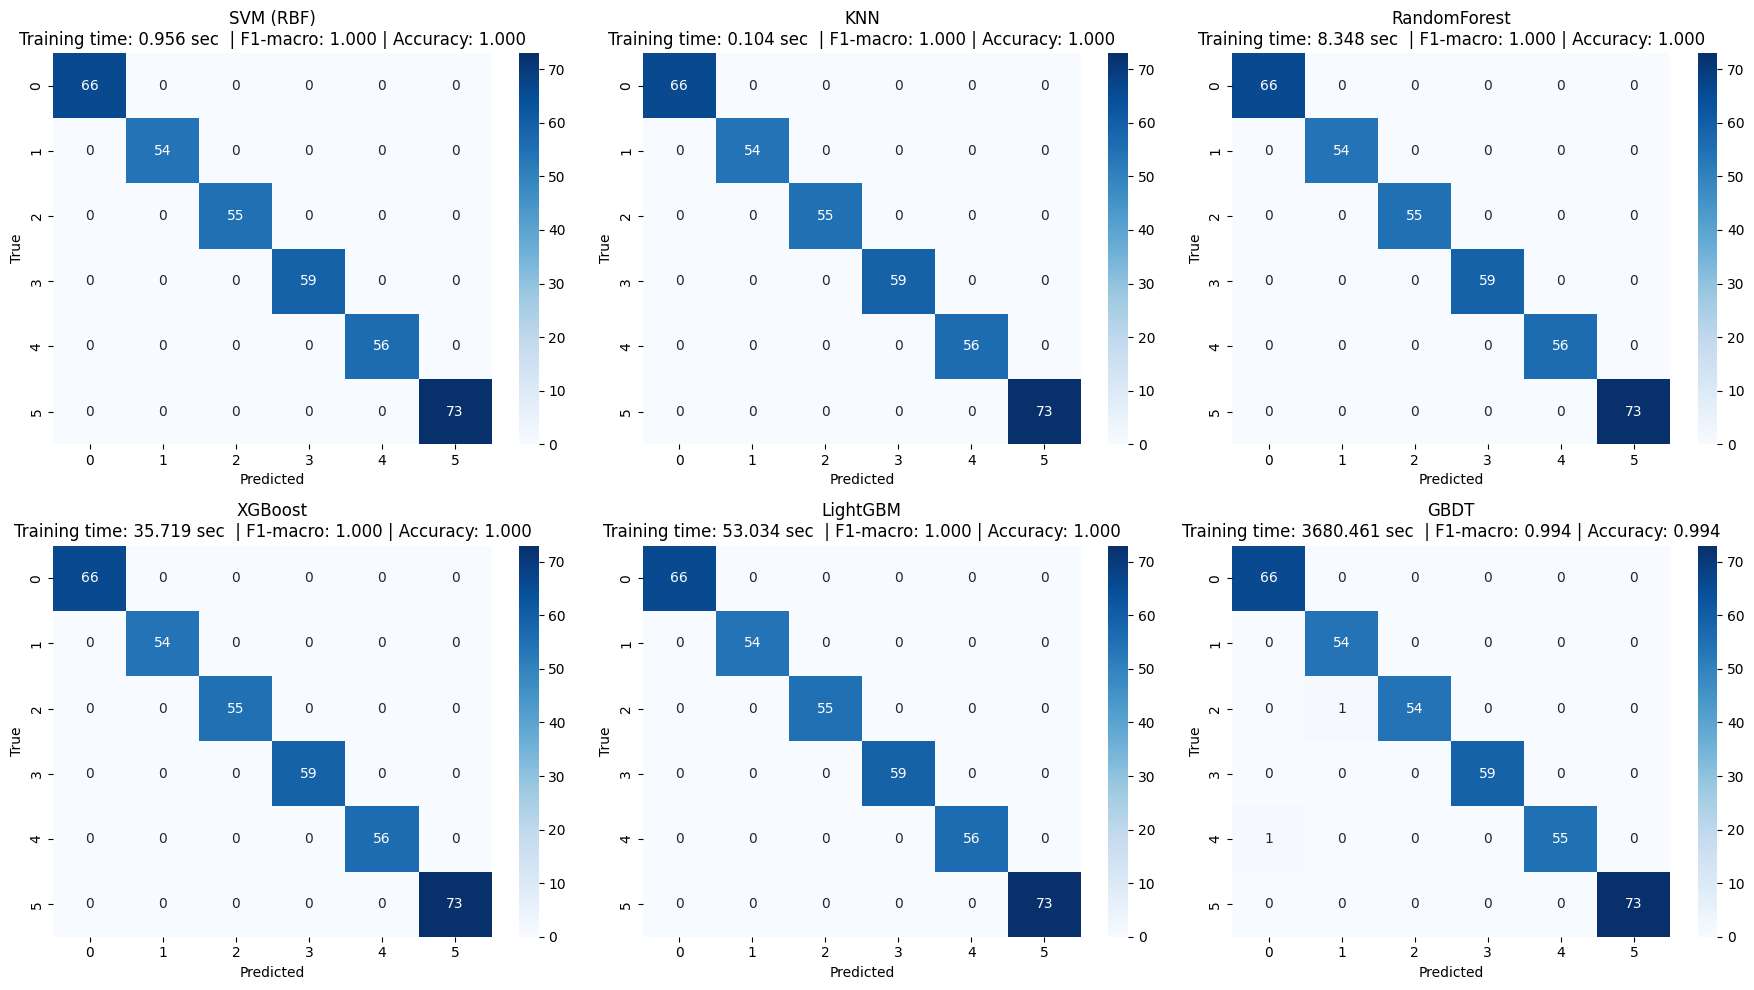


📁 Confusion matrices salvate in:Confusion Matrices HTLTF  senza filtro classi separate- All Links.png

📊 Summary of F1 Macro scores (+ training time):
          Model  F1_macro  Train_time_sec
0     SVM (RBF)  1.000000        0.956434
1           KNN  1.000000        0.104341
2  RandomForest  1.000000        8.347978
3       XGBoost  1.000000       35.719448
4      LightGBM  1.000000       53.033757
5          GBDT  0.994187     3680.460832

📋 Full Classification Metrics Table (with training times):
           Model Class  Precision    Recall  F1-score  Support  Train_time_sec
0      SVM (RBF)     0   1.000000  1.000000  1.000000     66.0        0.956434
1      SVM (RBF)     1   1.000000  1.000000  1.000000     54.0        0.956434
2      SVM (RBF)     2   1.000000  1.000000  1.000000     55.0        0.956434
3      SVM (RBF)     3   1.000000  1.000000  1.000000     59.0        0.956434
4      SVM (RBF)     4   1.000000  1.000000  1.000000     56.0        0.956434
5      SVM (RBF)    

In [72]:
f1_df, metrics_df = train_classifiers_2(expanded_features_htltf, titolo_suffix="Confusion Matrices HTLTF  senza filtro classi separate- All Links")

c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:53:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 223506
[LightGBM] [Info] Number of data points in the train set: 833, number of used features: 1652
[LightGBM] [Info] Start training from score -1.790560
[LightGBM] [Info] Start training from score -1.888752
[LightGBM] [Info] Start training from score -1.865221
[LightGBM] [Info] Start training from score -1.805053
[LightGBM] [Info] Start training from score -1.842232
[LightGBM] [Info] Start training from score -1.589235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


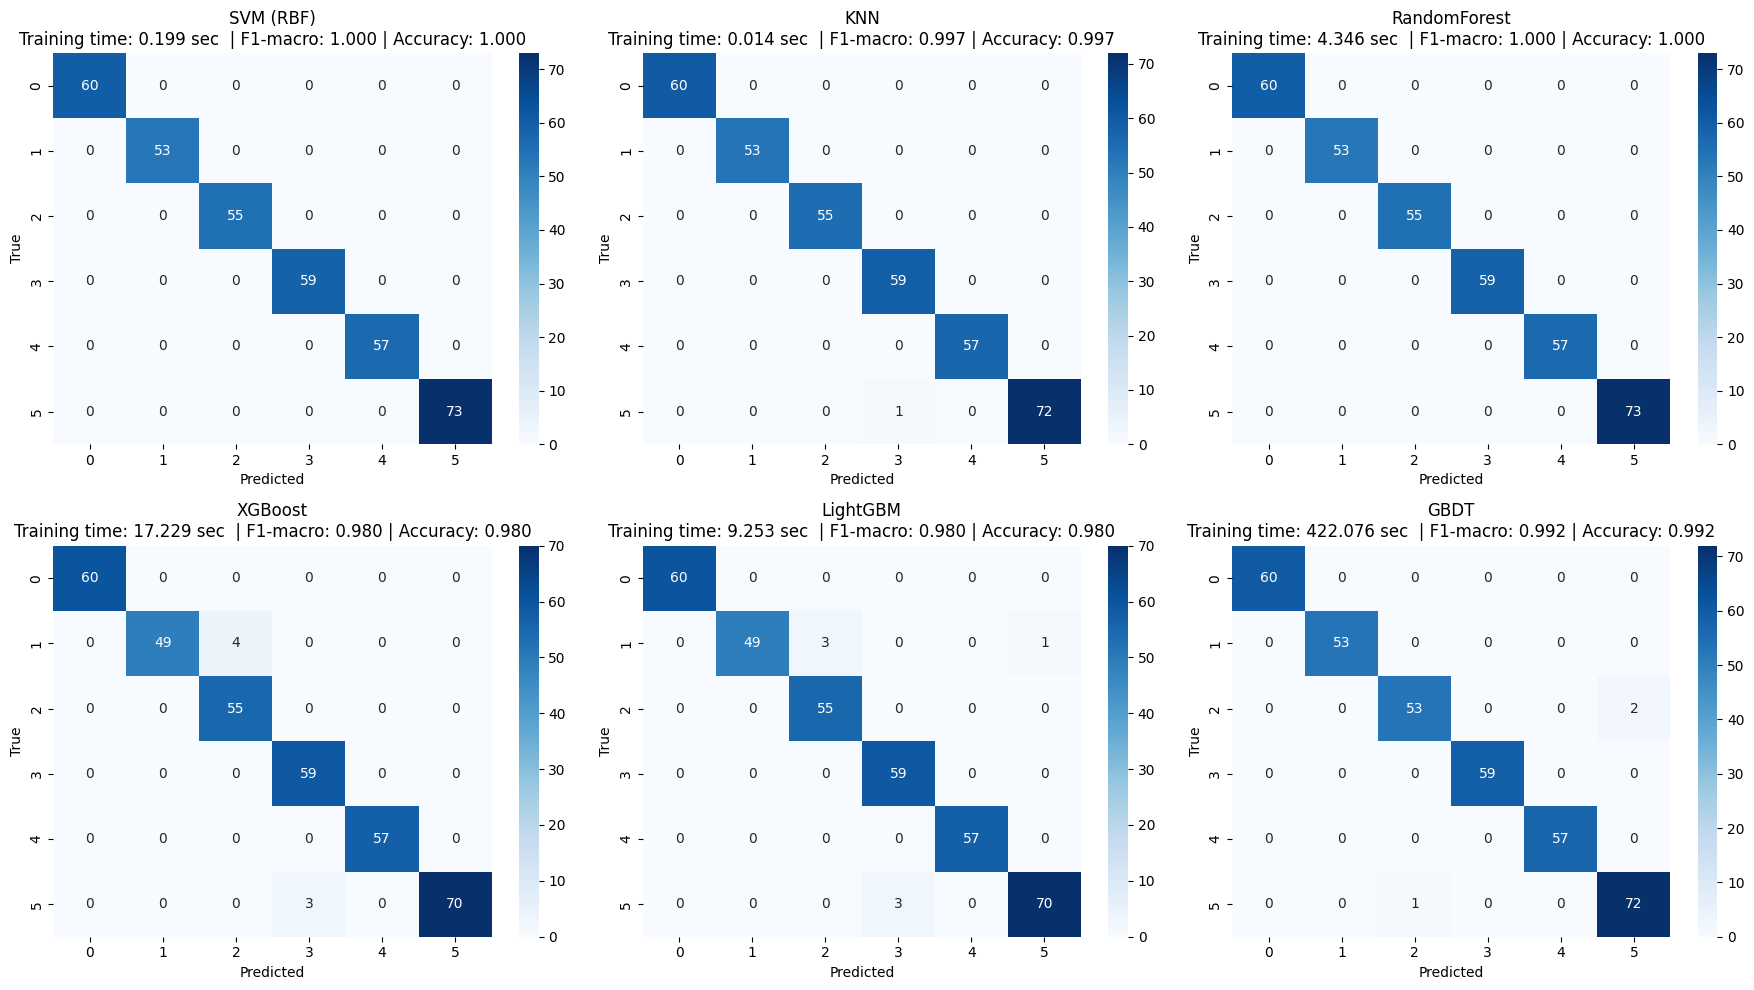


📁 Confusion matrices salvate in:Confusion Matrices LLTF senza filtro classi separate- All Links.png

📊 Summary of F1 Macro scores (+ training time):
          Model  F1_macro  Train_time_sec
0     SVM (RBF)  1.000000        0.198883
2  RandomForest  1.000000        4.345617
1           KNN  0.997450        0.013594
5          GBDT  0.992011      422.075851
4      LightGBM  0.980277        9.252625
3       XGBoost  0.979987       17.229139

📋 Full Classification Metrics Table (with training times):
           Model Class  Precision    Recall  F1-score  Support  Train_time_sec
0      SVM (RBF)     0   1.000000  1.000000  1.000000     60.0        0.198883
1      SVM (RBF)     1   1.000000  1.000000  1.000000     53.0        0.198883
2      SVM (RBF)     2   1.000000  1.000000  1.000000     55.0        0.198883
3      SVM (RBF)     3   1.000000  1.000000  1.000000     59.0        0.198883
4      SVM (RBF)     4   1.000000  1.000000  1.000000     57.0        0.198883
5      SVM (RBF)     5

In [73]:
f1_df, metrics_df = train_classifiers_2(expanded_features_lltf, titolo_suffix="Confusion Matrices LLTF senza filtro classi separate- All Links")

In [74]:
def train_regressors_2(dataset, target_col="target", titolo_suffix="Regression Results"):

    # --------------------------
    # PREPROCESSING
    # --------------------------
    X = dataset.drop(columns=[target_col])
    y = dataset[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # --------------------------
    # MODELLI DI REGRESSIONE
    # --------------------------
    models = {
        "SVR (RBF)": SVR(kernel="rbf", C=10, gamma="scale"),
        "KNN Regr": KNeighborsRegressor(n_neighbors=5),
        "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
        "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42),
        "LightGBM": LGBMRegressor(n_estimators=200, learning_rate=0.1, random_state=42),
        "GBDT": GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
    }

    metrics_list = []

    # --------------------------
    # FIGURA UNICA DEI PLOT
    # --------------------------
    n_models = len(models)
    n_cols = 3
    n_rows = math.ceil(n_models / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
    axes = axes.flatten()

    for idx, (name, model) in enumerate(models.items()):

        # --- TEMPO DI TRAINING ---
        start = time.perf_counter()
        model.fit(X_train, y_train)
        train_time = time.perf_counter() - start

        # Predizione
        y_pred = model.predict(X_test)

        # --------------------------
        # CALCOLO METRICHE
        # --------------------------
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        metrics_list.append({
            "Model": name,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R2": r2,
            "Train_time_sec": train_time
        })

        # --------------------------
        # SCATTER PLOT TRUE vs PRED
        # --------------------------
        ax = axes[idx]
        sns.scatterplot(x=y_test, y=y_pred, ax=ax, s=20, alpha=0.6)
        ax.set_title(f"{name}\nTraining time: {train_time:.3f} sec | RMSE: {rmse:.4f} | R2: {r2:.4f}")
        ax.set_xlabel("True")
        ax.set_ylabel("Predicted")
        ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')

    # rimuovere subplot vuoti
    for i in range(idx+1, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.savefig(f"regression_results_{titolo_suffix.replace(' ', '_').lower()}.png", dpi=300)
    plt.show()

    print(f"\n📁 Figura salvata in: regression_results_{titolo_suffix.replace(' ', '_').lower()}.png")

    # --------------------------
    # TABELLA METRICHE
    # --------------------------
    metrics_df = pd.DataFrame(metrics_list)

    metrics_df_sorted = metrics_df.sort_values("RMSE", ascending=True)

    print("\n📊 Regression Metrics (sorted by RMSE):")
    print(metrics_df_sorted)


    return metrics_df_sorted


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 436020
[LightGBM] [Info] Number of data points in the train set: 847, number of used features: 1720
[LightGBM] [Info] Start training from score 2.591499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


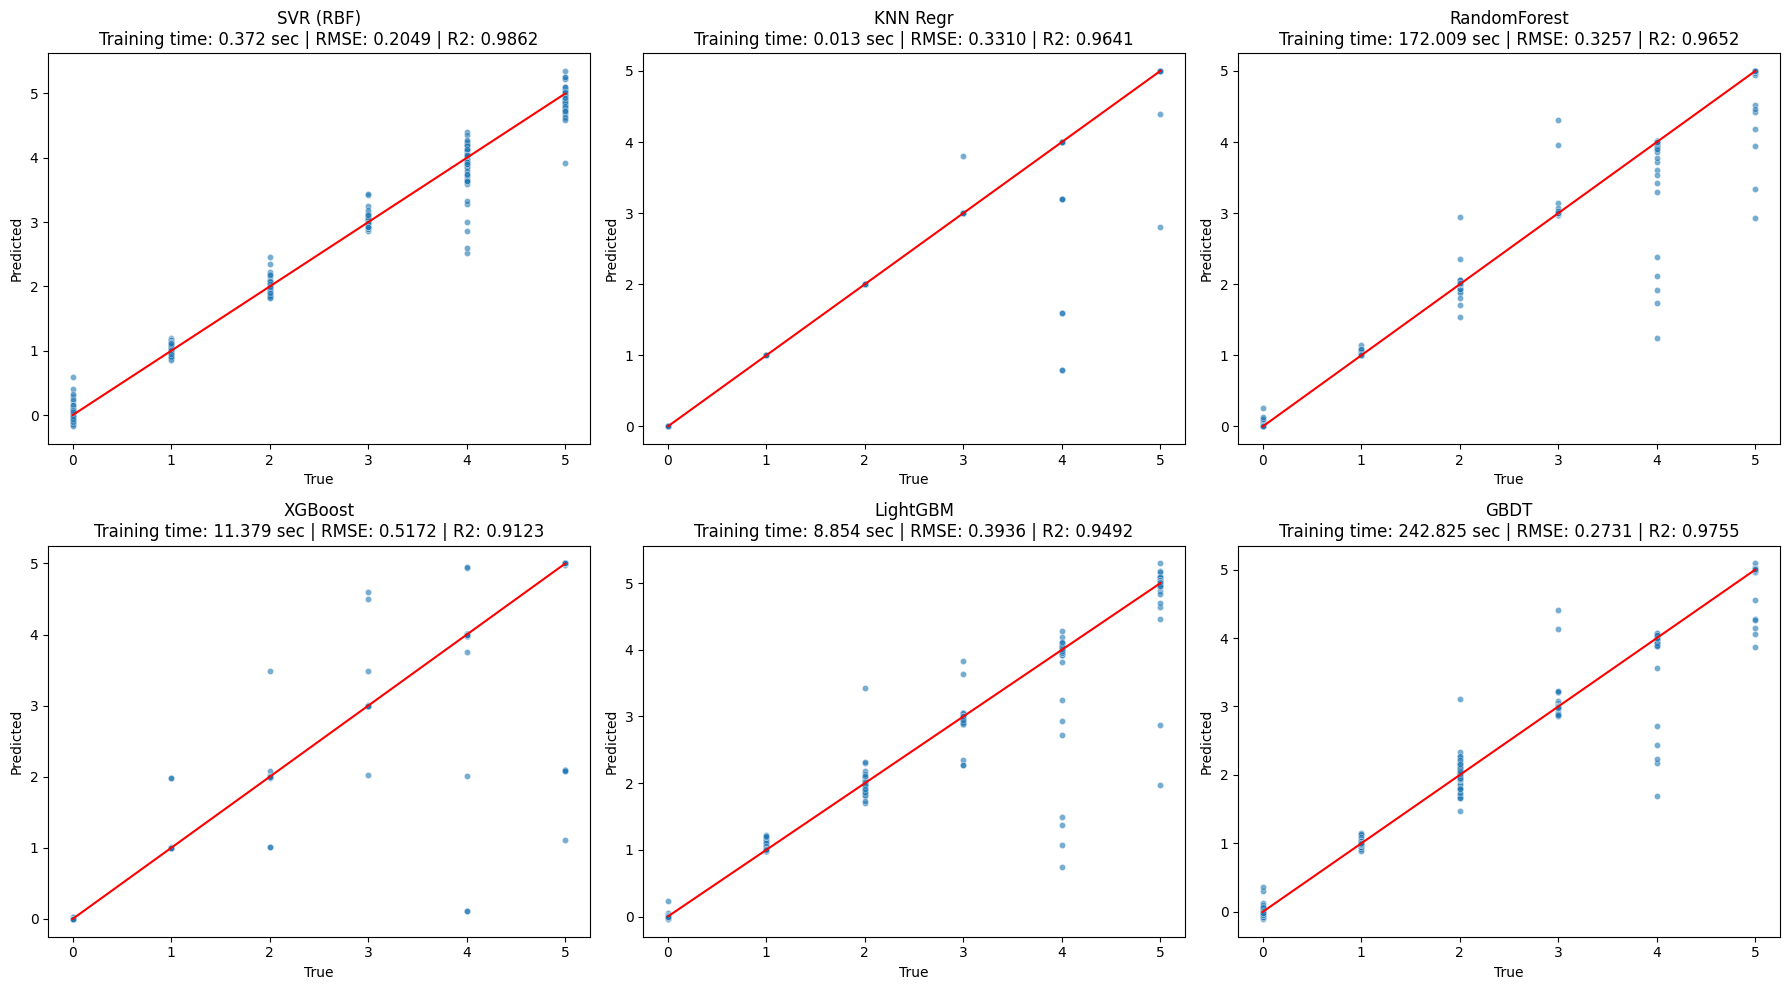


📁 Figura salvata in: regression_results_regression_results_htltf_senza_filtro_classi_separate_-_links_2_and_4.png

📊 Regression Metrics (sorted by RMSE):
          Model       MAE       MSE      RMSE        R2  Train_time_sec
0     SVR (RBF)  0.114919  0.042000  0.204938  0.986224        0.371849
5          GBDT  0.091021  0.074576  0.273085  0.975539      242.825477
2  RandomForest  0.080331  0.106058  0.325665  0.965213      172.009278
1      KNN Regr  0.047383  0.109532  0.330956  0.964074        0.013150
4      LightGBM  0.108247  0.154890  0.393561  0.949196        8.853803
3       XGBoost  0.104224  0.267527  0.517230  0.912252       11.379461


In [75]:
metrics_df_sorted_htltf= train_regressors_2(df_filtrato_htltf, titolo_suffix="Regression Results HTLTF senza filtro classi separate - Links 2 and 4")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.201251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 871636
[LightGBM] [Info] Number of data points in the train set: 847, number of used features: 3444
[LightGBM] [Info] Start training from score 2.591499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


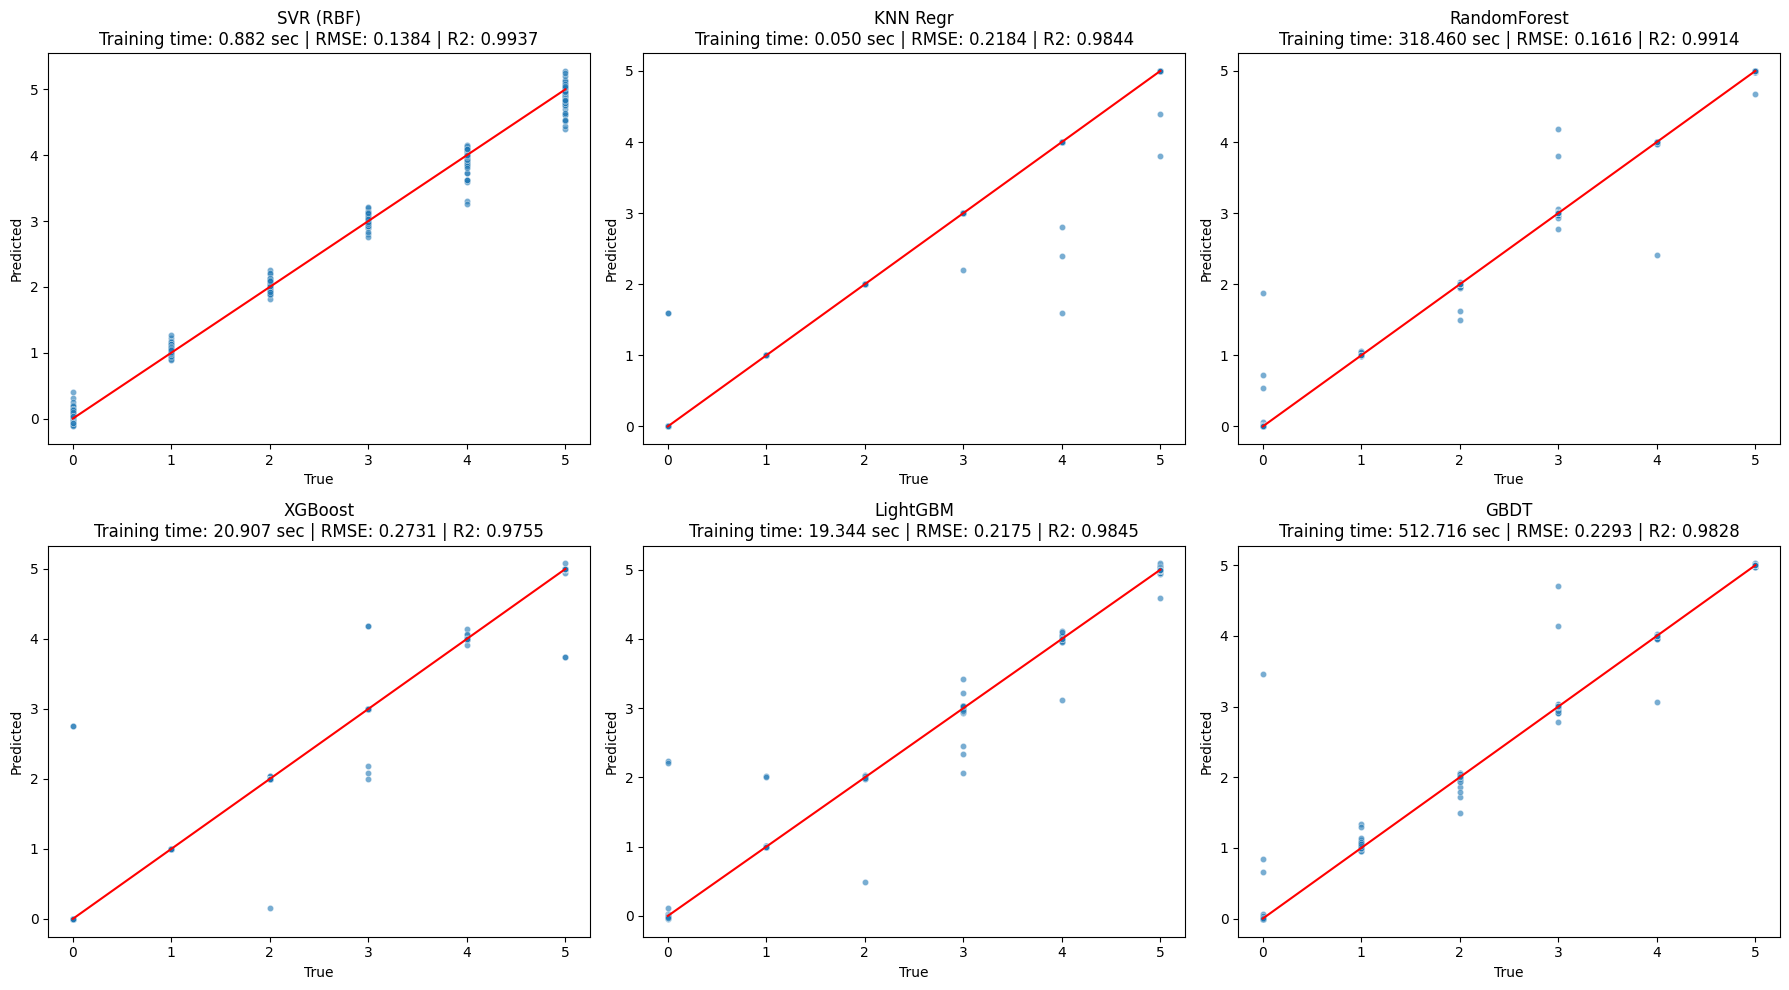


📁 Figura salvata in: regression_results_regression_results_htltf_senza_filtro_classi_separete-_all_links.png

📊 Regression Metrics (sorted by RMSE):
          Model       MAE       MSE      RMSE        R2  Train_time_sec
0     SVR (RBF)  0.093096  0.019143  0.138358  0.993721        0.881873
2  RandomForest  0.026309  0.026113  0.161596  0.991435      318.460035
4      LightGBM  0.046388  0.047296  0.217476  0.984487       19.343579
1      KNN Regr  0.030303  0.047713  0.218434  0.984350        0.049853
5          GBDT  0.041077  0.052566  0.229274  0.982758      512.716176
3       XGBoost  0.043074  0.074581  0.273096  0.975538       20.906804


In [76]:
metrics_df_sorted_HTLTF= train_regressors_2(expanded_features_htltf, titolo_suffix="Regression Results HTLTF senza filtro classi separete- All Links")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 112394
[LightGBM] [Info] Number of data points in the train set: 833, number of used features: 824
[LightGBM] [Info] Start training from score 2.678271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


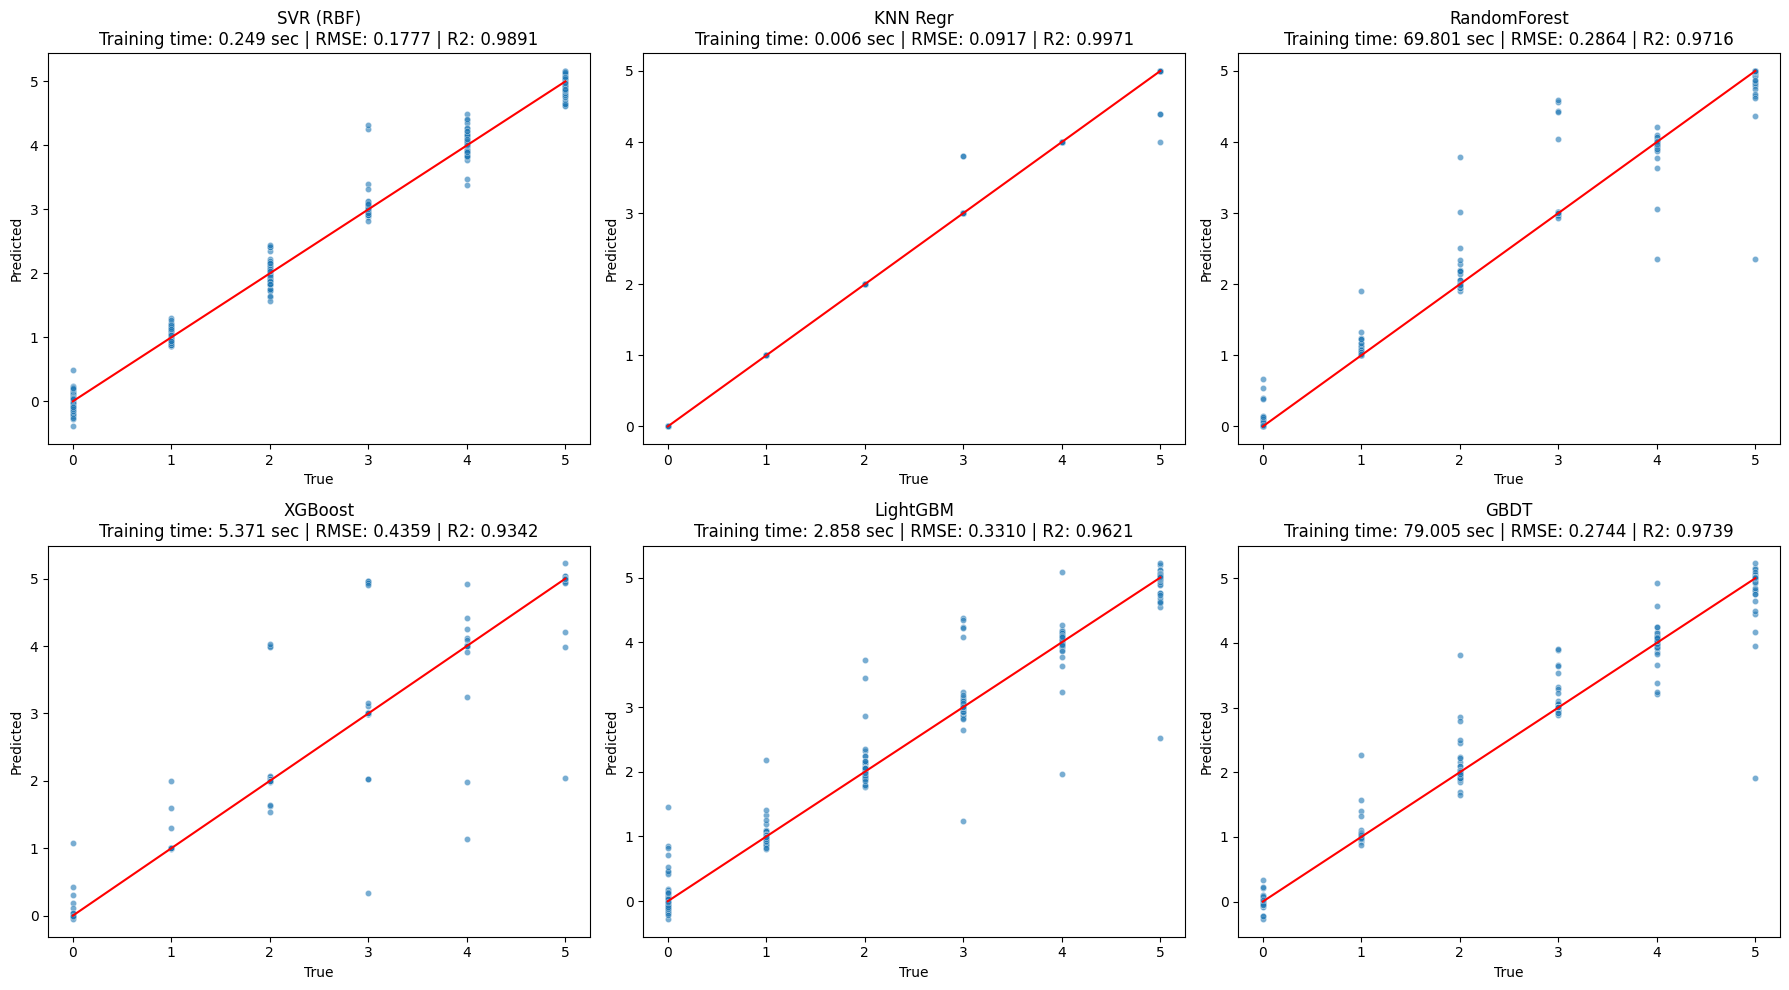


📁 Figura salvata in: regression_results_regression_results_lltf_senza_filtro_classi_separate-_links_2_and_4.png

📊 Regression Metrics (sorted by RMSE):
          Model       MAE       MSE      RMSE        R2  Train_time_sec
1      KNN Regr  0.010644  0.008403  0.091670  0.997088        0.005849
0     SVR (RBF)  0.116828  0.031568  0.177674  0.989063        0.248636
5          GBDT  0.101335  0.075294  0.274398  0.973913       79.005253
2  RandomForest  0.083866  0.082024  0.286398  0.971581       69.800646
4      LightGBM  0.140368  0.109531  0.330955  0.962051        2.857853
3       XGBoost  0.110886  0.190046  0.435943  0.934155        5.371131


In [77]:
metrics_df_sorted_lltf= train_regressors_2(df_filtrato_lltf, titolo_suffix="Regression Results LLTF senza filtro classi separate- Links 2 and 4")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 224380
[LightGBM] [Info] Number of data points in the train set: 833, number of used features: 1652
[LightGBM] [Info] Start training from score 2.678271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


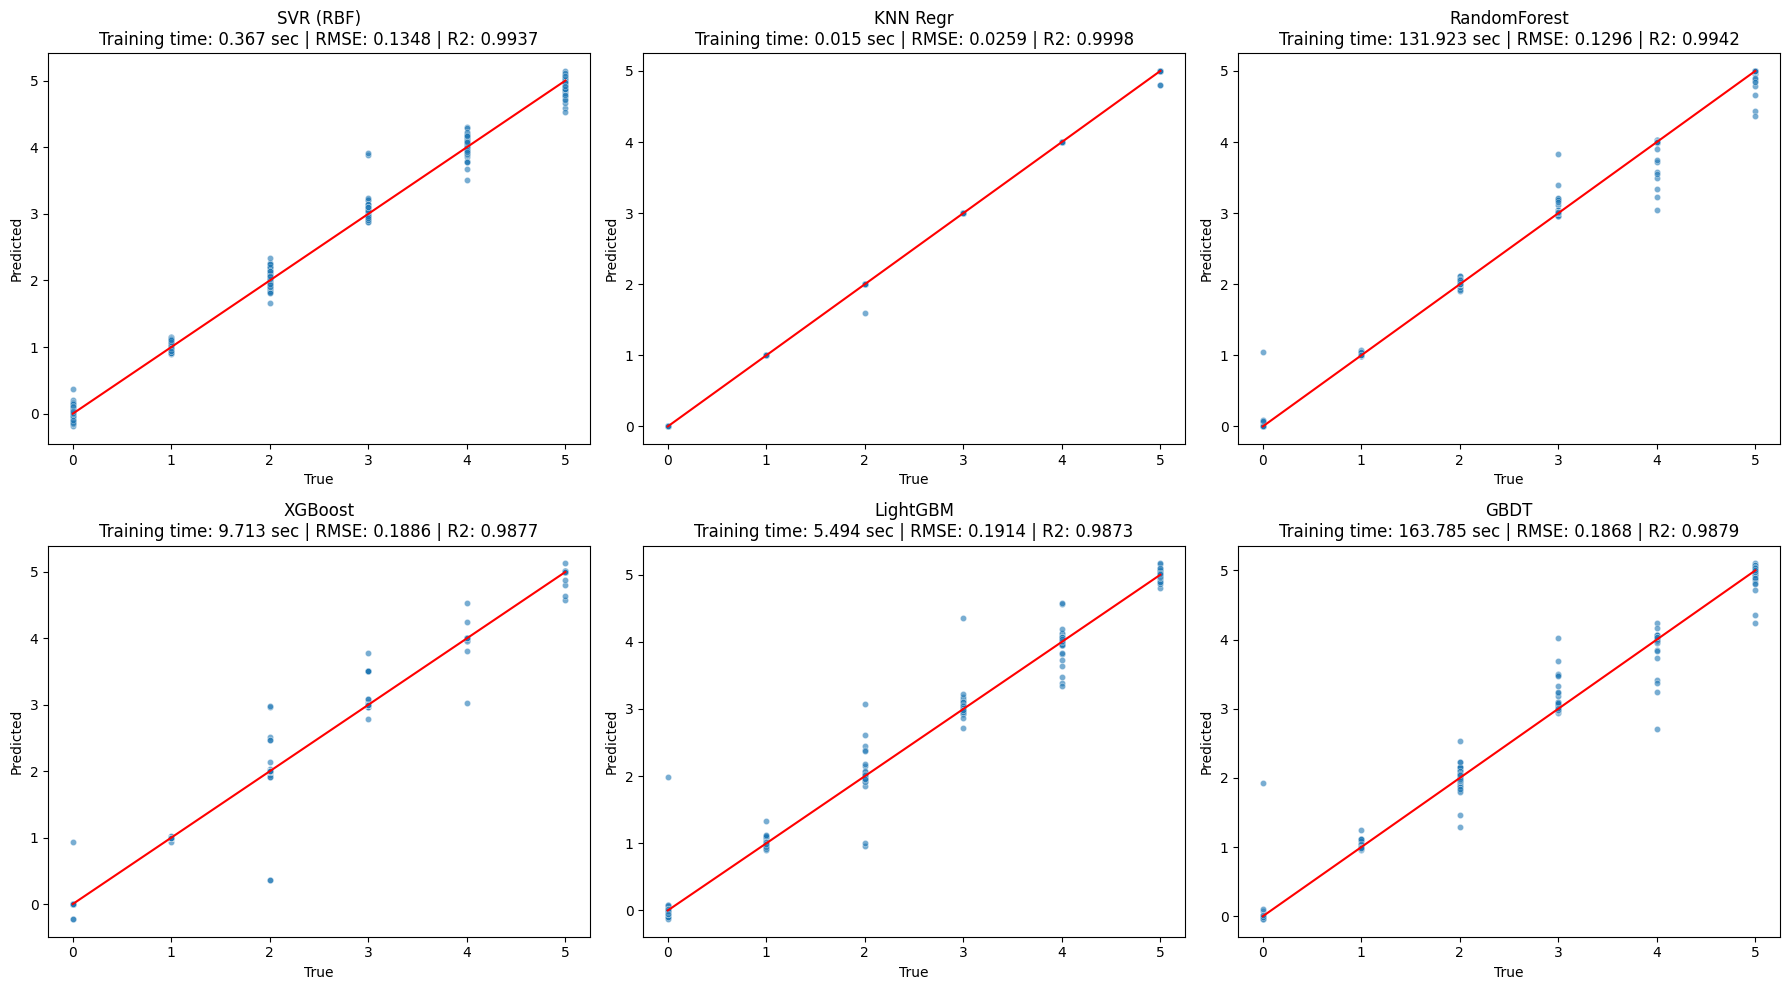


📁 Figura salvata in: regression_results_regression_results_lltf_senza_filtro_classi_separate-_all_links.png

📊 Regression Metrics (sorted by RMSE):
          Model       MAE       MSE      RMSE        R2  Train_time_sec
1      KNN Regr  0.002241  0.000672  0.025928  0.999767        0.014714
2  RandomForest  0.038067  0.016790  0.129577  0.994183      131.923455
0     SVR (RBF)  0.094477  0.018166  0.134781  0.993706        0.366647
5          GBDT  0.068086  0.034896  0.186804  0.987910      163.785114
3       XGBoost  0.045266  0.035571  0.188603  0.987676        9.713264
4      LightGBM  0.072607  0.036625  0.191375  0.987311        5.493687


In [78]:
metrics_df_sorted_LLTF= train_regressors_2(expanded_features_lltf, titolo_suffix="Regression Results LLTF senza filtro classi separate- All Links")

# vediamo per feature

In [101]:
matrice_std_assenza_htltf['target']=0
matrice_std_una_ferma_htltf['target']=1
matrice_std_una_movimento_htltf['target']=2
matrice_std_due_ferme_htltf['target']=3
matrice_std_due_movimento_htltf['target']=4
matrice_std_tre_ferme_htltf['target']=5

matrice_min_assenza_htltf['target']=0
matrice_min_una_ferma_htltf['target']=1
matrice_min_una_movimento_htltf['target']=2
matrice_min_due_ferme_htltf['target']=3
matrice_min_due_movimento_htltf['target']=4
matrice_min_tre_ferme_htltf['target']=5

matrice_max_assenza_htltf['target']=0
matrice_max_una_ferma_htltf['target']=1
matrice_max_una_movimento_htltf['target']=2
matrice_max_due_ferme_htltf['target']=3
matrice_max_due_movimento_htltf['target']=4
matrice_max_tre_ferme_htltf['target']=5

matrice_qtl_assenza_htltf['target']=0
matrice_qtl_una_ferma_htltf['target']=1
matrice_qtl_una_movimento_htltf['target']=2
matrice_qtl_due_ferme_htltf['target']=3
matrice_qtl_due_movimento_htltf['target']=4
matrice_qtl_tre_ferme_htltf['target']=5

matrice_qtu_assenza_htltf['target']=0
matrice_qtu_una_ferma_htltf['target']=1
matrice_qtu_una_movimento_htltf['target']=2
matrice_qtu_due_ferme_htltf['target']=3
matrice_qtu_due_movimento_htltf['target']=4
matrice_qtu_tre_ferme_htltf['target']=5

matrice_avg_assenza_htltf['target']=0
matrice_avg_una_ferma_htltf['target']=1
matrice_avg_una_movimento_htltf['target']=2
matrice_avg_due_ferme_htltf['target']=3
matrice_avg_due_movimento_htltf['target']=4
matrice_avg_tre_ferme_htltf['target']=5

matrice_iqr_assenza_htltf['target']=0
matrice_iqr_una_ferma_htltf['target']=1
matrice_iqr_una_movimento_htltf['target']=2
matrice_iqr_due_ferme_htltf['target']=3
matrice_iqr_due_movimento_htltf['target']=4
matrice_iqr_tre_ferme_htltf['target']=5

matrice_euc_assenza_htltf['target']=0
matrice_euc_una_ferma_htltf['target']=1
matrice_euc_una_movimento_htltf['target']=2
matrice_euc_due_ferme_htltf['target']=3
matrice_euc_due_movimento_htltf['target']=4
matrice_euc_tre_ferme_htltf['target']=5

matrice_adj_assenza_htltf['target']=0
matrice_adj_una_ferma_htltf['target']=1
matrice_adj_una_movimento_htltf['target']=2
matrice_adj_due_ferme_htltf['target']=3
matrice_adj_due_movimento_htltf['target']=4
matrice_adj_tre_ferme_htltf['target']=5

In [102]:
matrice_std_assenza_lltf['target']=0
matrice_std_una_ferma_lltf['target']=1
matrice_std_una_movimento_lltf['target']=2
matrice_std_due_ferme_lltf['target']=3
matrice_std_due_movimento_lltf['target']=4
matrice_std_tre_ferme_lltf['target']=5

matrice_min_assenza_lltf['target']=0
matrice_min_una_ferma_lltf['target']=1
matrice_min_una_movimento_lltf['target']=2
matrice_min_due_ferme_lltf['target']=3
matrice_min_due_movimento_lltf['target']=4
matrice_min_tre_ferme_lltf['target']=5

matrice_max_assenza_lltf['target']=0
matrice_max_una_ferma_lltf['target']=1
matrice_max_una_movimento_lltf['target']=2
matrice_max_due_ferme_lltf['target']=3
matrice_max_due_movimento_lltf['target']=4
matrice_max_tre_ferme_lltf['target']=5

matrice_qtl_assenza_lltf['target']=0
matrice_qtl_una_ferma_lltf['target']=1
matrice_qtl_una_movimento_lltf['target']=2
matrice_qtl_due_ferme_lltf['target']=3
matrice_qtl_due_movimento_lltf['target']=4
matrice_qtl_tre_ferme_lltf['target']=5

matrice_qtu_assenza_lltf['target']=0
matrice_qtu_una_ferma_lltf['target']=1
matrice_qtu_una_movimento_lltf['target']=2
matrice_qtu_due_ferme_lltf['target']=3
matrice_qtu_due_movimento_lltf['target']=4
matrice_qtu_tre_ferme_lltf['target']=5

matrice_avg_assenza_lltf['target']=0
matrice_avg_una_ferma_lltf['target']=1
matrice_avg_una_movimento_lltf['target']=2
matrice_avg_due_ferme_lltf['target']=3
matrice_avg_due_movimento_lltf['target']=4
matrice_avg_tre_ferme_lltf['target']=5

matrice_iqr_assenza_lltf['target']=0
matrice_iqr_una_ferma_lltf['target']=1
matrice_iqr_una_movimento_lltf['target']=2
matrice_iqr_due_ferme_lltf['target']=3
matrice_iqr_due_movimento_lltf['target']=4
matrice_iqr_tre_ferme_lltf['target']=5

matrice_euc_assenza_lltf['target']=0
matrice_euc_una_ferma_lltf['target']=1
matrice_euc_una_movimento_lltf['target']=2
matrice_euc_due_ferme_lltf['target']=3
matrice_euc_due_movimento_lltf['target']=4
matrice_euc_tre_ferme_lltf['target']=5

matrice_adj_assenza_lltf['target']=0
matrice_adj_una_ferma_lltf['target']=1
matrice_adj_una_movimento_lltf['target']=2
matrice_adj_due_ferme_lltf['target']=3
matrice_adj_due_movimento_lltf['target']=4
matrice_adj_tre_ferme_lltf['target']=5

In [109]:
#concateno tutte le matrici in un unico dataframe
df_finale_std_htltf = pd.concat([
    matrice_std_assenza_htltf,
    matrice_std_una_ferma_htltf,
    matrice_std_una_movimento_htltf,
    matrice_std_due_ferme_htltf,
    matrice_std_due_movimento_htltf,
    matrice_std_tre_ferme_htltf
], axis=0).reset_index(drop=True)

df_finale_min_htltf = pd.concat([
    matrice_min_assenza_htltf,
    matrice_min_una_ferma_htltf,
    matrice_min_una_movimento_htltf,
    matrice_min_due_ferme_htltf,
    matrice_min_due_movimento_htltf,
    matrice_min_tre_ferme_htltf
], axis=0).reset_index(drop=True)

df_finale_max_htltf= pd.concat([
    matrice_max_assenza_htltf,
    matrice_max_una_ferma_htltf,
    matrice_max_una_movimento_htltf,
    matrice_max_due_ferme_htltf,
    matrice_max_due_movimento_htltf,
    matrice_max_tre_ferme_htltf
], axis=0).reset_index(drop=True)

df_finale_qtl_htltf= pd.concat([
    matrice_qtl_assenza_htltf,
    matrice_qtl_una_ferma_htltf,
    matrice_qtl_una_movimento_htltf,
    matrice_qtl_due_ferme_htltf,
    matrice_qtl_due_movimento_htltf,
    matrice_qtl_tre_ferme_htltf
], axis=0).reset_index(drop=True)

df_finale_qtu_htltf= pd.concat([
    matrice_qtu_assenza_htltf,
    matrice_qtu_una_ferma_htltf,
    matrice_qtu_una_movimento_htltf,
    matrice_qtu_due_ferme_htltf,
    matrice_qtu_due_movimento_htltf,
    matrice_qtu_tre_ferme_htltf
], axis=0).reset_index(drop=True)

df_finale_avg_htltf= pd.concat([
    matrice_avg_assenza_htltf,   
    matrice_avg_una_ferma_htltf,
    matrice_avg_una_movimento_htltf,
    matrice_avg_due_ferme_htltf,
    matrice_avg_due_movimento_htltf,
    matrice_avg_tre_ferme_htltf
], axis=0).reset_index(drop=True)

df_finale_iqr_htltf= pd.concat([
    matrice_iqr_assenza_htltf,
    matrice_iqr_una_ferma_htltf,
    matrice_iqr_una_movimento_htltf,
    matrice_iqr_due_ferme_htltf,
    matrice_iqr_due_movimento_htltf,
    matrice_iqr_tre_ferme_htltf
], axis=0).reset_index(drop=True)

df_finale_euc_htltf = pd.concat([
    matrice_euc_assenza_htltf,
    matrice_euc_una_ferma_htltf,
    matrice_euc_una_movimento_htltf,
    matrice_euc_due_ferme_htltf,
    matrice_euc_due_movimento_htltf,
    matrice_euc_tre_ferme_htltf
], axis=0).reset_index(drop=True)

df_finale_adj_htltf = pd.concat([
    matrice_adj_assenza_htltf,
    matrice_adj_una_ferma_htltf,
    matrice_adj_una_movimento_htltf,
    matrice_adj_due_ferme_htltf,
    matrice_adj_due_movimento_htltf,
    matrice_adj_tre_ferme_htltf
], axis=0).reset_index(drop=True)


#concateno tutte le matrici in un unico dataframe
df_finale_std_lltf = pd.concat([
    matrice_std_assenza_lltf,
    matrice_std_una_ferma_lltf,
    matrice_std_una_movimento_lltf,
    matrice_std_due_ferme_lltf,
    matrice_std_due_movimento_lltf,
    matrice_std_tre_ferme_lltf
], axis=0).reset_index(drop=True)

df_finale_min_lltf = pd.concat([
    matrice_min_assenza_lltf,
    matrice_min_una_ferma_lltf,
    matrice_min_una_movimento_lltf,
    matrice_min_due_ferme_lltf,
    matrice_min_due_movimento_lltf,
    matrice_min_tre_ferme_lltf
], axis=0).reset_index(drop=True)

df_finale_max_lltf= pd.concat([
    matrice_max_assenza_lltf,
    matrice_max_una_ferma_lltf,
    matrice_max_una_movimento_lltf,
    matrice_max_due_ferme_lltf,
    matrice_max_due_movimento_lltf,
    matrice_max_tre_ferme_lltf
], axis=0).reset_index(drop=True)

df_finale_qtl_lltf= pd.concat([
    matrice_qtl_assenza_lltf,
    matrice_qtl_una_ferma_lltf,
    matrice_qtl_una_movimento_lltf,
    matrice_qtl_due_ferme_lltf,
    matrice_qtl_due_movimento_lltf,
    matrice_qtl_tre_ferme_lltf
], axis=0).reset_index(drop=True)

df_finale_qtu_lltf= pd.concat([
    matrice_qtu_assenza_lltf,
    matrice_qtu_una_ferma_lltf,
    matrice_qtu_una_movimento_lltf,
    matrice_qtu_due_ferme_lltf,
    matrice_qtu_due_movimento_lltf,
    matrice_qtu_tre_ferme_lltf
], axis=0).reset_index(drop=True)

df_finale_avg_lltf= pd.concat([
    matrice_avg_assenza_lltf,   
    matrice_avg_una_ferma_lltf,
    matrice_avg_una_movimento_lltf,
    matrice_avg_due_ferme_lltf,
    matrice_avg_due_movimento_lltf,
    matrice_avg_tre_ferme_lltf
], axis=0).reset_index(drop=True)

df_finale_iqr_lltf= pd.concat([
    matrice_iqr_assenza_lltf,
    matrice_iqr_una_ferma_lltf,
    matrice_iqr_una_movimento_lltf,
    matrice_iqr_due_ferme_lltf,
    matrice_iqr_due_movimento_lltf,
    matrice_iqr_tre_ferme_lltf
], axis=0).reset_index(drop=True)

df_finale_euc_lltf = pd.concat([
    matrice_euc_assenza_lltf,
    matrice_euc_una_ferma_lltf,
    matrice_euc_una_movimento_lltf,
    matrice_euc_due_ferme_lltf,
    matrice_euc_due_movimento_lltf,
    matrice_euc_tre_ferme_lltf
], axis=0).reset_index(drop=True)

df_finale_adj_lltf = pd.concat([
    matrice_adj_assenza_lltf,
    matrice_adj_una_ferma_lltf,
    matrice_adj_una_movimento_lltf,
    matrice_adj_due_ferme_lltf,
    matrice_adj_due_movimento_lltf,
    matrice_adj_tre_ferme_lltf
], axis=0).reset_index(drop=True)





In [113]:
datasets_htltf = { 
    "STD features": df_finale_std_htltf,
    "MIN features": df_finale_min_htltf,
    "MAX features": df_finale_max_htltf,
    "QTL features": df_finale_qtl_htltf,
    "QTU features": df_finale_qtu_htltf,
    "AVG features": df_finale_avg_htltf,
    "IQR features": df_finale_iqr_htltf,
    "EUC features": df_finale_euc_htltf,
    "ADJ features": df_finale_adj_htltf
}

In [114]:
datasets_lltf = { 
    "STD features": df_finale_std_lltf,
    "MIN features": df_finale_min_lltf,
    "MAX features": df_finale_max_lltf,
    "QTL features": df_finale_qtl_lltf,
    "QTU features": df_finale_qtu_lltf,
    "AVG features": df_finale_avg_lltf,
    "IQR features": df_finale_iqr_lltf,
    "EUC features": df_finale_euc_lltf,
    "ADJ features": df_finale_adj_lltf
}

In [112]:
datasets_lltf["ADJ features"]

adj_1  \
0     [1.959740564378901, 2.724589379781699, 2.82983...   
1     [1.9498898922935808, 2.614830009954539, 2.8421...   
2     [2.0264094640756873, 2.5694345157687106, 2.714...   
3     [2.0469103855023025, 2.5715252337913754, 2.612...   
4     [1.9994464357581538, 2.594691213114676, 2.6572...   
...                                                 ...   
1185  [1.46984234309137, 1.9885047970310128, 1.44055...   
1186  [1.5403520266744313, 1.956735239405726, 1.3605...   
1187  [1.6384641462565945, 1.9735489629430407, 1.386...   
1188  [1.5529394006768045, 2.0053345668105083, 1.446...   
1189  [1.4308617202682268, 1.779161316120991, 1.3757...   

                                                  adj_2  \
0     [2.129902519019486, 2.565291070527007, 2.83596...   
1     [2.1516654149937744, 2.5081935940456788, 2.700...   
2     [2.233328279480357, 2.6424313925308036, 2.7514...   
3     [2.3148075092701963, 2.7010005071070884, 2.770...   
4     [2.2832821116633193, 2.6024800293943224, 2.691...   
...                                                 ...   
1185  [1.5325840131460444, 1.805075151240062, 1.5951...   
1186  [1.3945544432536896, 1.57790642512762, 1.44316...   
1187  [1.3568136773616035, 1.6490659855781753, 1.591...   
1188  [1.4984075908825545, 1.7356065849499227, 1.634...   
1189  [1.5722213730016614, 1.8075480049990944, 1.613...   

                                                  adj_3  \
0     [1.959740564378901, 2.724589379781699, 2.82983...   
1     [1.9498898922935808, 2.614830009954539, 2.8421...   
2     [2.0264094640756873, 2.5694345157687106, 2.714...   
3     [2.0469103855023025, 2.5715252337913754, 2.612...   
4     [1.9994464357581538, 2.594691213114676, 2.6572...   
...                                                 ...   
1185  [1.46984234309137, 1.9885047970310128, 1.44055...   
1186  [1.5403520266744313, 1.956735239405726, 1.3605...   
1187  [1.6384641462565945, 1.9735489629430407, 1.386...   
1188  [1.5529394006768045, 2.0053345668105083, 1.446...   
1189  [1.4308617202682268, 1.779161316120991, 1.3757...   

                                                  adj_4  target  
0     [2.129902519019486, 2.565291070527007, 2.83596...       0  
1     [2.1516654149937744, 2.5081935940456788, 2.700...       0  
2     [2.233328279480357, 2.6424313925308036, 2.7514...       0  
3     [2.3148075092701963, 2.7010005071070884, 2.770...       0  
4     [2.2832821116633193, 2.6024800293943224, 2.691...       0  
...                                                 ...     ...  
1185  [1.5325840131460444, 1.805075151240062, 1.5951...       5  
1186  [1.3945544432536896, 1.57790642512762, 1.44316...       5  
1187  [1.3568136773616035, 1.6490659855781753, 1.591...       5  
1188  [1.4984075908825545, 1.7356065849499227, 1.634...       5  
1189  [1.5722213730016614, 1.8075480049990944, 1.613...       5  

[1190 rows x 5 columns]

In [118]:
def expand_df_of_lists(df, feature_prefix=None):
    # Trova tutte le colonne tranne il target
    feature_cols = [c for c in df.columns if c != 'target']
    expanded_cols = []
    for col in feature_cols:
        expanded = pd.DataFrame(df[col].tolist())
        if feature_prefix:
            expanded = expanded.add_prefix(f"{feature_prefix}_{col}_")
        else:
            expanded = expanded.add_prefix(f"{col}_")
        expanded_cols.append(expanded)
    res = pd.concat(expanded_cols, axis=1)
    res['target'] = df['target'].values
    return res

# Esempio su un DataFrame (fallo su tutti!)
df_expanded = expand_df_of_lists(df_finale_adj_lltf, feature_prefix='adj')

# Sostituisci nel dizionario tutti i DataFrame con quelli espansi
for k in datasets_lltf:
    datasets_lltf[k] = expand_df_of_lists(datasets_lltf[k], feature_prefix=k.replace(" features","").lower())



Testing feature set: STD features


c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:59:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 53040
[LightGBM] [Info] Number of data points in the train set: 833, number of used features: 208
[LightGBM] [Info] Start training from score -1.790560
[LightGBM] [Info] Start training from score -1.888752
[LightGBM] [Info] Start training from score -1.865221
[LightGBM] [Info] Start training from score -1.805053
[LightGBM] [Info] Start training from score -1.842232
[LightGBM] [Info] Start training from score -1.589235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


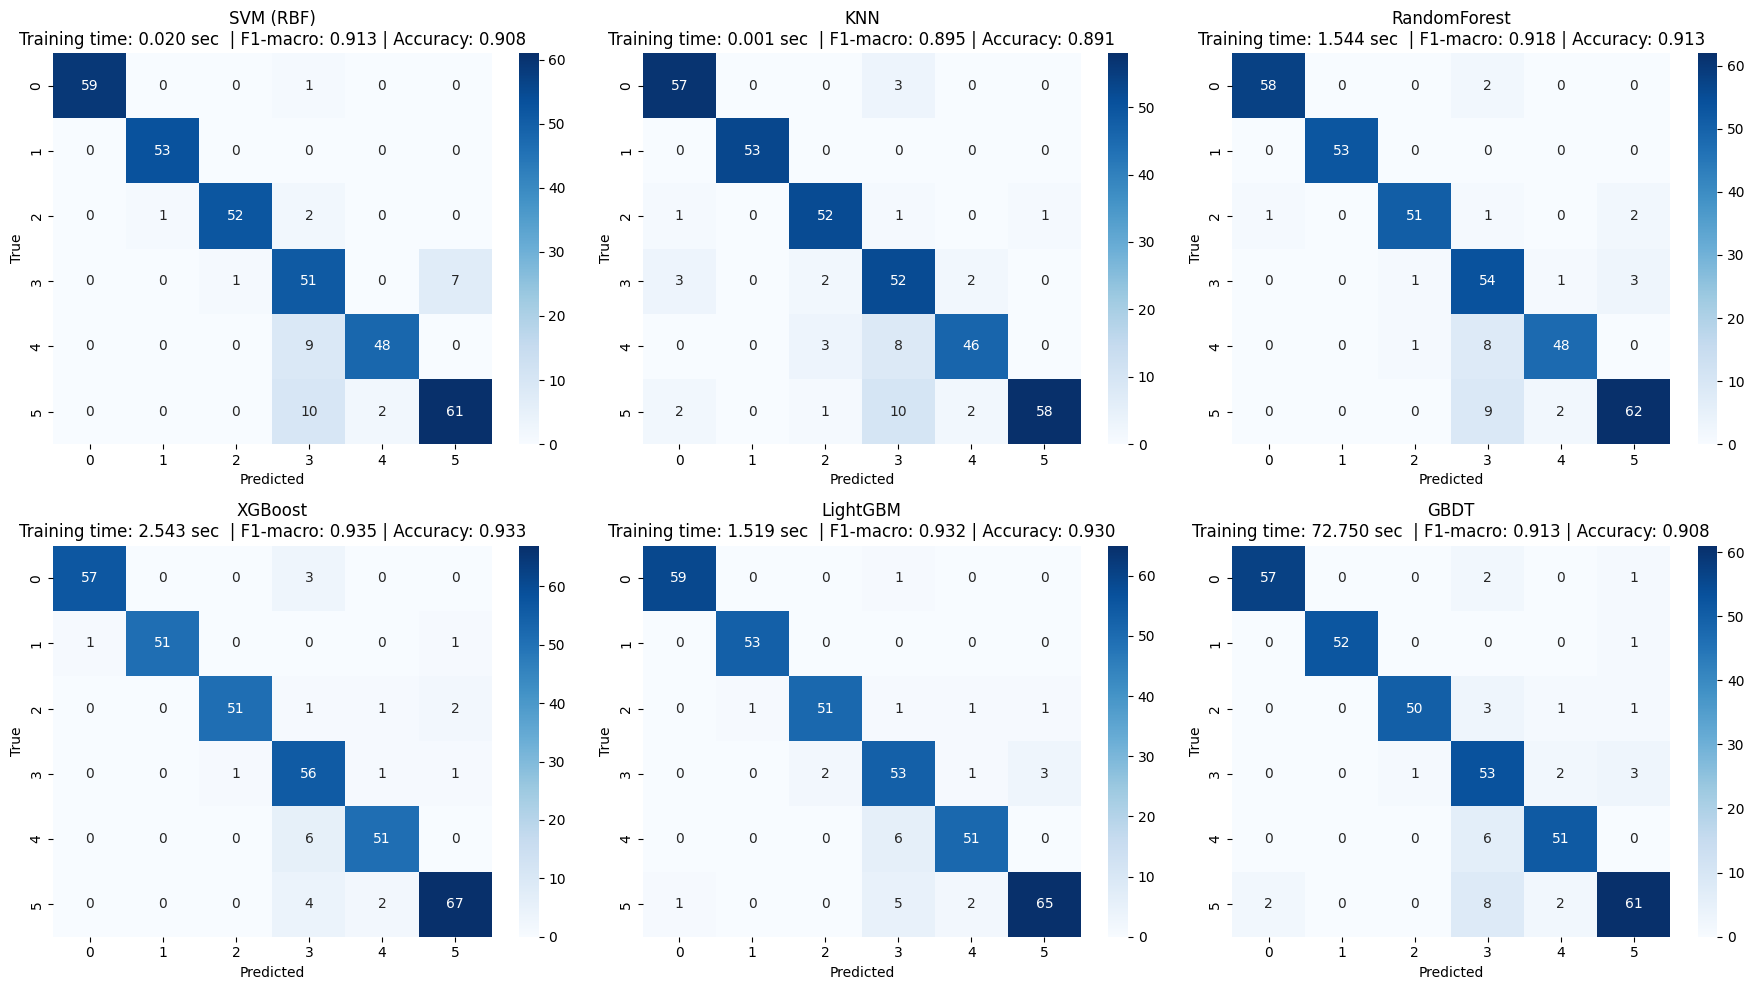


📁 Confusion matrices salvate in:Confusion_STD_features.png

📊 Summary of F1 Macro scores (+ training time):
          Model  F1_macro  Train_time_sec
3       XGBoost  0.934938        2.542673
4      LightGBM  0.932107        1.519293
2  RandomForest  0.917645        1.543592
0     SVM (RBF)  0.913398        0.020002
5          GBDT  0.912517       72.749790
1           KNN  0.894623        0.001216

📋 Full Classification Metrics Table (with training times):
           Model Class  Precision    Recall  F1-score  Support  Train_time_sec
0      SVM (RBF)     0   1.000000  0.983333  0.991597     60.0        0.020002
1      SVM (RBF)     1   0.981481  1.000000  0.990654     53.0        0.020002
2      SVM (RBF)     2   0.981132  0.945455  0.962963     55.0        0.020002
3      SVM (RBF)     3   0.698630  0.864407  0.772727     59.0        0.020002
4      SVM (RBF)     4   0.960000  0.842105  0.897196     57.0        0.020002
5      SVM (RBF)     5   0.897059  0.835616  0.865248     73.0 

c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:00:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7694
[LightGBM] [Info] Number of data points in the train set: 833, number of used features: 208
[LightGBM] [Info] Start training from score -1.790560
[LightGBM] [Info] Start training from score -1.888752
[LightGBM] [Info] Start training from score -1.865221
[LightGBM] [Info] Start training from score -1.805053
[LightGBM] [Info] Start training from score -1.842232
[LightGBM] [Info] Start training from score -1.589235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


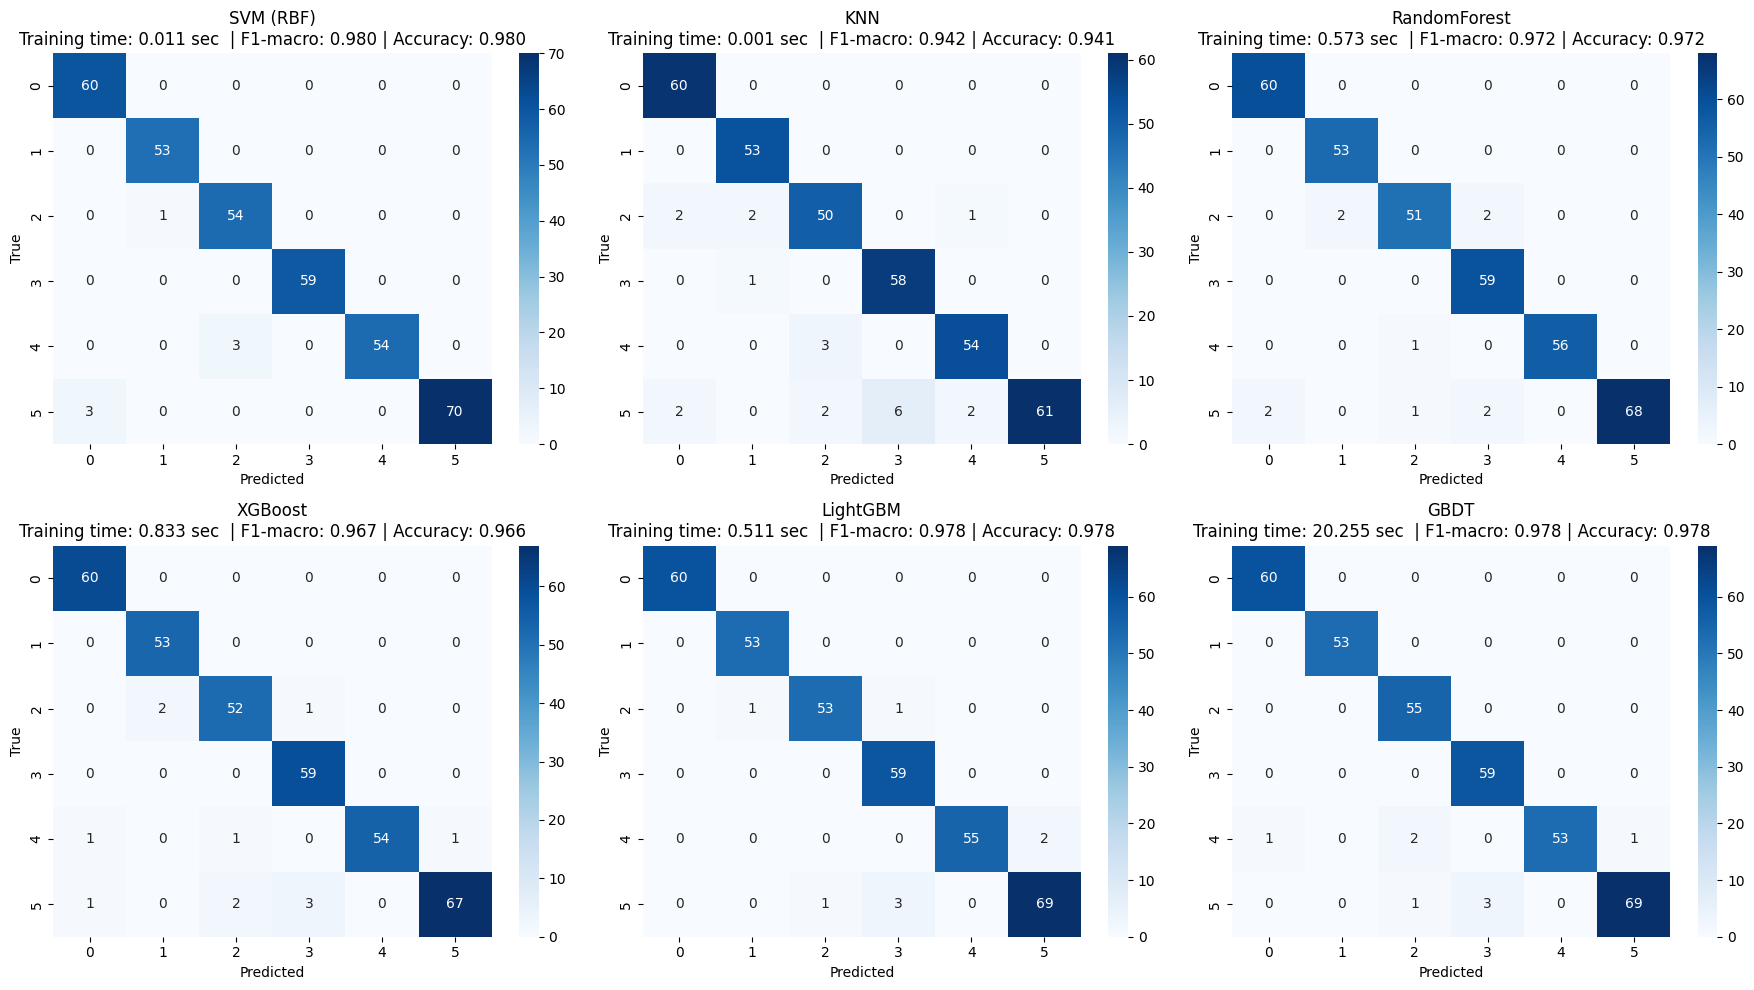


📁 Confusion matrices salvate in:Confusion_MIN_features.png

📊 Summary of F1 Macro scores (+ training time):
          Model  F1_macro  Train_time_sec
0     SVM (RBF)  0.980424        0.011373
4      LightGBM  0.978470        0.511293
5          GBDT  0.978177       20.255427
2  RandomForest  0.972073        0.572813
3       XGBoost  0.966847        0.833246
1           KNN  0.941703        0.001156

📋 Full Classification Metrics Table (with training times):
           Model Class  Precision    Recall  F1-score  Support  Train_time_sec
0      SVM (RBF)     0   0.952381  1.000000  0.975610     60.0        0.011373
1      SVM (RBF)     1   0.981481  1.000000  0.990654     53.0        0.011373
2      SVM (RBF)     2   0.947368  0.981818  0.964286     55.0        0.011373
3      SVM (RBF)     3   1.000000  1.000000  1.000000     59.0        0.011373
4      SVM (RBF)     4   1.000000  0.947368  0.972973     57.0        0.011373
5      SVM (RBF)     5   1.000000  0.958904  0.979021     73.0 

c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:01:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11684
[LightGBM] [Info] Number of data points in the train set: 833, number of used features: 208
[LightGBM] [Info] Start training from score -1.790560
[LightGBM] [Info] Start training from score -1.888752
[LightGBM] [Info] Start training from score -1.865221
[LightGBM] [Info] Start training from score -1.805053
[LightGBM] [Info] Start training from score -1.842232
[LightGBM] [Info] Start training from score -1.589235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


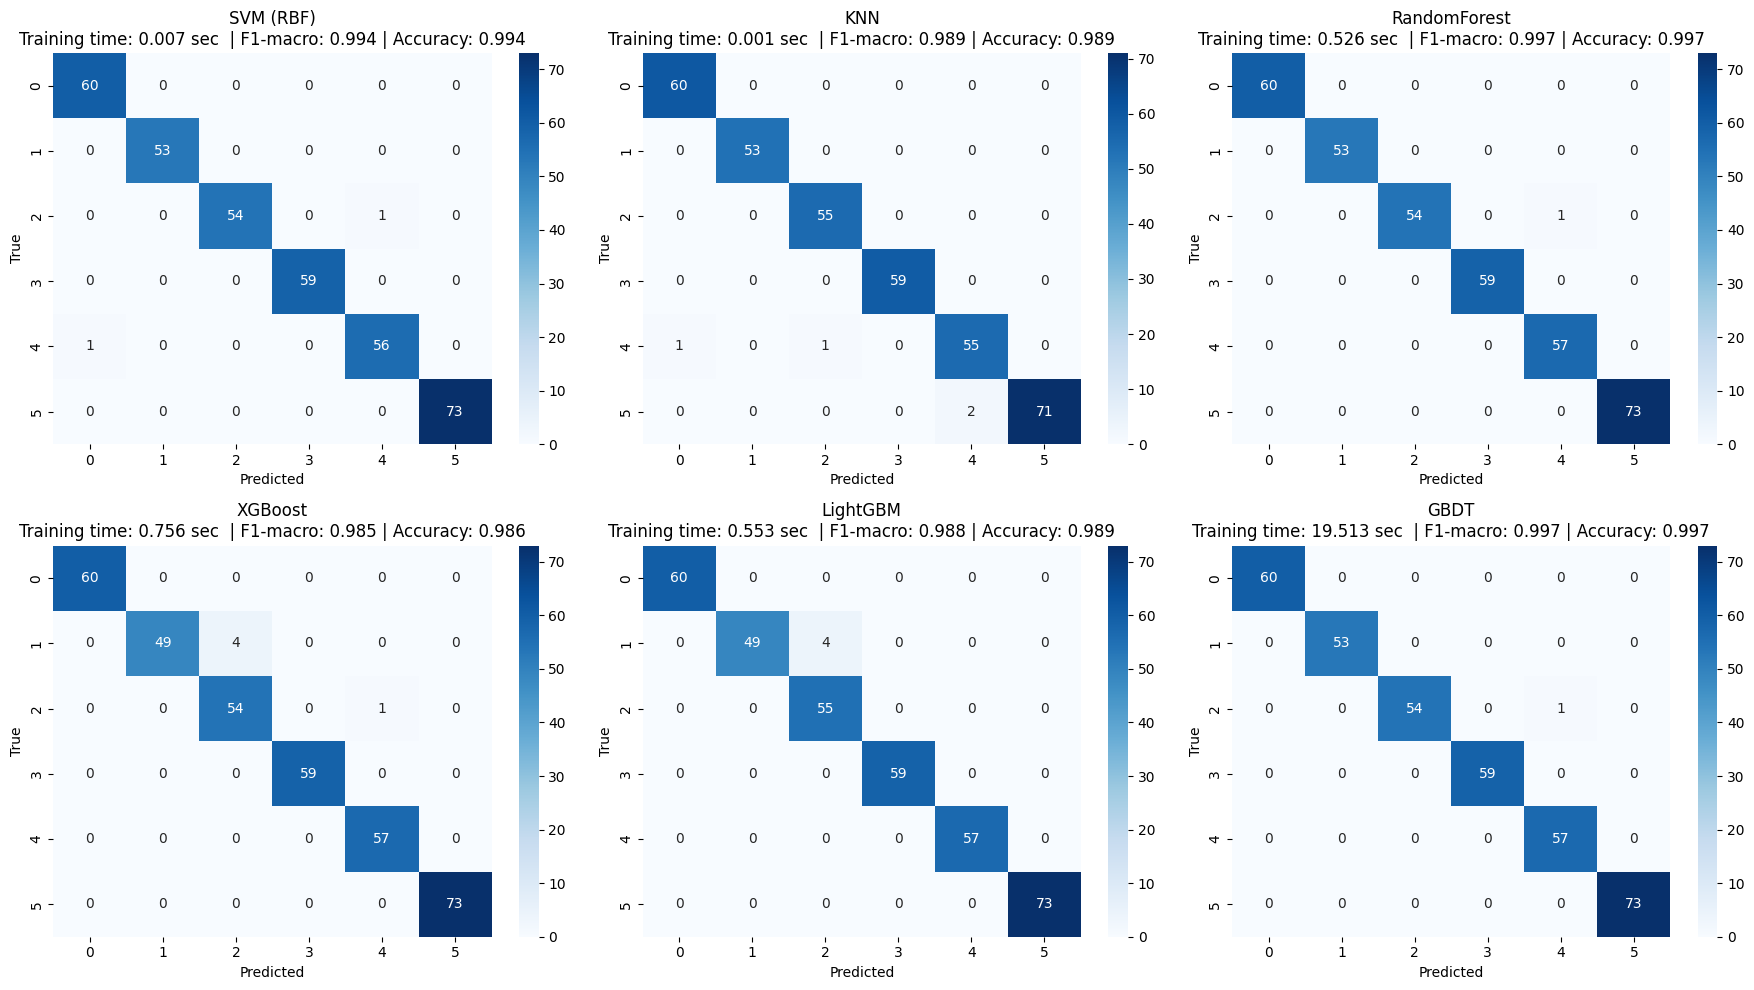


📁 Confusion matrices salvate in:Confusion_MAX_features.png

📊 Summary of F1 Macro scores (+ training time):
          Model  F1_macro  Train_time_sec
5          GBDT  0.997022       19.513057
2  RandomForest  0.997022        0.526225
0     SVM (RBF)  0.994170        0.007065
1           KNN  0.988958        0.001035
4      LightGBM  0.987616        0.553495
3       XGBoost  0.984640        0.755751

📋 Full Classification Metrics Table (with training times):
           Model Class  Precision    Recall  F1-score  Support  Train_time_sec
0      SVM (RBF)     0   0.983607  1.000000  0.991736     60.0        0.007065
1      SVM (RBF)     1   1.000000  1.000000  1.000000     53.0        0.007065
2      SVM (RBF)     2   1.000000  0.981818  0.990826     55.0        0.007065
3      SVM (RBF)     3   1.000000  1.000000  1.000000     59.0        0.007065
4      SVM (RBF)     4   0.982456  0.982456  0.982456     57.0        0.007065
5      SVM (RBF)     5   1.000000  1.000000  1.000000     73.0 

c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:02:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10000
[LightGBM] [Info] Number of data points in the train set: 833, number of used features: 208
[LightGBM] [Info] Start training from score -1.790560
[LightGBM] [Info] Start training from score -1.888752
[LightGBM] [Info] Start training from score -1.865221
[LightGBM] [Info] Start training from score -1.805053
[LightGBM] [Info] Start training from score -1.842232
[LightGBM] [Info] Start training from score -1.589235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


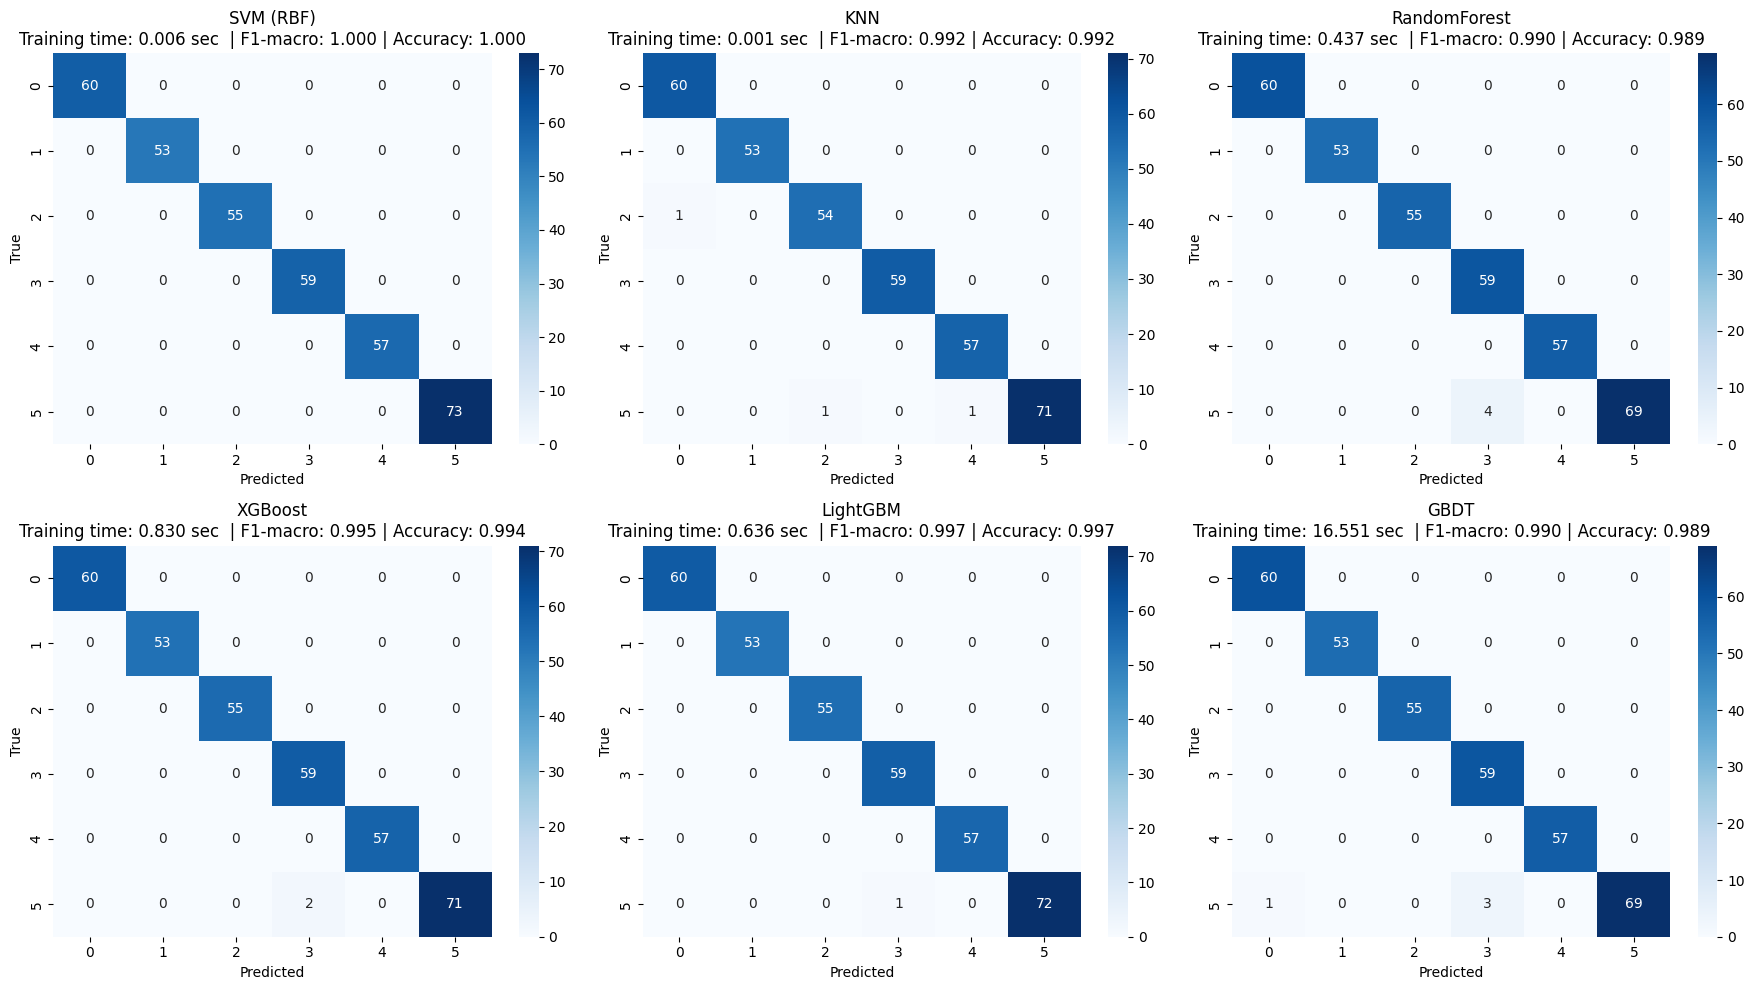


📁 Confusion matrices salvate in:Confusion_QTL_features.png

📊 Summary of F1 Macro scores (+ training time):
          Model  F1_macro  Train_time_sec
0     SVM (RBF)  1.000000        0.005629
4      LightGBM  0.997450        0.636447
3       XGBoost  0.994907        0.830127
1           KNN  0.991828        0.001025
2  RandomForest  0.989841        0.436566
5          GBDT  0.989796       16.550723

📋 Full Classification Metrics Table (with training times):
           Model Class  Precision    Recall  F1-score  Support  Train_time_sec
0      SVM (RBF)     0   1.000000  1.000000  1.000000     60.0        0.005629
1      SVM (RBF)     1   1.000000  1.000000  1.000000     53.0        0.005629
2      SVM (RBF)     2   1.000000  1.000000  1.000000     55.0        0.005629
3      SVM (RBF)     3   1.000000  1.000000  1.000000     59.0        0.005629
4      SVM (RBF)     4   1.000000  1.000000  1.000000     57.0        0.005629
5      SVM (RBF)     5   1.000000  1.000000  1.000000     73.0 

c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:02:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10842
[LightGBM] [Info] Number of data points in the train set: 833, number of used features: 208
[LightGBM] [Info] Start training from score -1.790560
[LightGBM] [Info] Start training from score -1.888752
[LightGBM] [Info] Start training from score -1.865221
[LightGBM] [Info] Start training from score -1.805053
[LightGBM] [Info] Start training from score -1.842232
[LightGBM] [Info] Start training from score -1.589235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


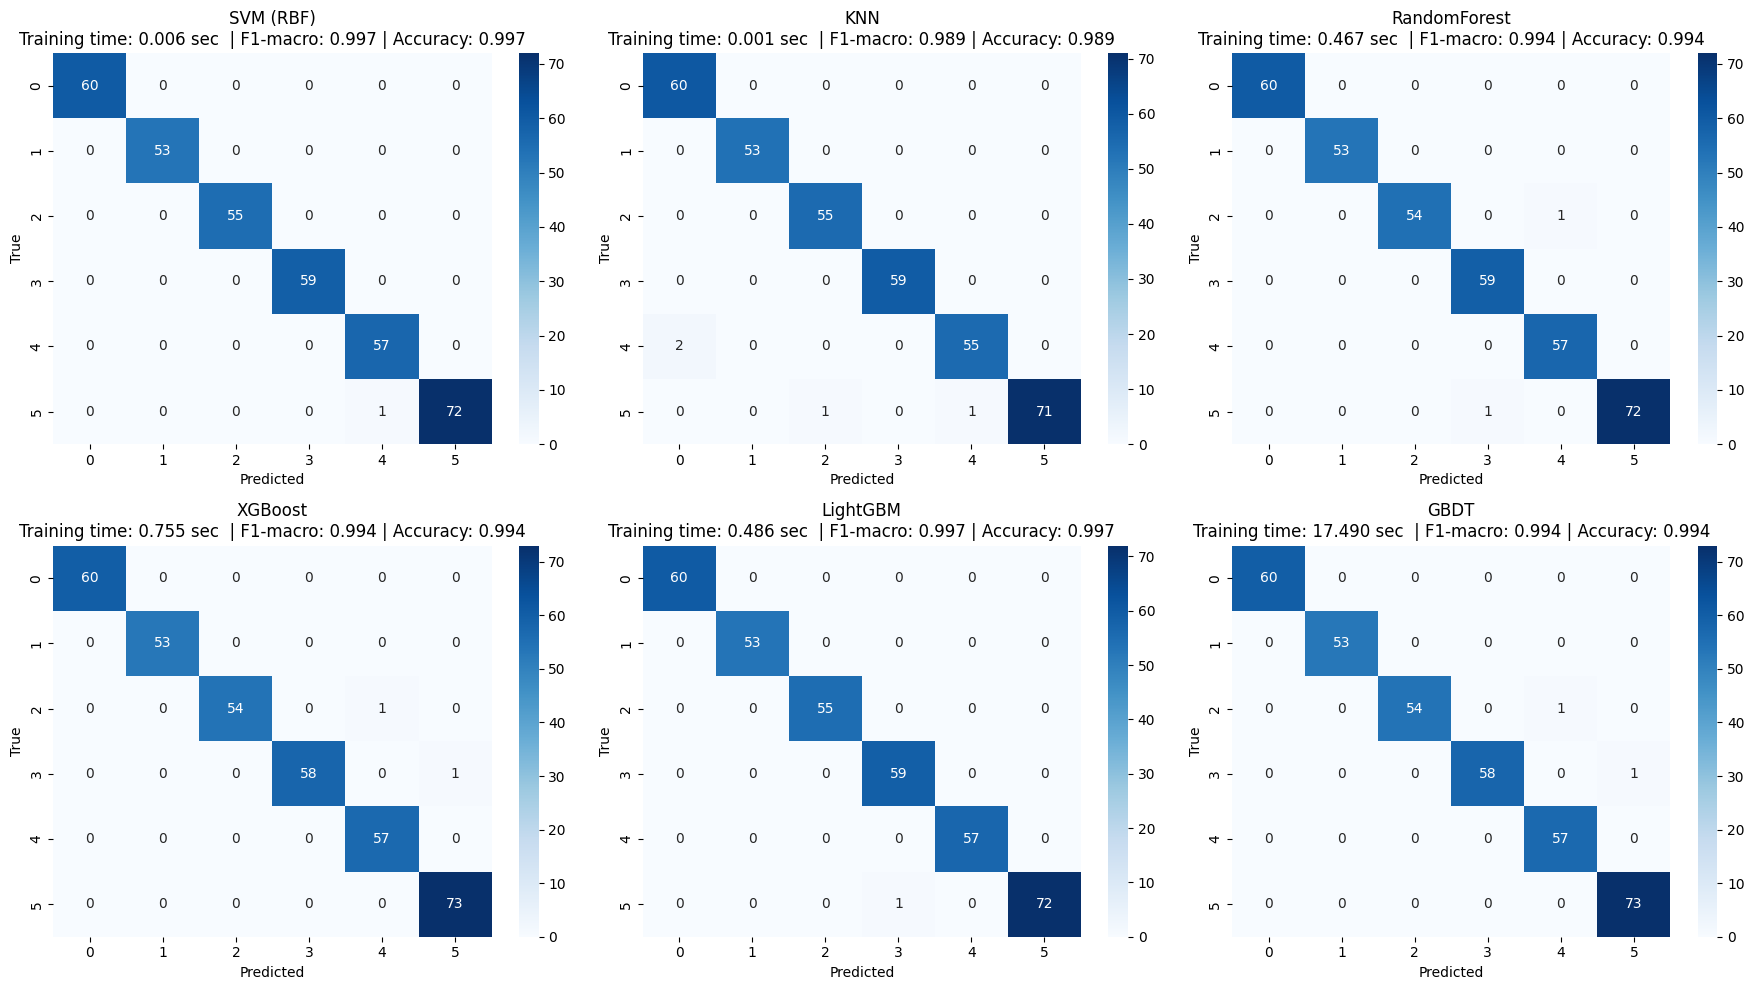


📁 Confusion matrices salvate in:Confusion_QTU_features.png

📊 Summary of F1 Macro scores (+ training time):
          Model  F1_macro  Train_time_sec
4      LightGBM  0.997450        0.486107
0     SVM (RBF)  0.997401        0.006066
2  RandomForest  0.994472        0.467287
3       XGBoost  0.994463        0.754794
5          GBDT  0.994463       17.489984
1           KNN  0.989027        0.001245

📋 Full Classification Metrics Table (with training times):
           Model Class  Precision    Recall  F1-score  Support  Train_time_sec
0      SVM (RBF)     0   1.000000  1.000000  1.000000     60.0        0.006066
1      SVM (RBF)     1   1.000000  1.000000  1.000000     53.0        0.006066
2      SVM (RBF)     2   1.000000  1.000000  1.000000     55.0        0.006066
3      SVM (RBF)     3   1.000000  1.000000  1.000000     59.0        0.006066
4      SVM (RBF)     4   0.982759  1.000000  0.991304     57.0        0.006066
5      SVM (RBF)     5   1.000000  0.986301  0.993103     73.0 

c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:02:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 53040
[LightGBM] [Info] Number of data points in the train set: 833, number of used features: 208
[LightGBM] [Info] Start training from score -1.790560
[LightGBM] [Info] Start training from score -1.888752
[LightGBM] [Info] Start training from score -1.865221
[LightGBM] [Info] Start training from score -1.805053
[LightGBM] [Info] Start training from score -1.842232
[LightGBM] [Info] Start training from score -1.589235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


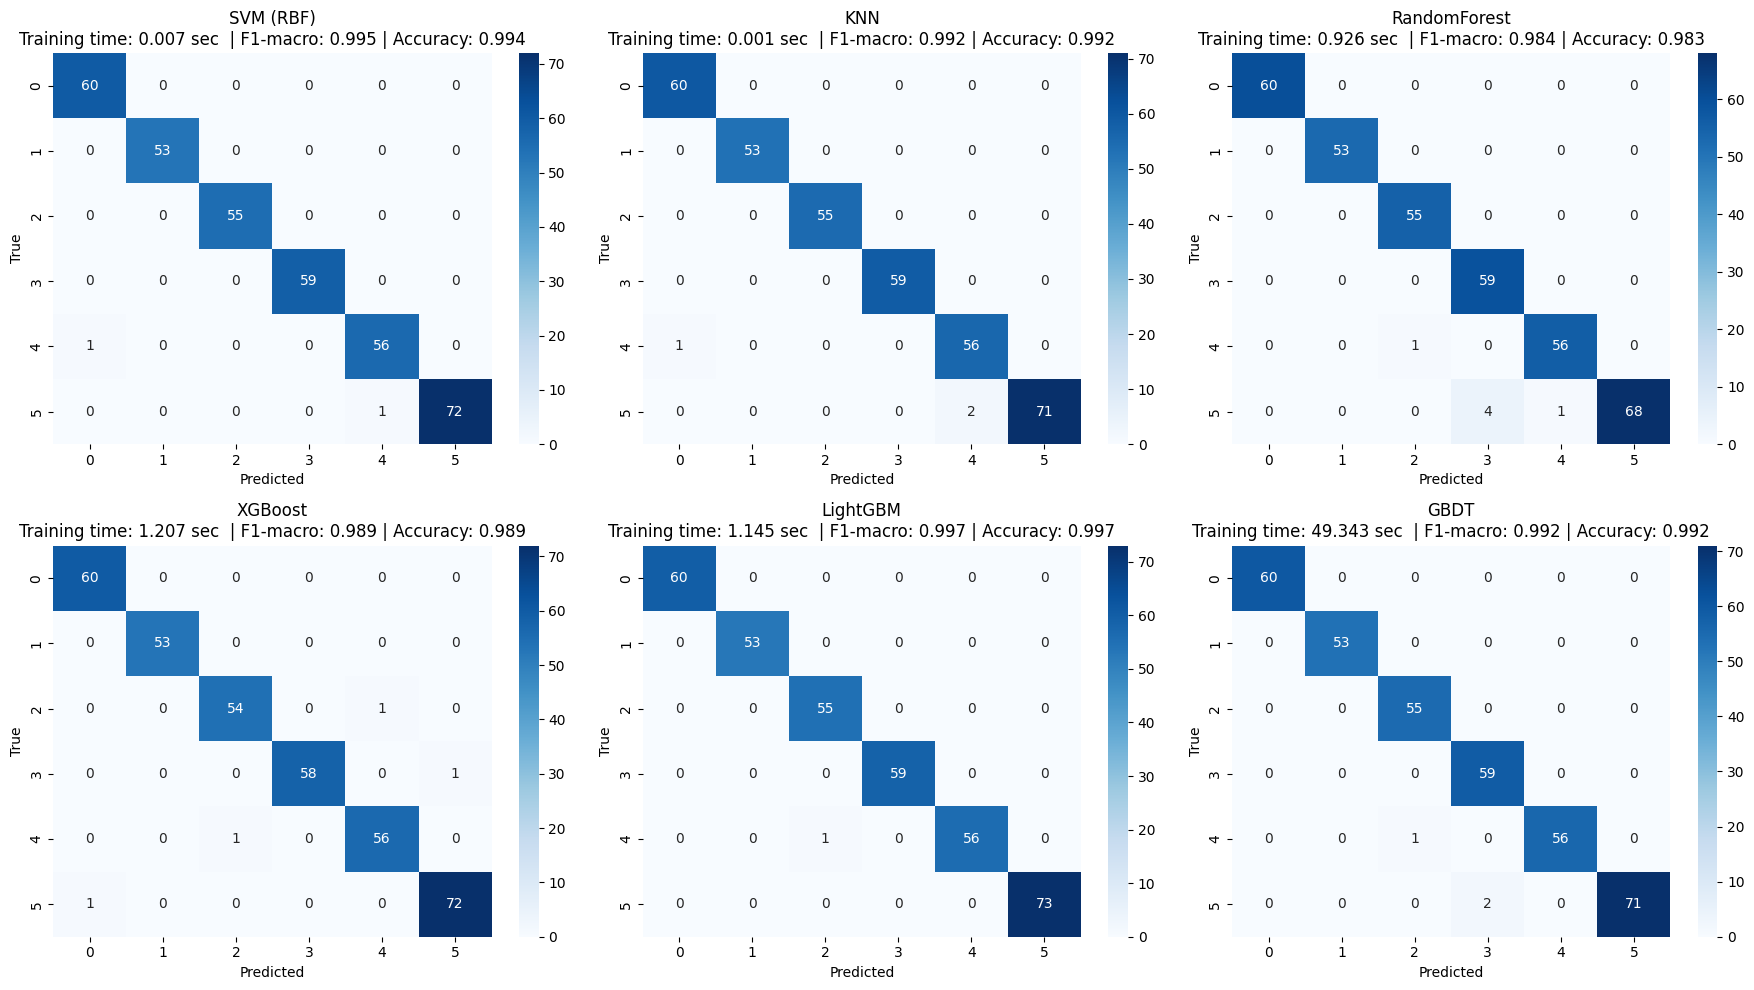


📁 Confusion matrices salvate in:Confusion_AVG_features.png

📊 Summary of F1 Macro scores (+ training time):
          Model  F1_macro  Train_time_sec
4      LightGBM  0.997024        1.144658
0     SVM (RBF)  0.994549        0.006878
1           KNN  0.991960        0.000854
5          GBDT  0.991931       49.342733
3       XGBoost  0.988961        1.206561
2  RandomForest  0.984200        0.926087

📋 Full Classification Metrics Table (with training times):
           Model Class  Precision    Recall  F1-score  Support  Train_time_sec
0      SVM (RBF)     0   0.983607  1.000000  0.991736     60.0        0.006878
1      SVM (RBF)     1   1.000000  1.000000  1.000000     53.0        0.006878
2      SVM (RBF)     2   1.000000  1.000000  1.000000     55.0        0.006878
3      SVM (RBF)     3   1.000000  1.000000  1.000000     59.0        0.006878
4      SVM (RBF)     4   0.982456  0.982456  0.982456     57.0        0.006878
5      SVM (RBF)     5   1.000000  0.986301  0.993103     73.0 

c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:03:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27226
[LightGBM] [Info] Number of data points in the train set: 833, number of used features: 208
[LightGBM] [Info] Start training from score -1.790560
[LightGBM] [Info] Start training from score -1.888752
[LightGBM] [Info] Start training from score -1.865221
[LightGBM] [Info] Start training from score -1.805053
[LightGBM] [Info] Start training from score -1.842232
[LightGBM] [Info] Start training from score -1.589235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


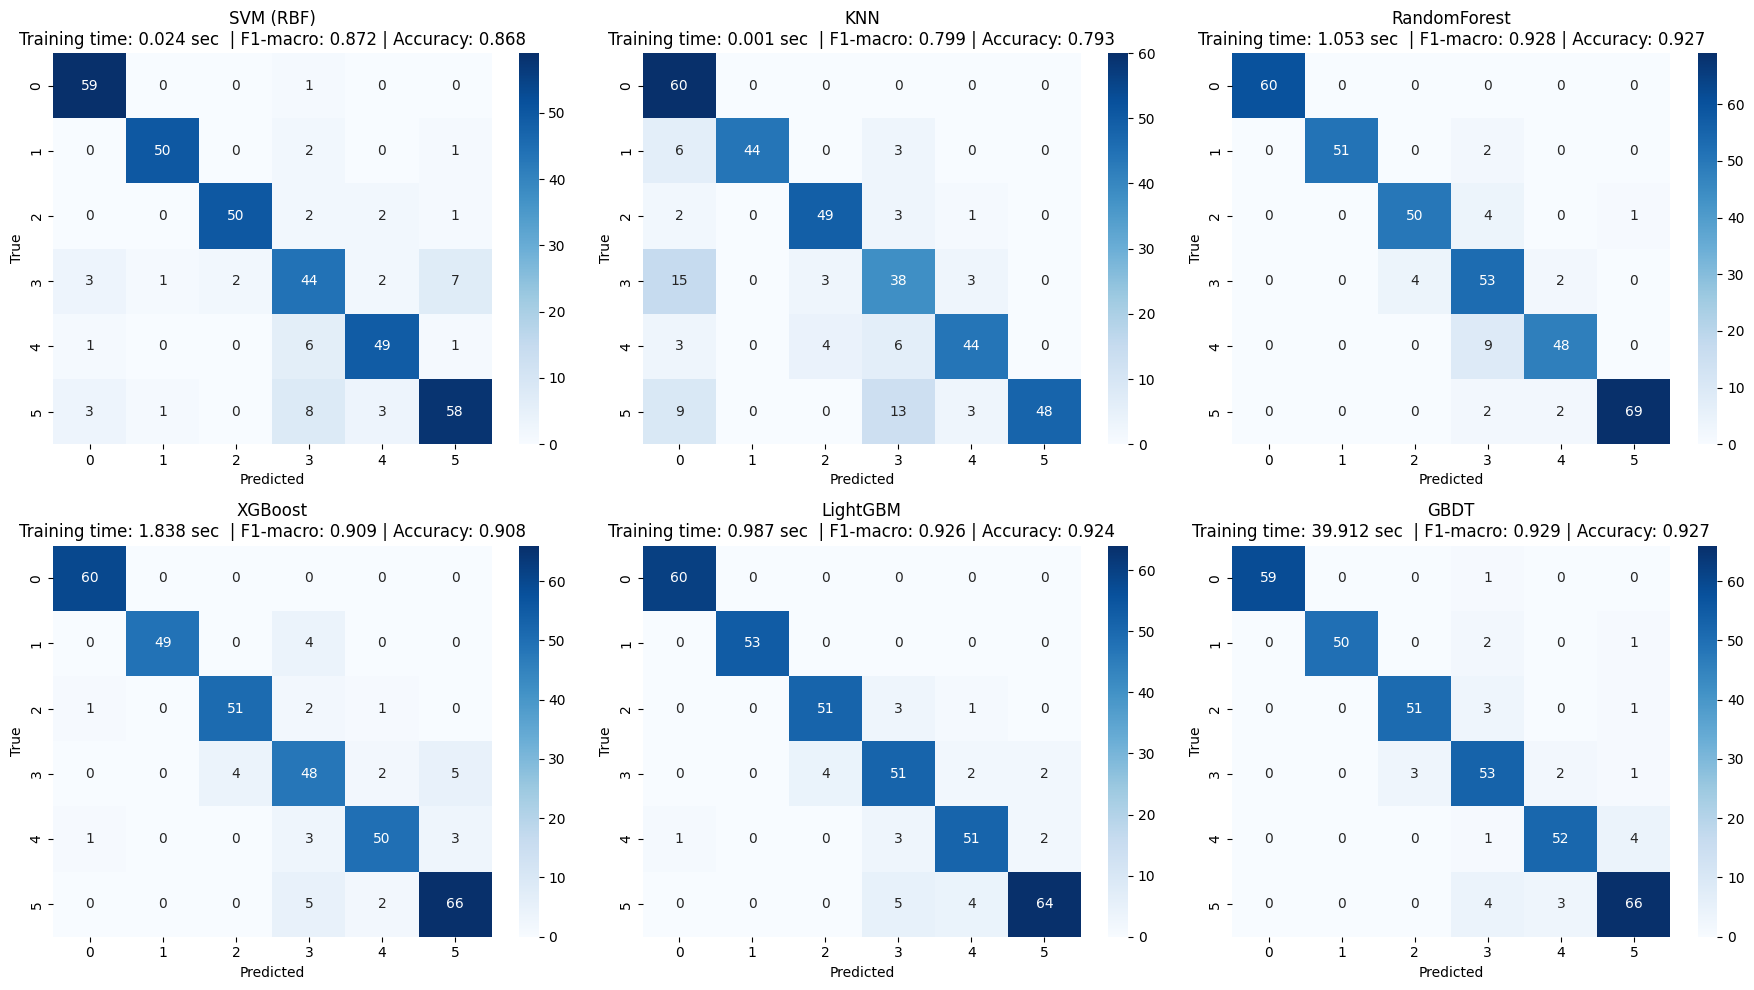


📁 Confusion matrices salvate in:Confusion_IQR_features.png

📊 Summary of F1 Macro scores (+ training time):
          Model  F1_macro  Train_time_sec
5          GBDT  0.929405       39.912340
2  RandomForest  0.927612        1.053151
4      LightGBM  0.926124        0.986865
3       XGBoost  0.909311        1.837540
0     SVM (RBF)  0.872455        0.024296
1           KNN  0.799241        0.001407

📋 Full Classification Metrics Table (with training times):
           Model Class  Precision    Recall  F1-score  Support  Train_time_sec
0      SVM (RBF)     0   0.893939  0.983333  0.936508     60.0        0.024296
1      SVM (RBF)     1   0.961538  0.943396  0.952381     53.0        0.024296
2      SVM (RBF)     2   0.961538  0.909091  0.934579     55.0        0.024296
3      SVM (RBF)     3   0.698413  0.745763  0.721311     59.0        0.024296
4      SVM (RBF)     4   0.875000  0.859649  0.867257     57.0        0.024296
5      SVM (RBF)     5   0.852941  0.794521  0.822695     73.0 

c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:04:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 833, number of used features: 4
[LightGBM] [Info] Start training from score -1.790560
[LightGBM] [Info] Start training from score -1.888752
[LightGBM] [Info] Start training from score -1.865221
[LightGBM] [Info] Start training from score -1.805053
[LightGBM] [Info] Start training from score -1.842232
[LightGBM] [Info] Start training from score -1.589235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


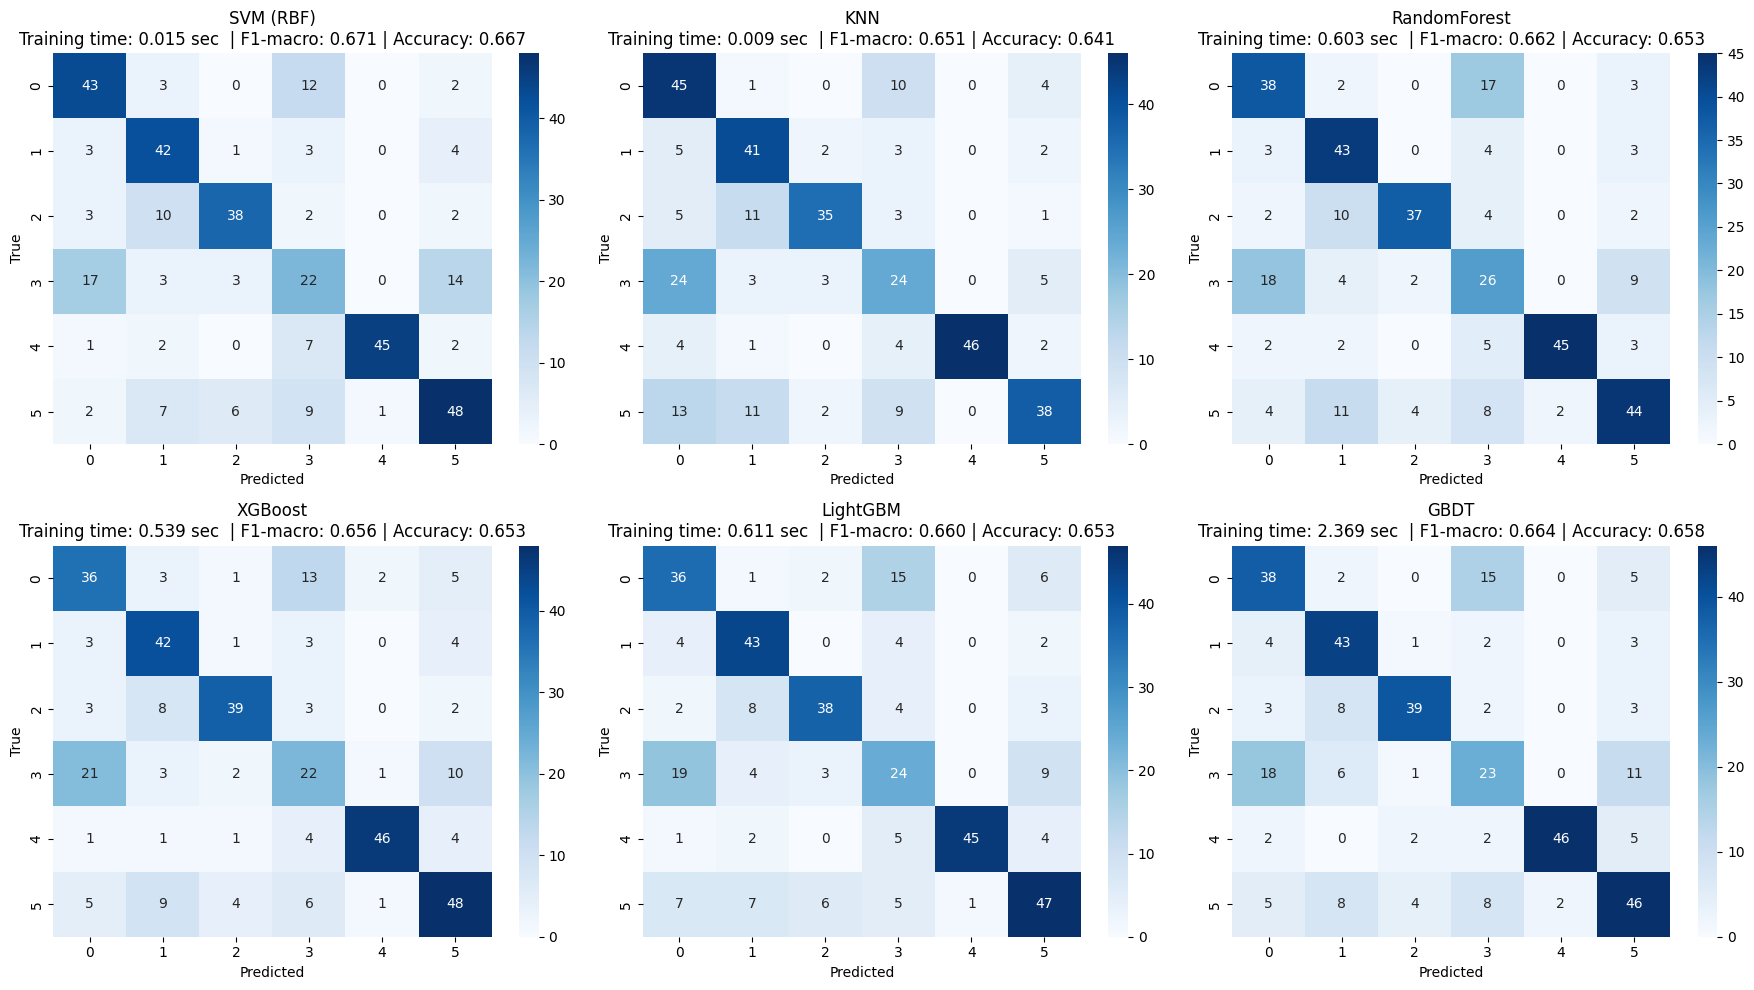


📁 Confusion matrices salvate in:Confusion_EUC_features.png

📊 Summary of F1 Macro scores (+ training time):
          Model  F1_macro  Train_time_sec
0     SVM (RBF)  0.671059        0.015186
5          GBDT  0.664455        2.369076
2  RandomForest  0.662002        0.603230
4      LightGBM  0.659680        0.611325
3       XGBoost  0.656442        0.538954
1           KNN  0.651006        0.009225

📋 Full Classification Metrics Table (with training times):
           Model Class  Precision    Recall  F1-score  Support  Train_time_sec
0      SVM (RBF)     0   0.623188  0.716667  0.666667     60.0        0.015186
1      SVM (RBF)     1   0.626866  0.792453  0.700000     53.0        0.015186
2      SVM (RBF)     2   0.791667  0.690909  0.737864     55.0        0.015186
3      SVM (RBF)     3   0.400000  0.372881  0.385965     59.0        0.015186
4      SVM (RBF)     4   0.978261  0.789474  0.873786     57.0        0.015186
5      SVM (RBF)     5   0.666667  0.657534  0.662069     73.0 

c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:04:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48960
[LightGBM] [Info] Number of data points in the train set: 833, number of used features: 192
[LightGBM] [Info] Start training from score -1.790560
[LightGBM] [Info] Start training from score -1.888752
[LightGBM] [Info] Start training from score -1.865221
[LightGBM] [Info] Start training from score -1.805053
[LightGBM] [Info] Start training from score -1.842232
[LightGBM] [Info] Start training from score -1.589235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


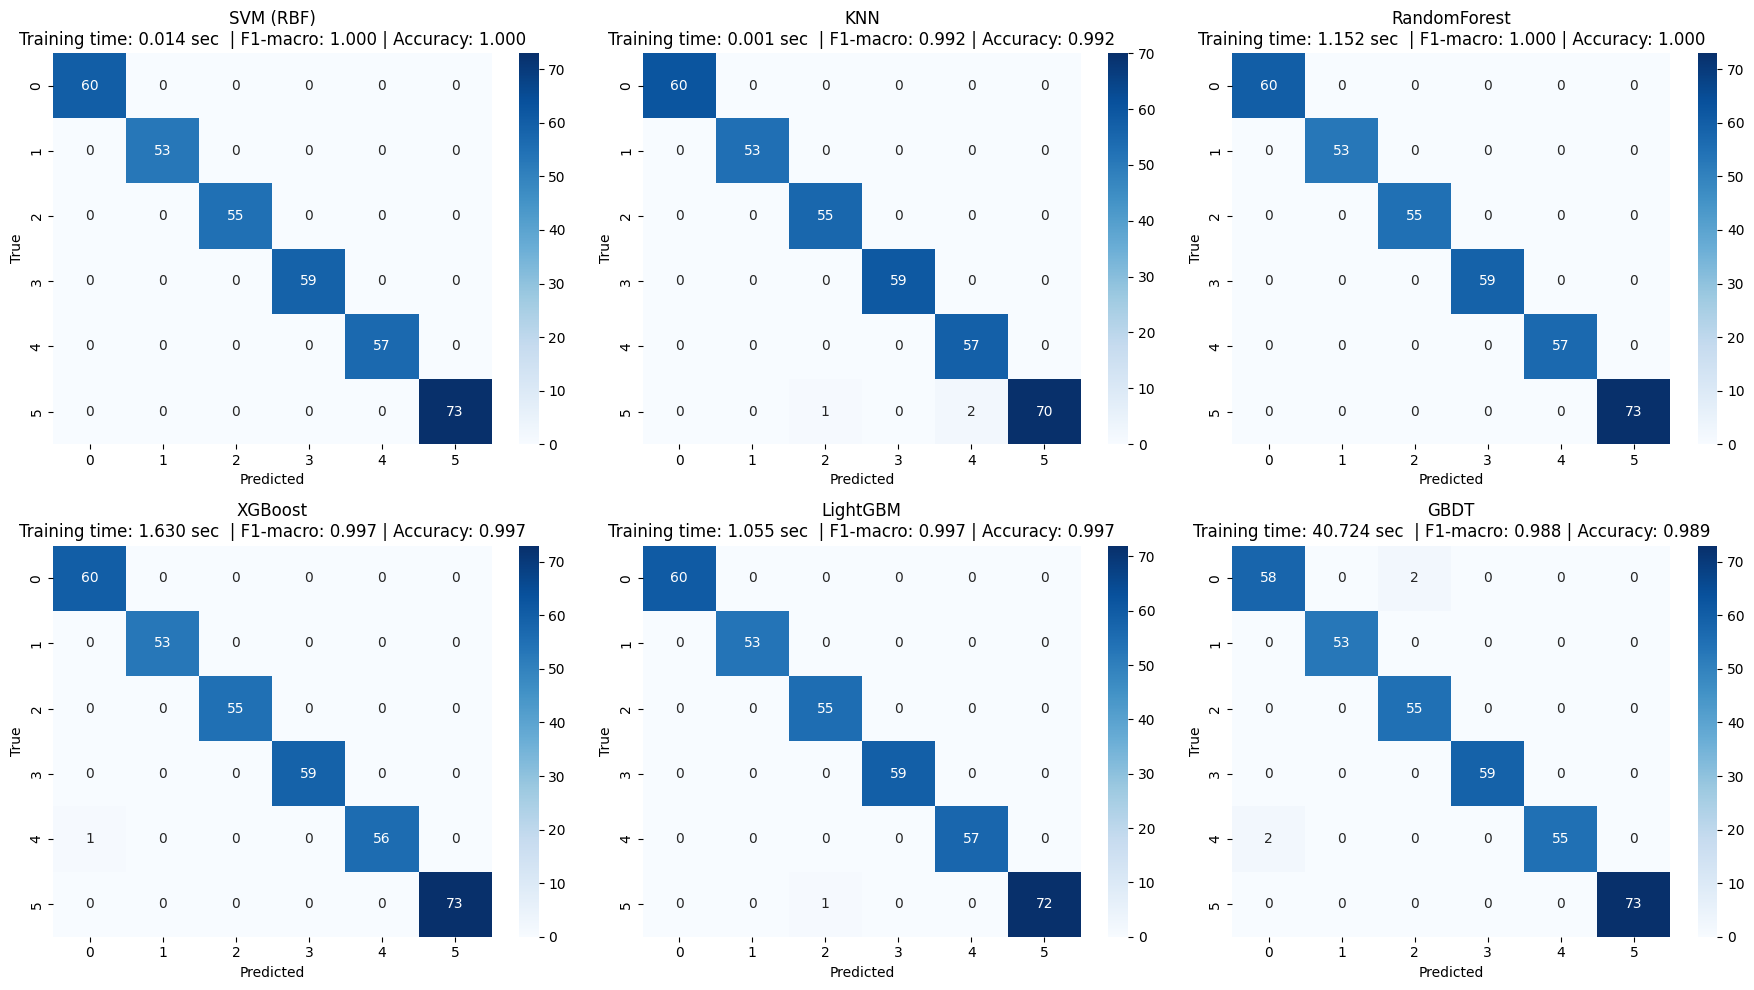


📁 Confusion matrices salvate in:Confusion_ADJ_features.png

📊 Summary of F1 Macro scores (+ training time):
          Model  F1_macro  Train_time_sec
0     SVM (RBF)  1.000000        0.013908
2  RandomForest  1.000000        1.151729
4      LightGBM  0.997349        1.055443
3       XGBoost  0.997148        1.630223
1           KNN  0.992128        0.001230
5          GBDT  0.988492       40.724478

📋 Full Classification Metrics Table (with training times):
           Model Class  Precision    Recall  F1-score  Support  Train_time_sec
0      SVM (RBF)     0   1.000000  1.000000  1.000000     60.0        0.013908
1      SVM (RBF)     1   1.000000  1.000000  1.000000     53.0        0.013908
2      SVM (RBF)     2   1.000000  1.000000  1.000000     55.0        0.013908
3      SVM (RBF)     3   1.000000  1.000000  1.000000     59.0        0.013908
4      SVM (RBF)     4   1.000000  1.000000  1.000000     57.0        0.013908
5      SVM (RBF)     5   1.000000  1.000000  1.000000     73.0 

In [121]:
results = []

for feat_name, feat_df in datasets_lltf.items():  # Usa il dizionario!
    X_cols = [c for c in feat_df.columns if c != 'target']
    df = feat_df[X_cols + ['target']]

    print(f"\nTesting feature set: {feat_name}")
    f1_df, metrics_df = train_classifiers_2(df, target_col="target", titolo_suffix=f"Confusion_{feat_name.replace(' ', '_')}")
    best = f1_df.iloc[0]
    worst = f1_df.iloc[-1]
    results.append({
        "feature_group": feat_name,
        "best_model": best["Model"],
        "best_f1_macro": best["F1_macro"],
        "best_time": best["Train_time_sec"],
        "worst_model": worst["Model"],
        "worst_f1_macro": worst["F1_macro"],
        "worst_time": worst["Train_time_sec"]
    })

results_df = pd.DataFrame(results)
print(results_df)


In [125]:
def expand_df_of_lists(df, feature_prefix=None):
    # Trova tutte le colonne tranne il target
    feature_cols = [c for c in df.columns if c != 'target']
    expanded_cols = []
    for col in feature_cols:
        expanded = pd.DataFrame(df[col].tolist())
        if feature_prefix:
            expanded = expanded.add_prefix(f"{feature_prefix}_{col}_")
        else:
            expanded = expanded.add_prefix(f"{col}_")
        expanded_cols.append(expanded)
    res = pd.concat(expanded_cols, axis=1)
    res['target'] = df['target'].values
    return res

# Sostituisci nel dizionario tutti i DataFrame con quelli espansi
for k in datasets_htltf:
    datasets_htltf[k] = expand_df_of_lists(datasets_htltf[k], feature_prefix=k.replace(" features","").lower())



Testing feature set: STD features


c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:10:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 110160
[LightGBM] [Info] Number of data points in the train set: 847, number of used features: 432
[LightGBM] [Info] Start training from score -1.711263
[LightGBM] [Info] Start training from score -1.913387
[LightGBM] [Info] Start training from score -1.881888
[LightGBM] [Info] Start training from score -1.821720
[LightGBM] [Info] Start training from score -1.851352
[LightGBM] [Info] Start training from score -1.605902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


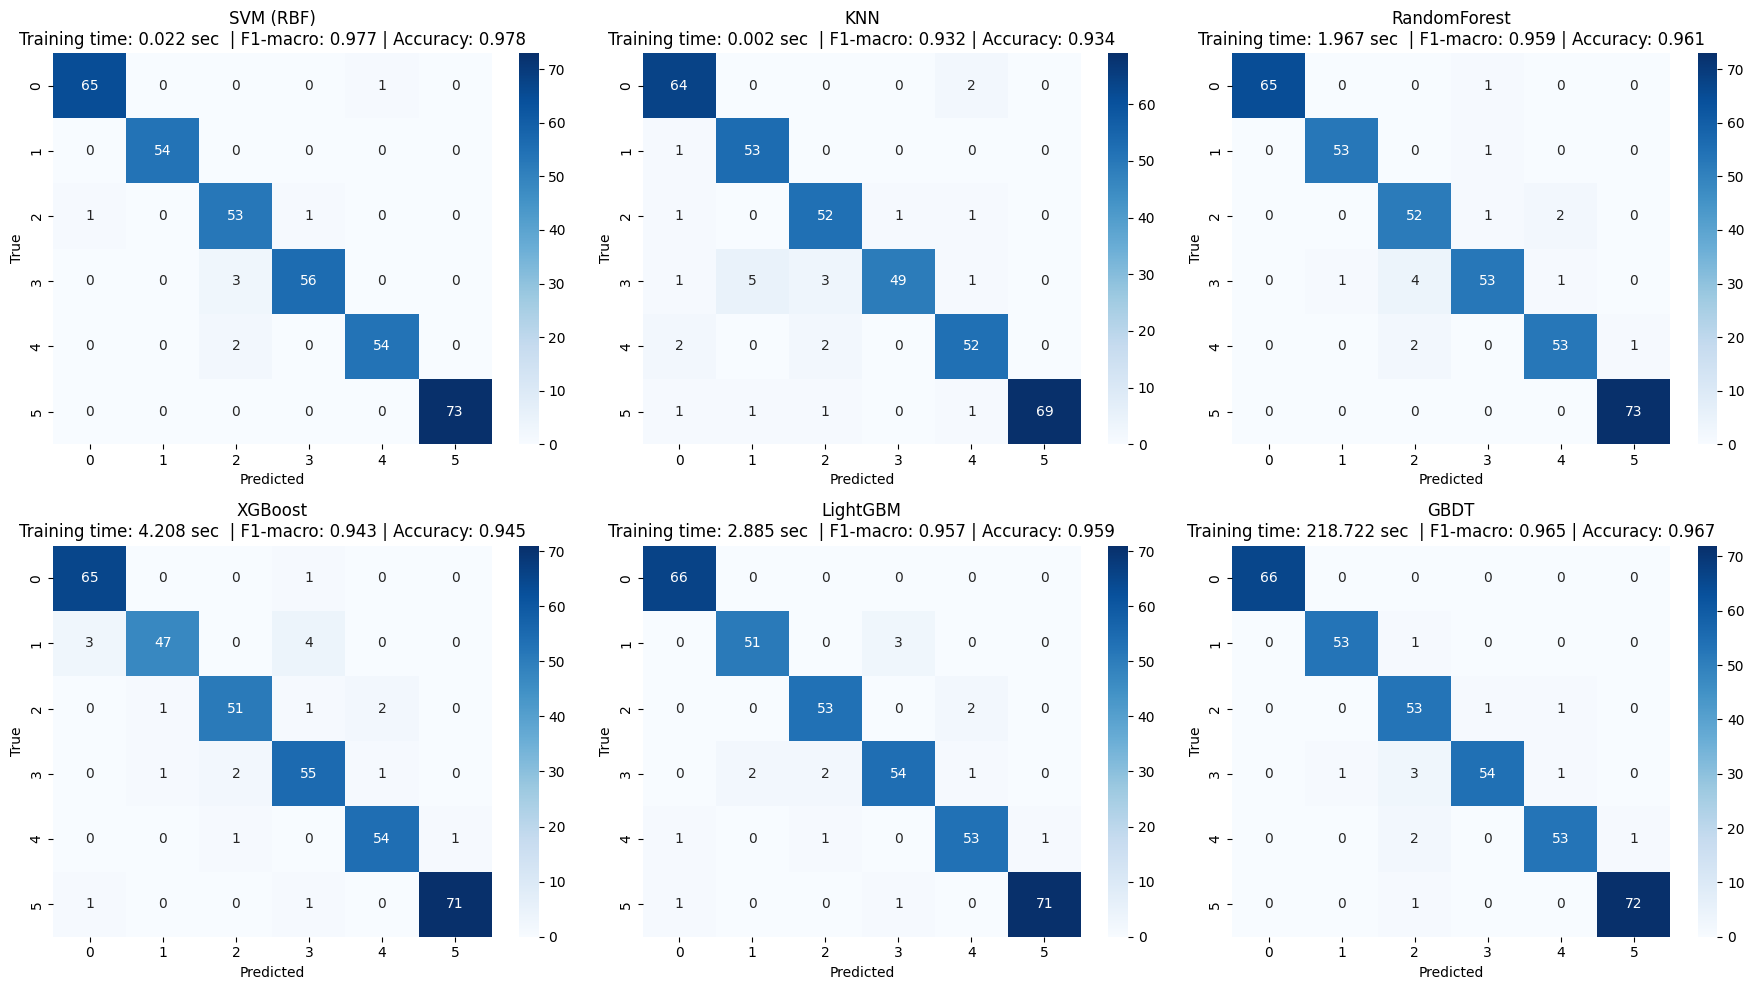


📁 Confusion matrices salvate in:Confusion_HTLTFSTD_features.png

📊 Summary of F1 Macro scores (+ training time):
          Model  F1_macro  Train_time_sec
0     SVM (RBF)  0.976899        0.021799
5          GBDT  0.965308      218.721569
2  RandomForest  0.959261        1.967354
4      LightGBM  0.957019        2.884836
3       XGBoost  0.942586        4.208051
1           KNN  0.931809        0.001922

📋 Full Classification Metrics Table (with training times):
           Model Class  Precision    Recall  F1-score  Support  Train_time_sec
0      SVM (RBF)     0   0.984848  0.984848  0.984848     66.0        0.021799
1      SVM (RBF)     1   1.000000  1.000000  1.000000     54.0        0.021799
2      SVM (RBF)     2   0.913793  0.963636  0.938053     55.0        0.021799
3      SVM (RBF)     3   0.982456  0.949153  0.965517     59.0        0.021799
4      SVM (RBF)     4   0.981818  0.964286  0.972973     56.0        0.021799
5      SVM (RBF)     5   1.000000  1.000000  1.000000     

c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:14:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 104586
[LightGBM] [Info] Number of data points in the train set: 847, number of used features: 432
[LightGBM] [Info] Start training from score -1.711263
[LightGBM] [Info] Start training from score -1.913387
[LightGBM] [Info] Start training from score -1.881888
[LightGBM] [Info] Start training from score -1.821720
[LightGBM] [Info] Start training from score -1.851352
[LightGBM] [Info] Start training from score -1.605902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


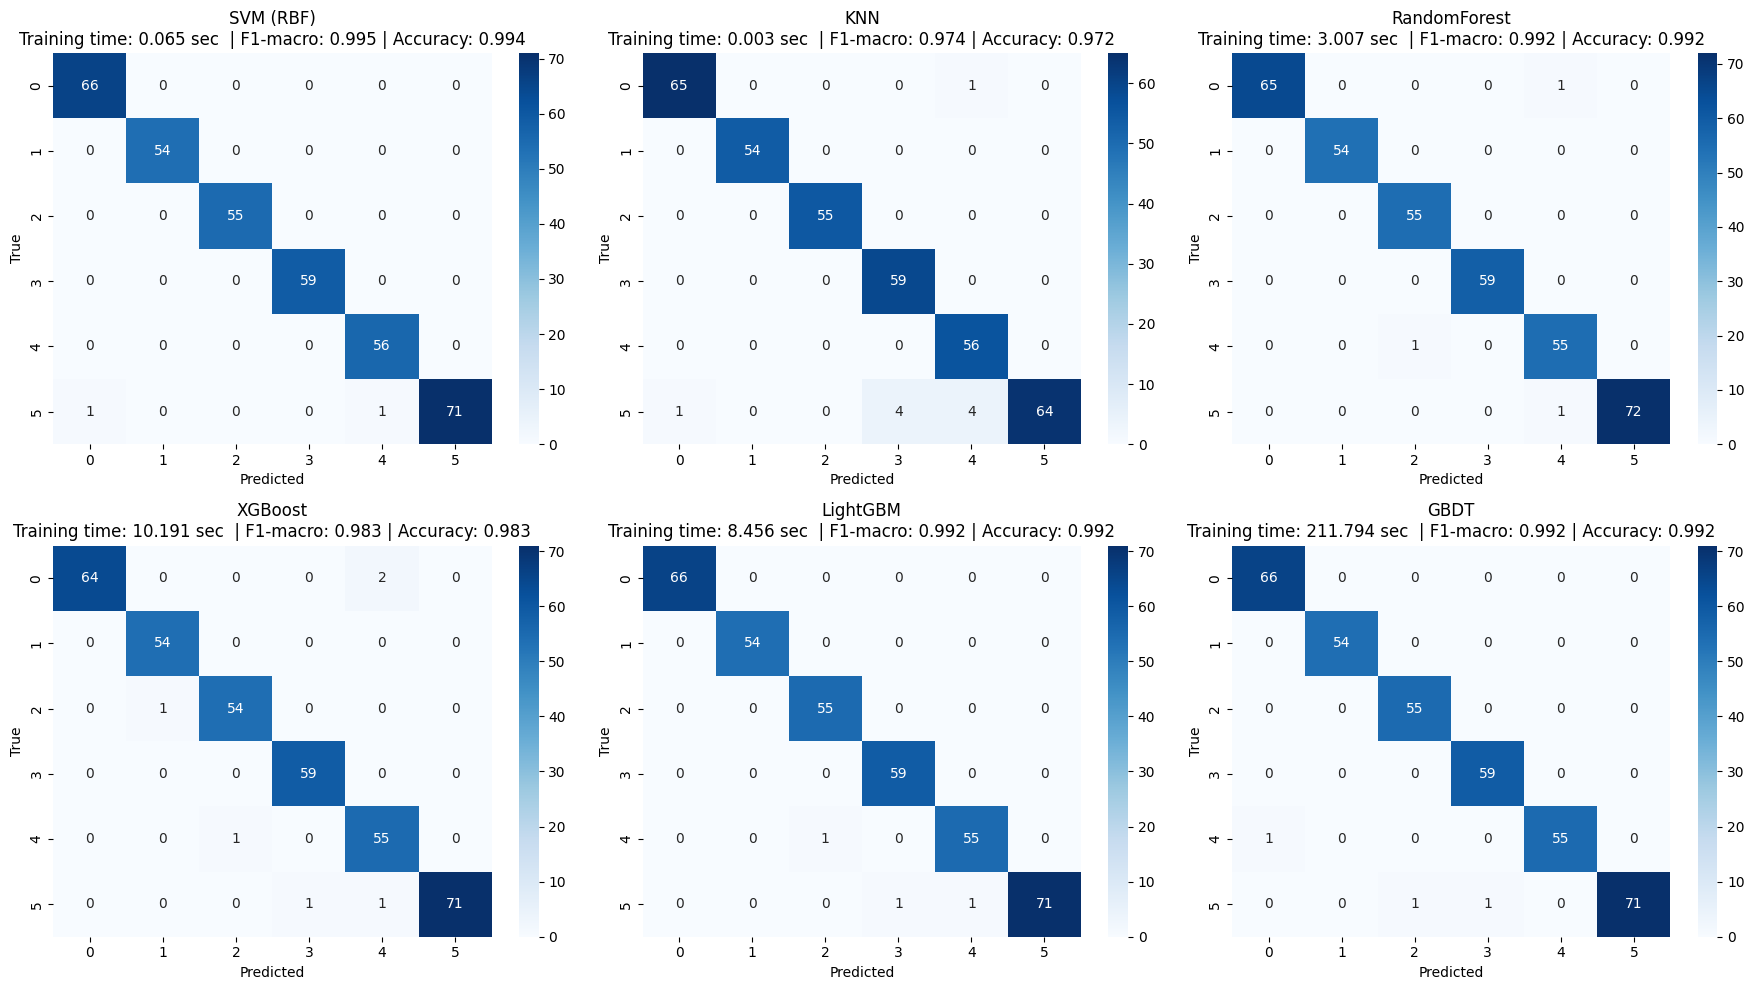


📁 Confusion matrices salvate in:Confusion_HTLTFMIN_features.png

📊 Summary of F1 Macro scores (+ training time):
          Model  F1_macro  Train_time_sec
0     SVM (RBF)  0.994957        0.064894
5          GBDT  0.992028      211.793928
4      LightGBM  0.991807        8.456290
2  RandomForest  0.991652        3.007202
3       XGBoost  0.983313       10.190711
1           KNN  0.973939        0.003294

📋 Full Classification Metrics Table (with training times):
           Model Class  Precision    Recall  F1-score  Support  Train_time_sec
0      SVM (RBF)     0   0.985075  1.000000  0.992481     66.0        0.064894
1      SVM (RBF)     1   1.000000  1.000000  1.000000     54.0        0.064894
2      SVM (RBF)     2   1.000000  1.000000  1.000000     55.0        0.064894
3      SVM (RBF)     3   1.000000  1.000000  1.000000     59.0        0.064894
4      SVM (RBF)     4   0.982456  1.000000  0.991150     56.0        0.064894
5      SVM (RBF)     5   1.000000  0.972603  0.986111     

c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:18:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 109006
[LightGBM] [Info] Number of data points in the train set: 847, number of used features: 432
[LightGBM] [Info] Start training from score -1.711263
[LightGBM] [Info] Start training from score -1.913387
[LightGBM] [Info] Start training from score -1.881888
[LightGBM] [Info] Start training from score -1.821720
[LightGBM] [Info] Start training from score -1.851352
[LightGBM] [Info] Start training from score -1.605902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


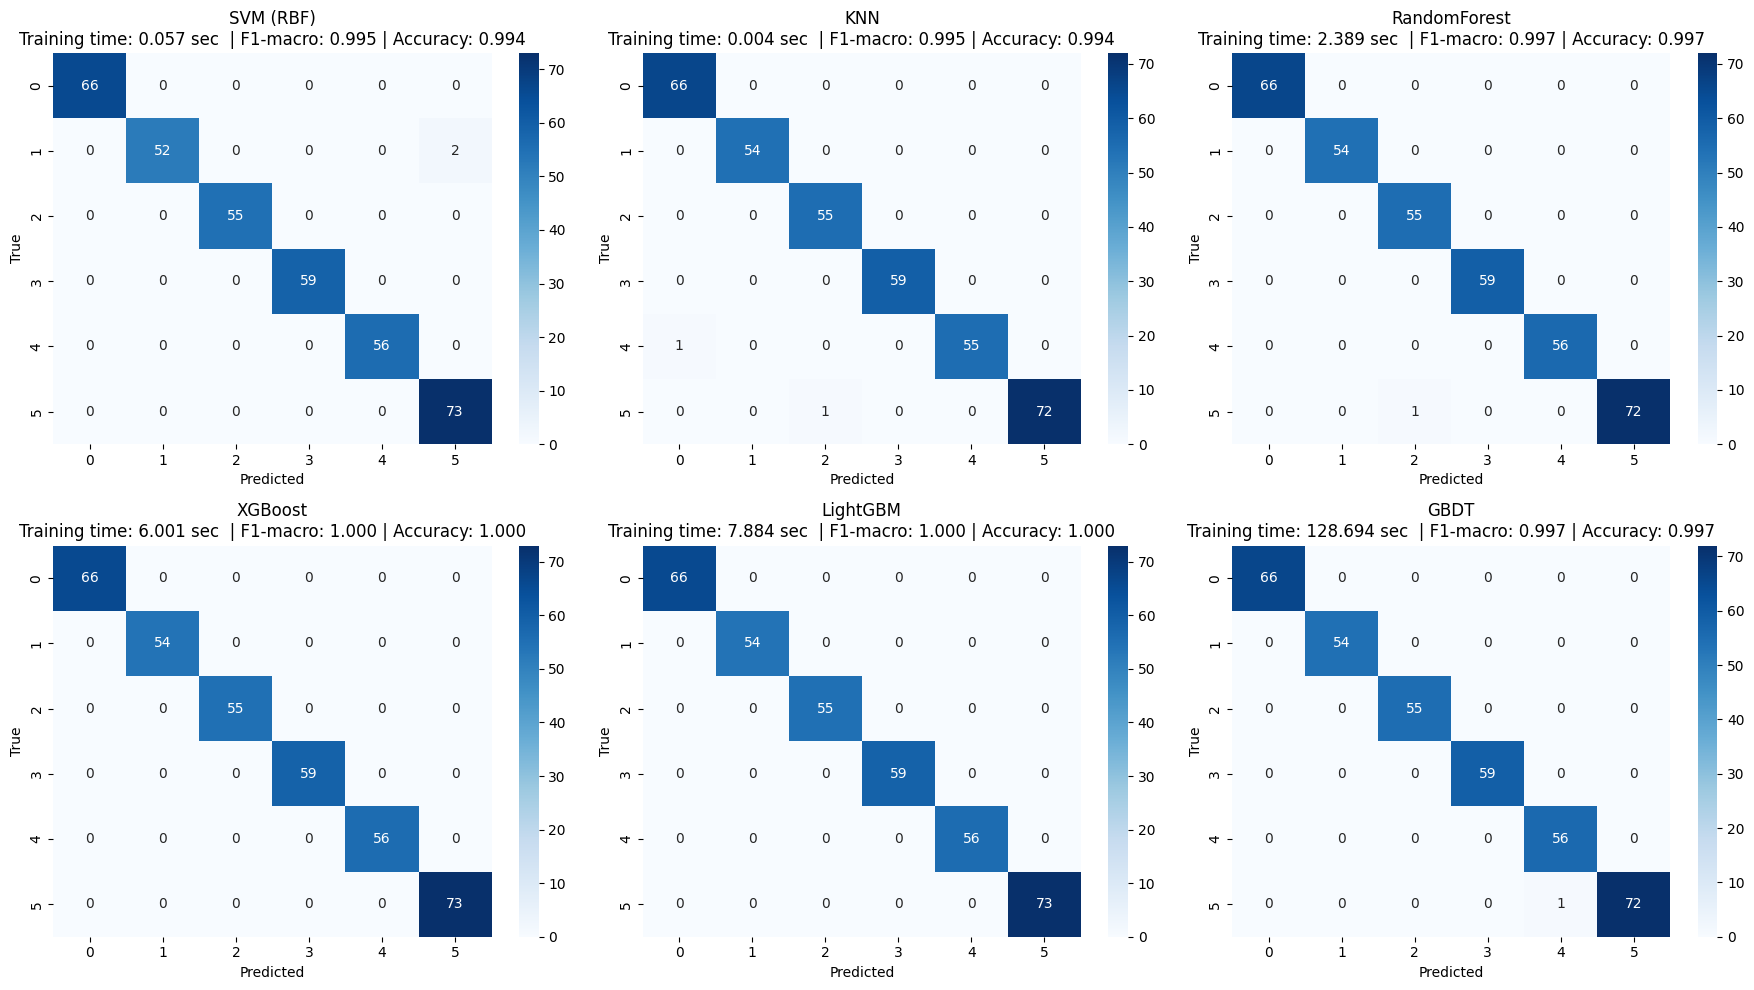


📁 Confusion matrices salvate in:Confusion_HTLTFMAX_features.png

📊 Summary of F1 Macro scores (+ training time):
          Model  F1_macro  Train_time_sec
4      LightGBM  1.000000        7.884103
3       XGBoost  1.000000        6.001128
5          GBDT  0.997376      128.693867
2  RandomForest  0.997349        2.388921
0     SVM (RBF)  0.994603        0.057124
1           KNN  0.994594        0.003607

📋 Full Classification Metrics Table (with training times):
           Model Class  Precision    Recall  F1-score  Support  Train_time_sec
0      SVM (RBF)     0   1.000000  1.000000  1.000000     66.0        0.057124
1      SVM (RBF)     1   1.000000  0.962963  0.981132     54.0        0.057124
2      SVM (RBF)     2   1.000000  1.000000  1.000000     55.0        0.057124
3      SVM (RBF)     3   1.000000  1.000000  1.000000     59.0        0.057124
4      SVM (RBF)     4   1.000000  1.000000  1.000000     56.0        0.057124
5      SVM (RBF)     5   0.973333  1.000000  0.986486     

c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:21:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 110156
[LightGBM] [Info] Number of data points in the train set: 847, number of used features: 432
[LightGBM] [Info] Start training from score -1.711263
[LightGBM] [Info] Start training from score -1.913387
[LightGBM] [Info] Start training from score -1.881888
[LightGBM] [Info] Start training from score -1.821720
[LightGBM] [Info] Start training from score -1.851352
[LightGBM] [Info] Start training from score -1.605902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


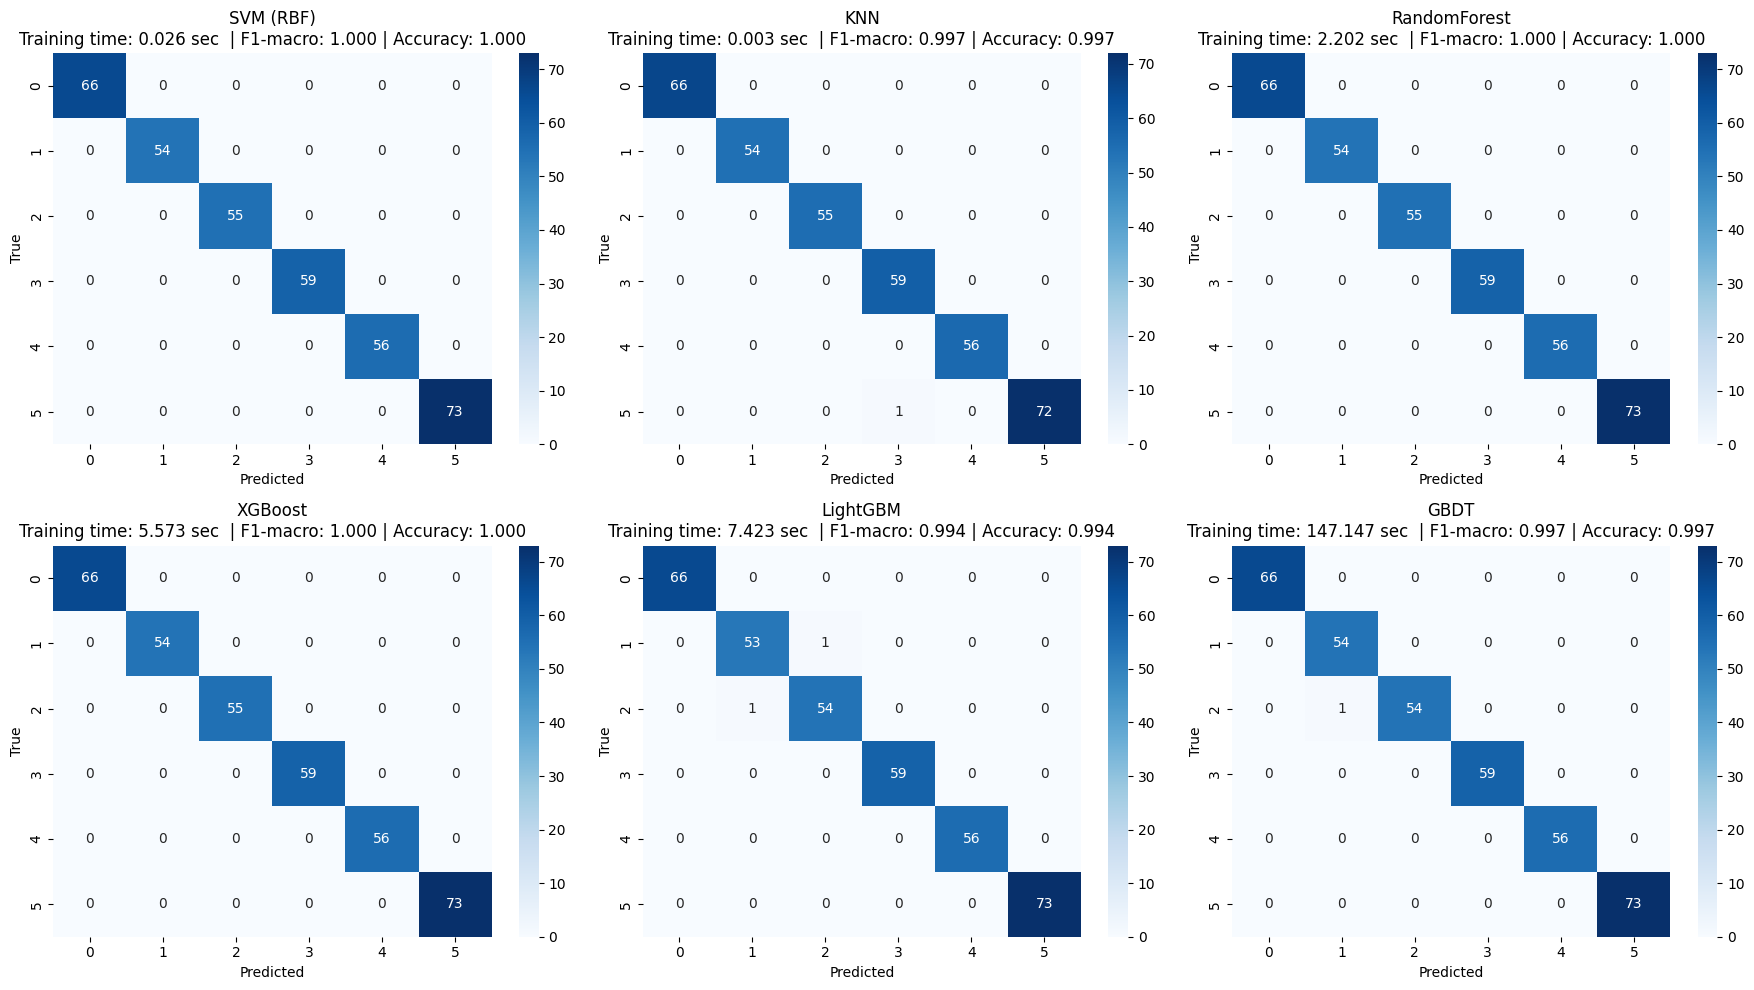


📁 Confusion matrices salvate in:Confusion_HTLTFQTL_features.png

📊 Summary of F1 Macro scores (+ training time):
          Model  F1_macro  Train_time_sec
0     SVM (RBF)  1.000000        0.025530
2  RandomForest  1.000000        2.202333
3       XGBoost  1.000000        5.573406
1           KNN  0.997450        0.002969
5          GBDT  0.996942      147.146627
4      LightGBM  0.993883        7.423267

📋 Full Classification Metrics Table (with training times):
           Model Class  Precision    Recall  F1-score  Support  Train_time_sec
0      SVM (RBF)     0   1.000000  1.000000  1.000000     66.0        0.025530
1      SVM (RBF)     1   1.000000  1.000000  1.000000     54.0        0.025530
2      SVM (RBF)     2   1.000000  1.000000  1.000000     55.0        0.025530
3      SVM (RBF)     3   1.000000  1.000000  1.000000     59.0        0.025530
4      SVM (RBF)     4   1.000000  1.000000  1.000000     56.0        0.025530
5      SVM (RBF)     5   1.000000  1.000000  1.000000     

c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:23:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 110158
[LightGBM] [Info] Number of data points in the train set: 847, number of used features: 432
[LightGBM] [Info] Start training from score -1.711263
[LightGBM] [Info] Start training from score -1.913387
[LightGBM] [Info] Start training from score -1.881888
[LightGBM] [Info] Start training from score -1.821720
[LightGBM] [Info] Start training from score -1.851352
[LightGBM] [Info] Start training from score -1.605902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


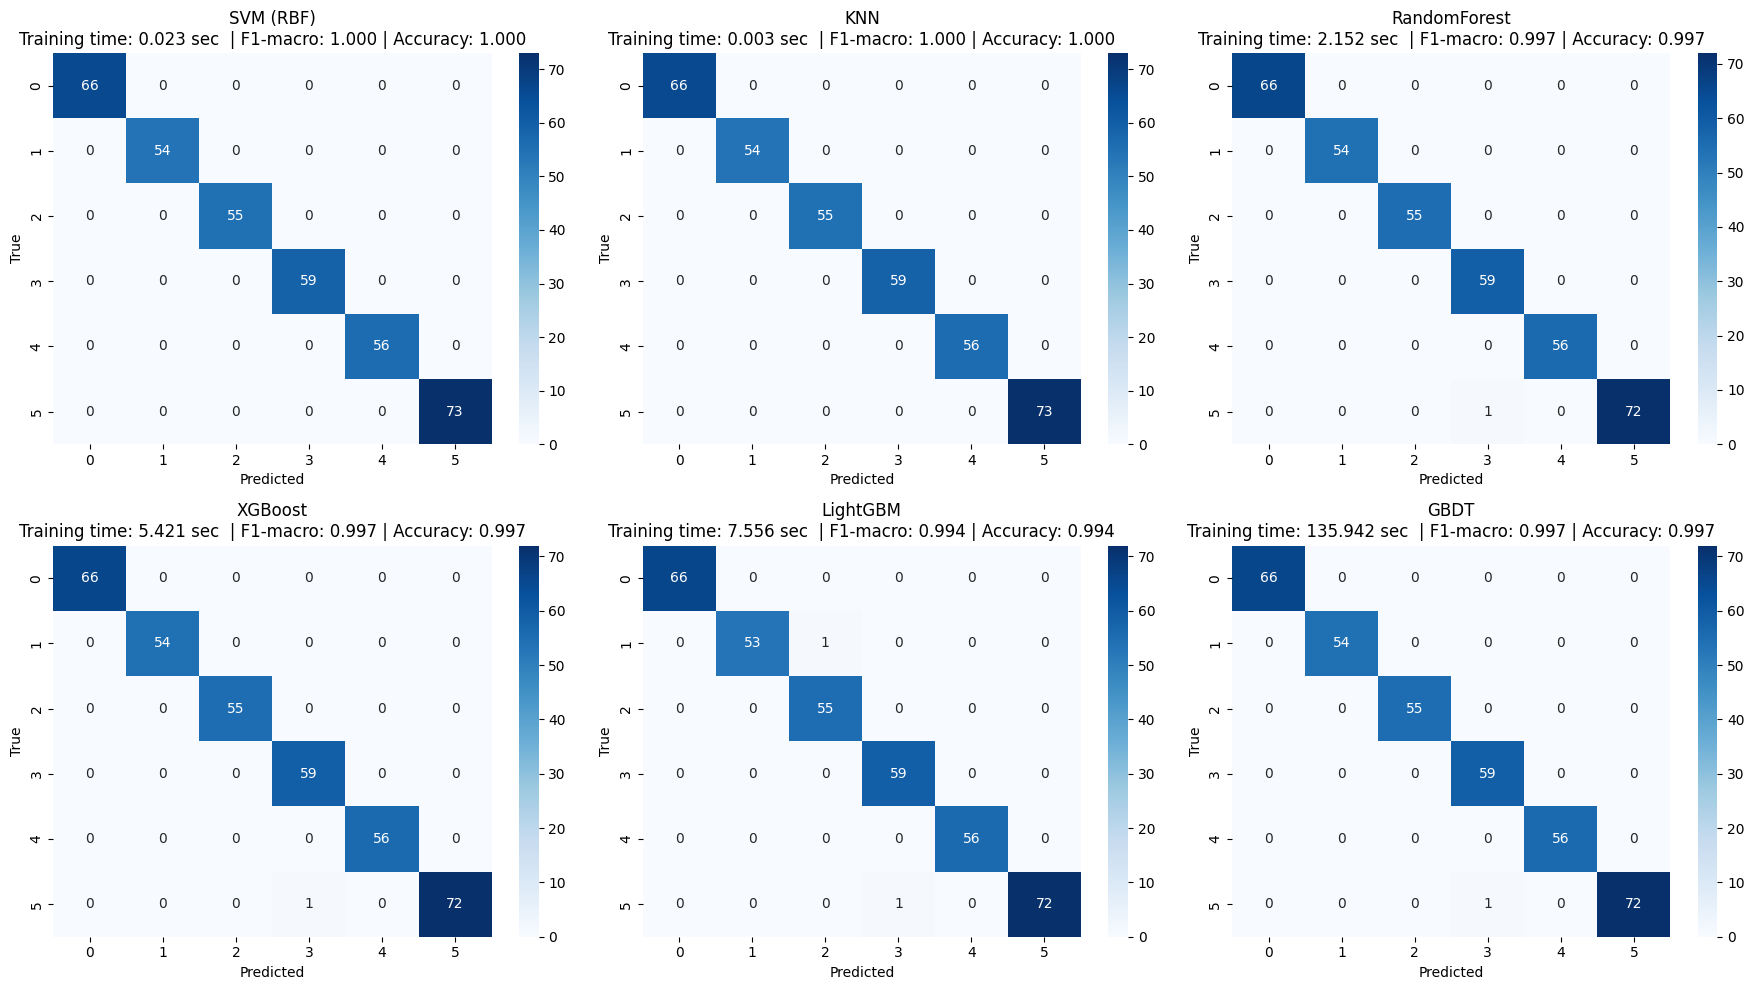


📁 Confusion matrices salvate in:Confusion_HTLTFQTU_features.png

📊 Summary of F1 Macro scores (+ training time):
          Model  F1_macro  Train_time_sec
0     SVM (RBF)  1.000000        0.023325
1           KNN  1.000000        0.003425
2  RandomForest  0.997450        2.152399
3       XGBoost  0.997450        5.420525
5          GBDT  0.997450      135.941963
4      LightGBM  0.994391        7.555699

📋 Full Classification Metrics Table (with training times):
           Model Class  Precision    Recall  F1-score  Support  Train_time_sec
0      SVM (RBF)     0   1.000000  1.000000  1.000000     66.0        0.023325
1      SVM (RBF)     1   1.000000  1.000000  1.000000     54.0        0.023325
2      SVM (RBF)     2   1.000000  1.000000  1.000000     55.0        0.023325
3      SVM (RBF)     3   1.000000  1.000000  1.000000     59.0        0.023325
4      SVM (RBF)     4   1.000000  1.000000  1.000000     56.0        0.023325
5      SVM (RBF)     5   1.000000  1.000000  1.000000     

c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:26:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 110160
[LightGBM] [Info] Number of data points in the train set: 847, number of used features: 432
[LightGBM] [Info] Start training from score -1.711263
[LightGBM] [Info] Start training from score -1.913387
[LightGBM] [Info] Start training from score -1.881888
[LightGBM] [Info] Start training from score -1.821720
[LightGBM] [Info] Start training from score -1.851352
[LightGBM] [Info] Start training from score -1.605902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


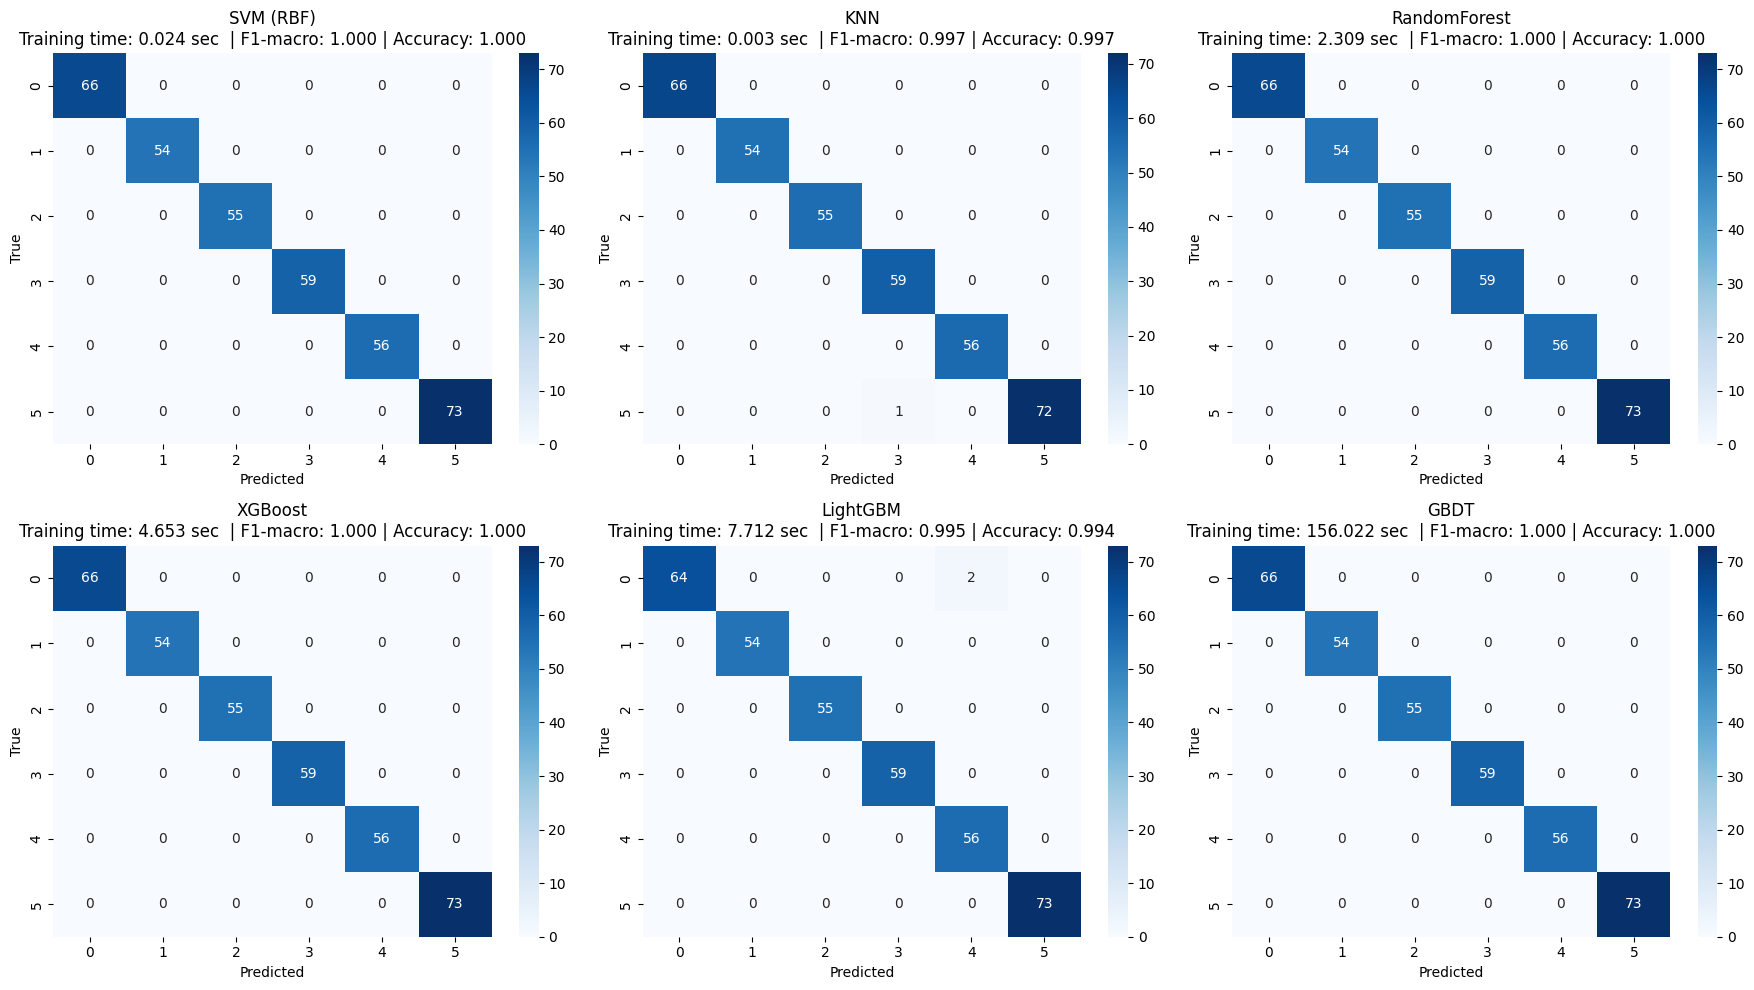


📁 Confusion matrices salvate in:Confusion_HTLTFAVG_features.png

📊 Summary of F1 Macro scores (+ training time):
          Model  F1_macro  Train_time_sec
0     SVM (RBF)  1.000000        0.023565
2  RandomForest  1.000000        2.308644
5          GBDT  1.000000      156.021881
3       XGBoost  1.000000        4.652776
1           KNN  0.997450        0.003380
4      LightGBM  0.994512        7.712069

📋 Full Classification Metrics Table (with training times):
           Model Class  Precision    Recall  F1-score  Support  Train_time_sec
0      SVM (RBF)     0   1.000000  1.000000  1.000000     66.0        0.023565
1      SVM (RBF)     1   1.000000  1.000000  1.000000     54.0        0.023565
2      SVM (RBF)     2   1.000000  1.000000  1.000000     55.0        0.023565
3      SVM (RBF)     3   1.000000  1.000000  1.000000     59.0        0.023565
4      SVM (RBF)     4   1.000000  1.000000  1.000000     56.0        0.023565
5      SVM (RBF)     5   1.000000  1.000000  1.000000     

c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:29:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 110160
[LightGBM] [Info] Number of data points in the train set: 847, number of used features: 432
[LightGBM] [Info] Start training from score -1.711263
[LightGBM] [Info] Start training from score -1.913387
[LightGBM] [Info] Start training from score -1.881888
[LightGBM] [Info] Start training from score -1.821720
[LightGBM] [Info] Start training from score -1.851352
[LightGBM] [Info] Start training from score -1.605902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


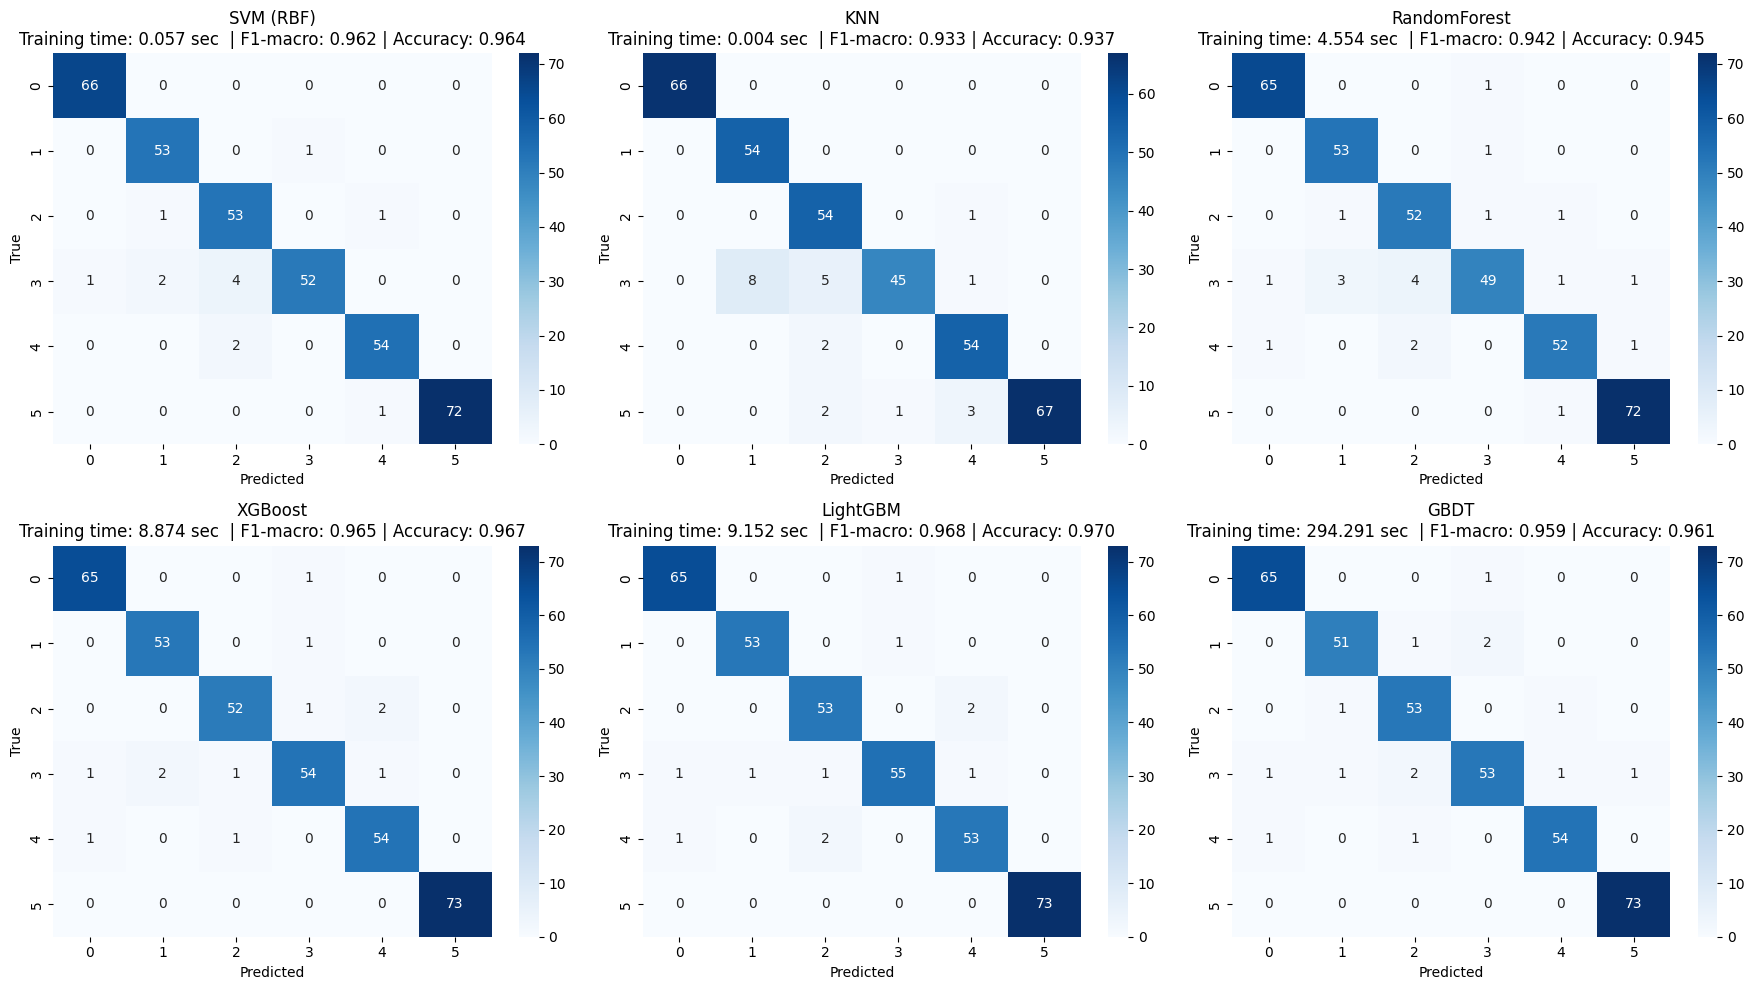


📁 Confusion matrices salvate in:Confusion_HTLTFIQR_features.png

📊 Summary of F1 Macro scores (+ training time):
          Model  F1_macro  Train_time_sec
4      LightGBM  0.968097        9.151559
3       XGBoost  0.965139        8.873679
0     SVM (RBF)  0.961984        0.056988
5          GBDT  0.959394      294.290649
2  RandomForest  0.942027        4.553895
1           KNN  0.933284        0.003660

📋 Full Classification Metrics Table (with training times):
           Model Class  Precision    Recall  F1-score  Support  Train_time_sec
0      SVM (RBF)     0   0.985075  1.000000  0.992481     66.0        0.056988
1      SVM (RBF)     1   0.946429  0.981481  0.963636     54.0        0.056988
2      SVM (RBF)     2   0.898305  0.963636  0.929825     55.0        0.056988
3      SVM (RBF)     3   0.981132  0.881356  0.928571     59.0        0.056988
4      SVM (RBF)     4   0.964286  0.964286  0.964286     56.0        0.056988
5      SVM (RBF)     5   1.000000  0.986301  0.993103     

c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:34:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 847, number of used features: 4
[LightGBM] [Info] Start training from score -1.711263
[LightGBM] [Info] Start training from score -1.913387
[LightGBM] [Info] Start training from score -1.881888
[LightGBM] [Info] Start training from score -1.821720
[LightGBM] [Info] Start training from score -1.851352
[LightGBM] [Info] Start training from score -1.605902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


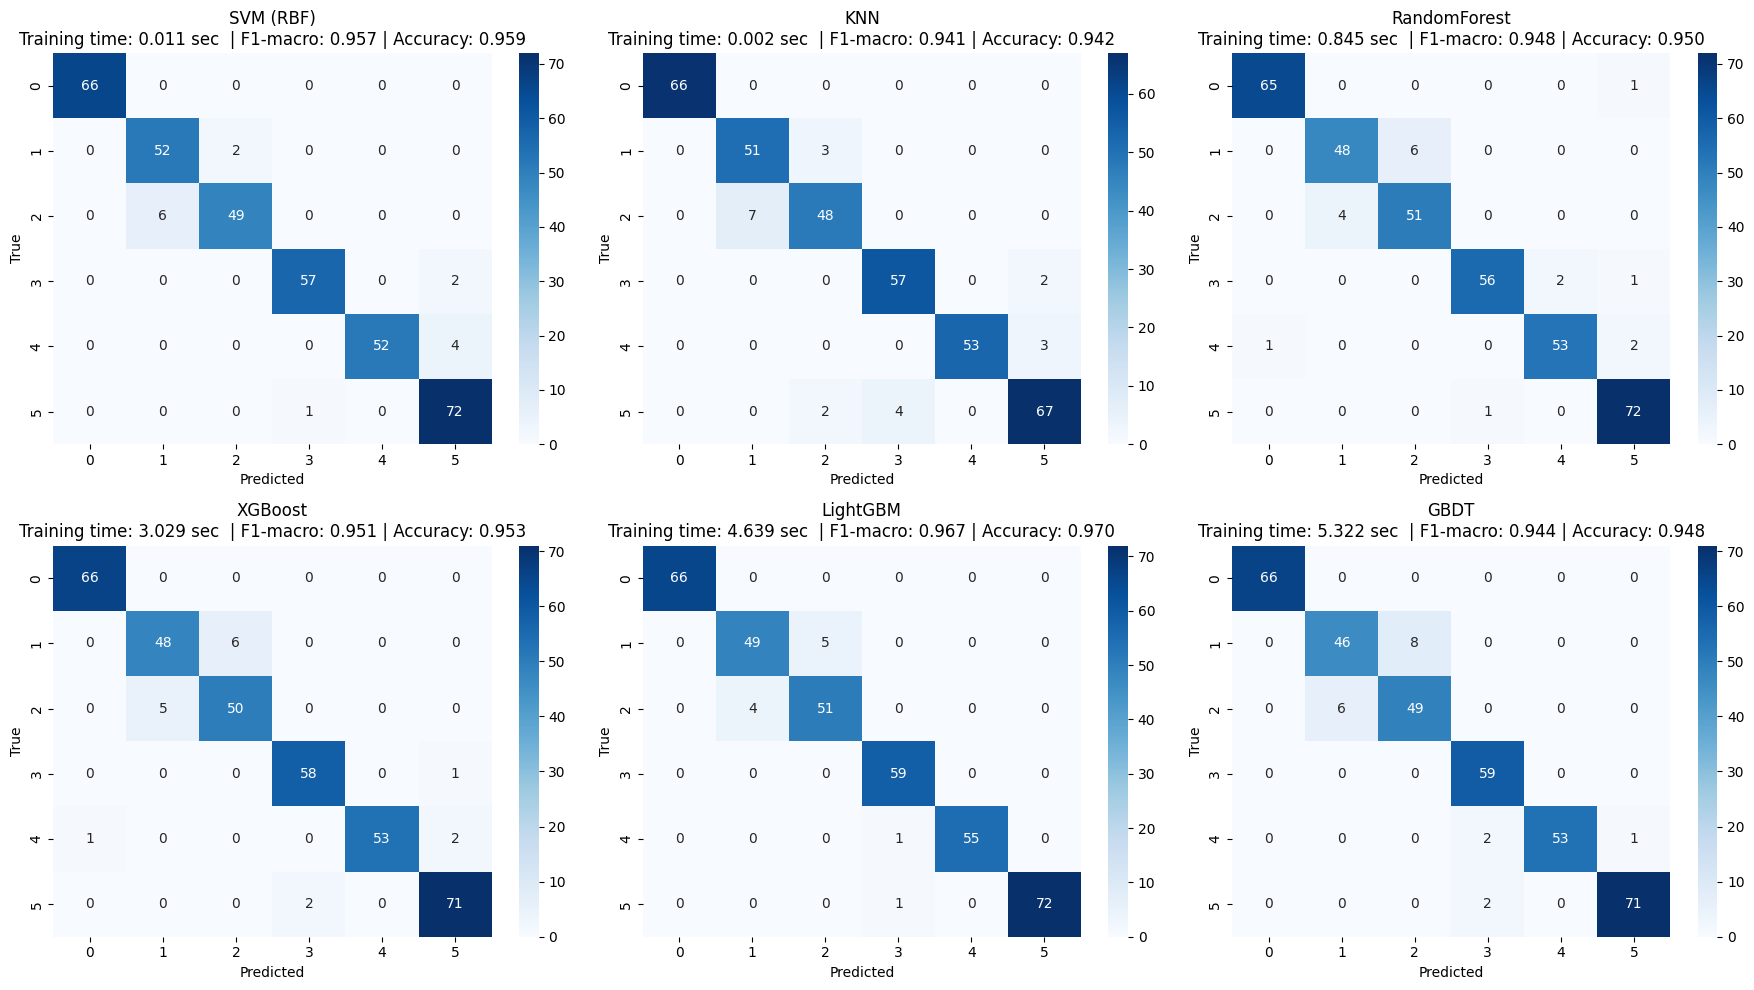


📁 Confusion matrices salvate in:Confusion_HTLTFEUC_features.png

📊 Summary of F1 Macro scores (+ training time):
          Model  F1_macro  Train_time_sec
4      LightGBM  0.967039        4.639308
0     SVM (RBF)  0.957344        0.011353
3       XGBoost  0.950639        3.029371
2  RandomForest  0.948023        0.844639
5          GBDT  0.943654        5.322172
1           KNN  0.941036        0.002409

📋 Full Classification Metrics Table (with training times):
           Model Class  Precision    Recall  F1-score  Support  Train_time_sec
0      SVM (RBF)     0   1.000000  1.000000  1.000000     66.0        0.011353
1      SVM (RBF)     1   0.896552  0.962963  0.928571     54.0        0.011353
2      SVM (RBF)     2   0.960784  0.890909  0.924528     55.0        0.011353
3      SVM (RBF)     3   0.982759  0.966102  0.974359     59.0        0.011353
4      SVM (RBF)     4   1.000000  0.928571  0.962963     56.0        0.011353
5      SVM (RBF)     5   0.923077  0.986301  0.953642     

c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:35:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106080
[LightGBM] [Info] Number of data points in the train set: 847, number of used features: 416
[LightGBM] [Info] Start training from score -1.711263
[LightGBM] [Info] Start training from score -1.913387
[LightGBM] [Info] Start training from score -1.881888
[LightGBM] [Info] Start training from score -1.821720
[LightGBM] [Info] Start training from score -1.851352
[LightGBM] [Info] Start training from score -1.605902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


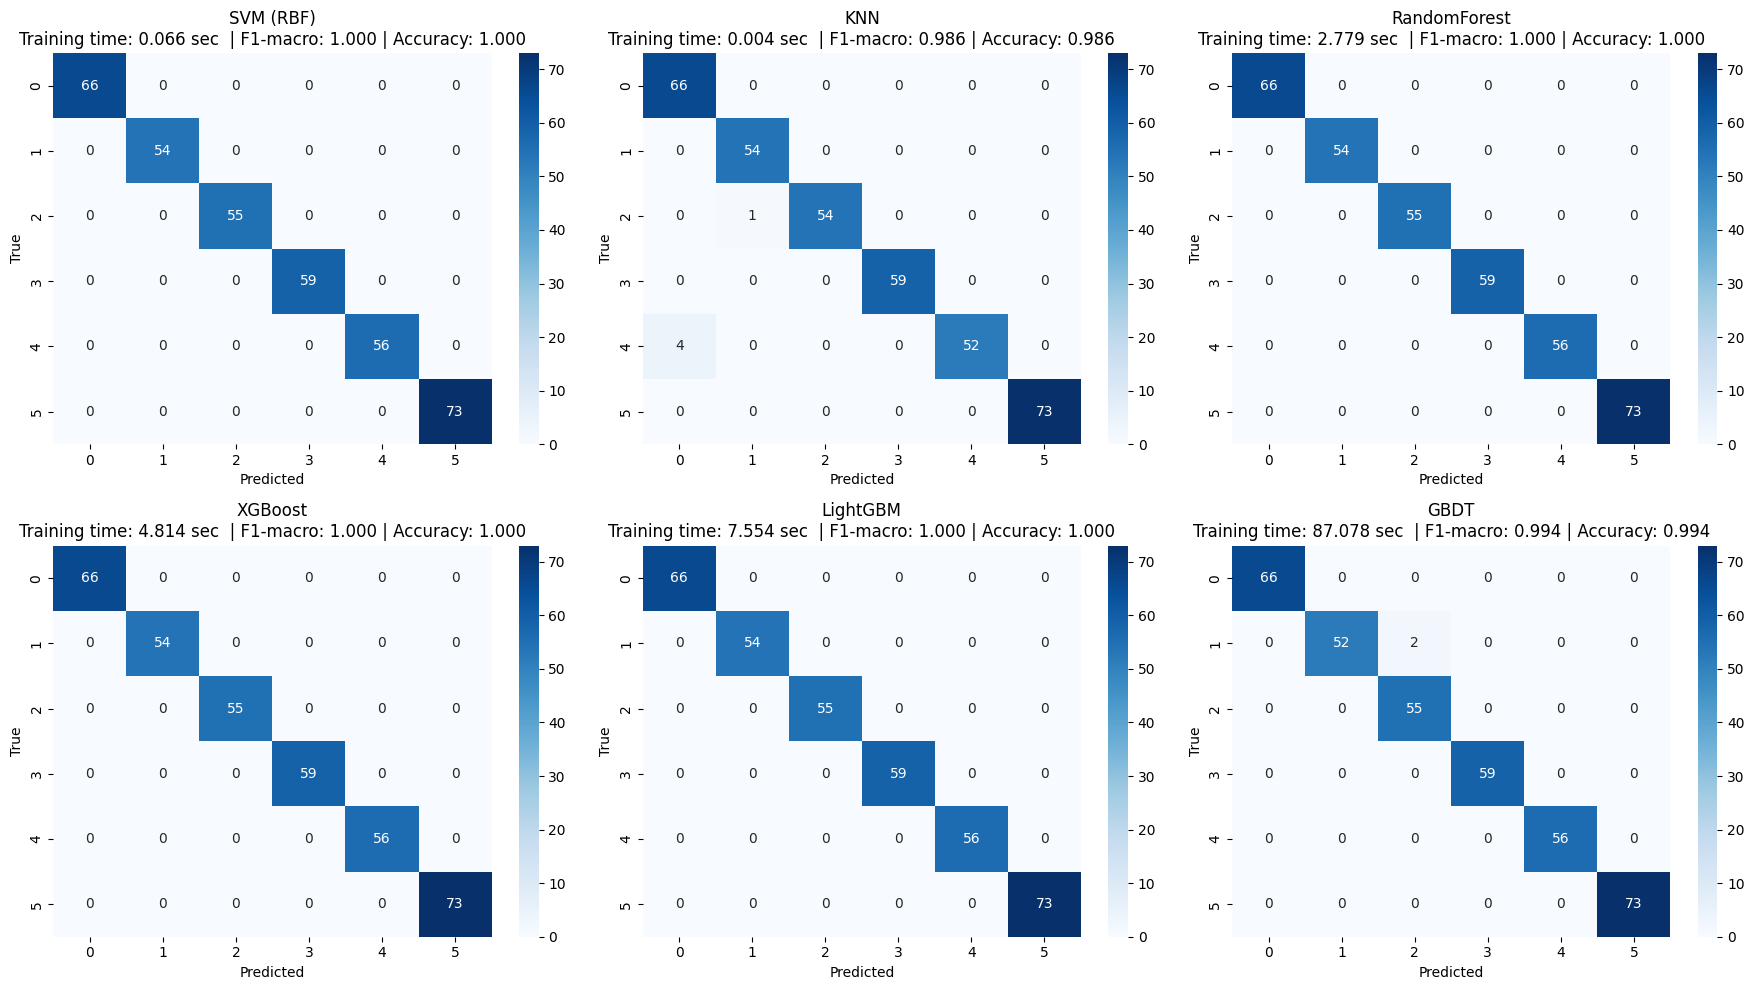


📁 Confusion matrices salvate in:Confusion_HTLTFADJ_features.png

📊 Summary of F1 Macro scores (+ training time):
          Model  F1_macro  Train_time_sec
0     SVM (RBF)  1.000000        0.066179
2  RandomForest  1.000000        2.778578
4      LightGBM  1.000000        7.554109
3       XGBoost  1.000000        4.814353
5          GBDT  0.993879       87.078441
1           KNN  0.985867        0.003791

📋 Full Classification Metrics Table (with training times):
           Model Class  Precision    Recall  F1-score  Support  Train_time_sec
0      SVM (RBF)     0   1.000000  1.000000  1.000000     66.0        0.066179
1      SVM (RBF)     1   1.000000  1.000000  1.000000     54.0        0.066179
2      SVM (RBF)     2   1.000000  1.000000  1.000000     55.0        0.066179
3      SVM (RBF)     3   1.000000  1.000000  1.000000     59.0        0.066179
4      SVM (RBF)     4   1.000000  1.000000  1.000000     56.0        0.066179
5      SVM (RBF)     5   1.000000  1.000000  1.000000     

In [126]:
results = []

for feat_name, feat_df in datasets_htltf.items():  # Usa il dizionario!
    X_cols = [c for c in feat_df.columns if c != 'target']
    df = feat_df[X_cols + ['target']]

    print(f"\nTesting feature set: {feat_name}")
    f1_df, metrics_df = train_classifiers_2(df, target_col="target", titolo_suffix=f"Confusion_HTLTF{feat_name.replace(' ', '_')}")
    best = f1_df.iloc[0]
    worst = f1_df.iloc[-1]
    results.append({
        "feature_group": feat_name,
        "best_model": best["Model"],
        "best_f1_macro": best["F1_macro"],
        "best_time": best["Train_time_sec"],
        "worst_model": worst["Model"],
        "worst_f1_macro": worst["F1_macro"],
        "worst_time": worst["Train_time_sec"]
    })

results_df = pd.DataFrame(results)
print(results_df)
